# Part 0: Load in libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from matplotlib.pyplot import gcf


# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Get and Analyze IDR clusters

## 1.1 - Map human genes

In [3]:
mapdf=pd.read_table('../general_data/sapiens_uniprot_gene_name_all.tsv')
accsmap=mapdf['Uniprot'].tolist()
genesmap=mapdf['Gene'].tolist()

## 1.2 - Load in IDR information

In [4]:
humandf=pd.read_excel('../general_data/All_sapiens_IDRs_clustermap_using_centroids.xlsx')

print(humandf.isnull().any())
humandf = humandf.fillna('')

fullaccs=humandf['Uniprot'].tolist()
fullaccswnums=humandf['Uniprot w IDRnum'].tolist()
fullgeneswnums=humandf['Gene'].tolist()
fullclusternum=humandf['Cluster Number'].tolist()
fullseqlens=humandf['IDR Length'].tolist()
fullstpos=humandf['Start Pos'].tolist()
fullenpos=humandf['End Pos'].tolist()
fullproteinlength=humandf['Full Protein Length'].tolist()
fullmininterclustdist=humandf['Min Inter Clust Dist'].tolist()
fulltermini=humandf['IDR Position'].tolist()
fulllocationbyunistring=humandf['HPA Location'].tolist()
fullseqs=humandf['Sequence'].tolist()



print(humandf)

Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
1               1  Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17   
2               2  Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1   
3               3  Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27   
4               4  Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27   
...           ...     ...              ...             ...             ...   
24503       24503  Q7Z739         Q7Z739_2     YTHDF

## 1.3 - Load in IDR z-score data

In [5]:
# make sure features match
myfeat=['pol-pol','pol-hyd','pol-pos','pol-neg','pol-aro','pol-ala','pol-pro','pol-gly','hyd-hyd','hyd-pos','hyd-neg','hyd-aro','hyd-ala','hyd-pro','hyd-gly','pos-pos','pos-neg','pos-aro','pos-ala','pos-pro','pos-gly','neg-neg','neg-aro','neg-ala','neg-pro','neg-gly','aro-aro','aro-ala','aro-pro','aro-gly','ala-ala','ala-pro','ala-gly','pro-pro','pro-gly','gly-gly','Frac A','Frac C','Frac D','Frac E','Frac F','Frac G','Frac H','Frac I','Frac K','Frac L','Frac M','Frac N','Frac P','Frac Q','Frac R','Frac S','Frac T','Frac V','Frac W','Frac Y','Frac K+R','Frac D+E','Frac Polar','Frac Aliphatic','Frac Aromatic','R/K Ratio','E/D Ratio','Frac Chain Expanding','FCR','NCPR','Hydrophobicity','Disorder Promoting','Iso point','PPII','A Patch','C Patch','D Patch','E Patch','F Patch','G Patch','H Patch','I Patch','K Patch','L Patch','M Patch','N Patch','P Patch','Q Patch','R Patch','S Patch','T Patch','V Patch','Y Patch','RG Frac']
print(len(myfeat))

# Load in z-scores for all human IDRs
# Made in /project/fava/work/kiersten.ruff/Collaborations/Su/2023/Library_design/map_clusters_for_all_human_IDRs.ipynb
fullzvec=np.load('../general_data/sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')
print(fullzvec.shape)

90
(24508, 90)


## 1.4 - Create subset of IDRs that want to analyze - all IDRs length gte 70 and non-linker IDRs gte 50 in length and min inter cluster distance gte 1.5

In [6]:
minidrlength=50
minidrlinkerlength=70
mininterclustdist=1.5

subidrsdf=humandf[humandf['IDR Length']>=minidrlength]
subidrsdf=subidrsdf[ (subidrsdf['IDR Length']>=minidrlinkerlength) | (subidrsdf['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]
subidrsdf=subidrsdf[subidrsdf['Min Inter Clust Dist']>=mininterclustdist]
print(subidrsdf.isnull().any())
subidrsdf = subidrsdf.fillna('')
print(subidrsdf)

subaccs=subidrsdf['Uniprot'].tolist()
subaccswnums=subidrsdf['Uniprot w IDRnum'].tolist()
subgeneswnums=subidrsdf['Gene'].tolist()
subclusters=subidrsdf['Cluster Number'].tolist()
subseqlens=subidrsdf['IDR Length'].tolist()
substpos=subidrsdf['Start Pos'].tolist()
subenpos=subidrsdf['End Pos'].tolist()
subproteinlength=subidrsdf['Full Protein Length'].tolist()
submininterclustdist=subidrsdf['Min Inter Clust Dist'].tolist()
subtermini=subidrsdf['IDR Position'].tolist()
subseqs=subidrsdf['Sequence'].tolist()
sublocstring=subidrsdf['HPA Location'].tolist()


sublocationbyunistring=sublocstring


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location            False
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
7               7  Q9NRJ4         Q9NRJ4_7      TULP4 IDR7              23   
8               8  Q5MIZ7         Q5MIZ7_1    PPP4R3B IDR1              18   
12             12  Q9NQ76         Q9NQ76_1       MEPE IDR1               4   
14             14  Q9NQ76         Q9NQ76_3       MEPE IDR3              24   
...           ...     ...              ...             ...             ...   
24495       24495  Q6ZSZ5         Q6ZSZ5_1   ARHGEF1

## 1.5 Print accessions so can get KEGG IDs

In [10]:
### Only needs to be done once ###
#dfsapiens=pd.read_table('../sapiens_uniprot_gene_name_all.tsv')
#print(dfsapiens)

#checklist=[]
#for s in dfsapiens['Uniprot'].tolist():
#    if s not in checklist:
#        print(s)
#        checklist.append(s)

          Uniprot        Gene
0      A0A087X1C5      CYP2D7
1      A0A0B4J2F0     PIGBOS1
2      A0A0B4J2F2       SIK1B
3      A0A0B5A886          GP
4      A0A0B5AC19         NSS
...           ...         ...
26038      Q9Y6Z2   LINC01558
26039      Q9YIT9  Segment-12
26040      Q9YWQ0   Segment-7
26041      Q9YZN9       P/V/C
26042      X6R8R1      SYT15B

[26043 rows x 2 columns]
A0A087X1C5
A0A0B4J2F0
A0A0B4J2F2
A0A0B5A886
A0A0B5AC19
A0A0C5B5G6
A0A0K2S4Q6
A0A0U1RRE5
A0A1B0GTW7
A0AV02
A0AV96
A0AVF1
A0AVI4
A0AVK6
A0AVT1
A0FGR8
A0FGR9
A0JLT2
A0JNW5
A0JP26
A0M8Q6
A0MZ66
A0PJK1
A0PJY2
A0PK00
A0PK11
A1A4S6
A1A4Y4
A1A519
A1A5B4
A1A5C7
A1E959
A1KXE4
A1KZ92
A1L0T0
A1L167
A1L190
A1L390
A1L3X0
A1L4H1
A1L4K1
A1X283
A1XBS5
A1Z1Q3
A1Z651
A2A288
A2A2Y4
A2IDD5
A2PYH4
A2RRP1
A2RTX5
A2RU14
A2RU30
A2RU49
A2RUB1
A2RUB6
A2RUC4
A2RUH7
A2VDJ0
A2VEC9
A3DRP1
A3KMH1
A3RM23
A4D0S4
A4D126
A4D161
A4D1B5
A4D1E9
A4D1P6
A4D1T9
A4D256
A4D2B0
A4D2B8
A4GBX8
A4GCH6
A4GCI7
A4GCJ8
A4GCK9
A4GCM0
A4GXA9
A4K144
A4U6V3
A4U7

O95219
O95229
O95231
O95232
O95235
O95236
O95237
O95238
O95239
O95243
O95248
O95249
O95251
O95255
O95256
O95257
O95258
O95259
O95263
O95264
O95267
O95271
O95273
O95274
O95278
O95279
O95292
O95294
O95295
O95297
O95298
O95299
O95302
O95319
O95340
O95342
O95343
O95347
O95352
O95359
O95361
O95363
O95365
O95372
O95373
O95376
O95377
O95379
O95382
O95388
O95389
O95390
O95391
O95393
O95394
O95395
O95396
O95398
O95399
O95400
O95402
O95405
O95406
O95407
O95409
O95415
O95416
O95425
O95427
O95428
O95429
O95433
O95436
O95445
O95447
O95450
O95452
O95453
O95456
O95460
O95461
O95466
O95467
O95470
O95471
O95475
O95476
O95477
O95479
O95484
O95486
O95487
O95490
O95497
O95498
O95500
O95503
O95528
O95544
O95551
O95562
O95563
O95568
O95571
O95573
O95600
O95602
O95613
O95619
O95622
O95628
O95630
O95631
O95633
O95639
O95644
O95670
O95671
O95672
O95674
O95677
O95678
O95684
O95696
O95704
O95707
O95711
O95714
O95715
O95716
O95718
O95721
O95727
O95741
O95747
O95749
O95750
O95751
O95754
O95758
O95760
O95772
O95777

P15735
P15812
P15813
P15814
P15822
P15831
P15832
P15833
P15848
P15863
P15880
P15882
P15884
P15907
P15918
P15923
P15924
P15927
P15941
P15954
P15976
P16035
P16050
P16066
P16070
P16083
P16104
P16109
P16112
P16118
P16144
P16150
P16152
P16157
P16219
P16220
P16233
P16234
P16278
P16284
P16286
P16287
P16289
P16298
P16333
P16379
P16383
P16389
P16401
P16402
P16403
P16410
P16422
P16435
P16442
P16444
P16452
P16455
P16471
P16473
P16493
P16499
P16519
P16520
P16581
P16591
P16615
P16619
P16662
P16671
P16753
P16766
P16778
P16788
P16790
P16853
P16860
P16870
P16871
P16885
P16930
P16949
P16989
P17010
P17014
P17020
P17021
P17022
P17023
P17024
P17027
P17028
P17036
P17040
P17041
P17050
P17066
P17081
P17096
P17099
P17101
P17151
P17152
P17174
P17181
P17213
P17252
P17275
P17301
P17302
P17332
P17342
P17397
P17398
P17399
P17405
P17480
P17481
P17482
P17483
P17509
P17516
P17535
P17540
P17542
P17544
P17568
P17600
P17612
P17643
P17655
P17658
P17661
P17676
P17677
P17693
P17706
P17707
P17735
P17752
P17755
P17756
P17757

P41180
P41181
P41182
P41208
P41212
P41214
P41217
P41218
P41219
P41220
P41221
P41222
P41223
P41225
P41226
P41227
P41229
P41231
P41235
P41236
P41238
P41240
P41247
P41250
P41252
P41265
P41266
P41271
P41273
P41279
P41439
P41440
P41567
P41586
P41587
P41594
P41595
P41597
P41732
P41743
P41968
P41970
P42025
P42081
P42126
P42127
P42166
P42167
P42224
P42226
P42229
P42261
P42262
P42263
P42285
P42330
P42331
P42336
P42338
P42345
P42356
P42566
P42568
P42574
P42575
P42658
P42677
P42679
P42680
P42681
P42684
P42685
P42694
P42695
P42701
P42702
P42704
P42765
P42766
P42768
P42771
P42772
P42773
P42785
P42830
P42857
P42858
P42892
P42898
P43003
P43004
P43005
P43007
P43026
P43034
P43080
P43088
P43115
P43119
P43121
P43146
P43155
P43166
P43220
P43234
P43235
P43243
P43246
P43250
P43251
P43268
P43304
P43307
P43320
P43351
P43353
P43354
P43355
P43356
P43357
P43358
P43360
P43361
P43364
P43365
P43378
P43403
P43405
P43487
P43489
P43490
P43626
P43628
P43629
P43630
P43631
P43632
P43652
P43657
P43681
P43686
P43694
P43699

Q01082
Q01085
Q01094
Q01101
Q01105
Q01113
Q01118
Q01130
Q01151
Q01167
Q01196
Q01201
Q01344
Q01362
Q01415
Q01432
Q01433
Q01449
Q01453
Q01469
Q01484
Q01518
Q01523
Q01524
Q01534
Q01538
Q01543
Q01546
Q01581
Q01628
Q01629
Q01638
Q01650
Q01658
Q01664
Q01668
Q01718
Q01726
Q01740
Q01780
Q01804
Q01813
Q01814
Q01826
Q01831
Q01844
Q01850
Q01851
Q01860
Q01892
Q01954
Q01955
Q01959
Q01968
Q01970
Q01973
Q01974
Q02040
Q02078
Q02080
Q02083
Q02086
Q02094
Q02108
Q02127
Q02153
Q02156
Q02161
Q02218
Q02223
Q02224
Q02241
Q02246
Q02252
Q02297
Q02317
Q02318
Q02363
Q02383
Q02388
Q02410
Q02413
Q02446
Q02447
Q02487
Q02505
Q02535
Q02539
Q02543
Q02548
Q02556
Q02575
Q02577
Q02641
Q02643
Q02742
Q02747
Q02750
Q02763
Q02779
Q02790
Q02809
Q02817
Q02818
Q02833
Q02846
Q02878
Q02880
Q02928
Q02930
Q02952
Q02962
Q02978
Q02985
Q03001
Q03013
Q03014
Q03052
Q03060
Q03111
Q03112
Q03113
Q03135
Q03154
Q03164
Q03167
Q03181
Q03188
Q03252
Q03393
Q03395
Q03396
Q03403
Q03405
Q03426
Q03431
Q03468
Q03495
Q03518
Q03519
Q03591
Q03692
Q03721

Q16534
Q16537
Q16539
Q16540
Q16543
Q16548
Q16549
Q16552
Q16553
Q16555
Q16558
Q16560
Q16563
Q16566
Q16568
Q16570
Q16572
Q16576
Q16581
Q16584
Q16585
Q16586
Q16587
Q16594
Q16595
Q16600
Q16602
Q16610
Q16611
Q16612
Q16613
Q16617
Q16619
Q16620
Q16621
Q16623
Q16625
Q16627
Q16629
Q16630
Q16633
Q16635
Q16637
Q16643
Q16644
Q16647
Q16649
Q16650
Q16651
Q16653
Q16654
Q16655
Q16656
Q16658
Q16659
Q16663
Q16665
Q16666
Q16667
Q16670
Q16671
Q16674
Q16676
Q16678
Q16690
Q16695
Q16696
Q16698
Q16706
Q16718
Q16719
Q16720
Q16739
Q16740
Q16760
Q16762
Q16763
Q16769
Q16772
Q16773
Q16774
Q16775
Q16777
Q16778
Q16787
Q16790
Q16795
Q16798
Q16799
Q16816
Q16819
Q16820
Q16821
Q16822
Q16825
Q16827
Q16828
Q16829
Q16831
Q16832
Q16836
Q16842
Q16849
Q16850
Q16851
Q16853
Q16854
Q16864
Q16873
Q16875
Q16877
Q16878
Q16880
Q16881
Q16890
Q16891
Q17R60
Q17R89
Q17R98
Q17RB8
Q17RD7
Q17RS7
Q17RW2
Q17RY0
Q18PE1
Q19AV6
Q19T08
Q1EHB4
Q1HG43
Q1HG44
Q1HVC7
Q1K9Q1
Q1L5Z9
Q1MSJ5
Q1MX18
Q1PDC7
Q1RMZ1
Q1W6H9
Q22618
Q24JP5
Q27ID8
Q27ID9
Q27J81

Q8IWU4
Q8IWU5
Q8IWU6
Q8IWU9
Q8IWV1
Q8IWV2
Q8IWV7
Q8IWV8
Q8IWW6
Q8IWW8
Q8IWX5
Q8IWX7
Q8IWX8
Q8IWY4
Q8IWY9
Q8IWZ3
Q8IWZ4
Q8IWZ5
Q8IWZ6
Q8IWZ8
Q8IX01
Q8IX03
Q8IX04
Q8IX05
Q8IX07
Q8IX12
Q8IX15
Q8IX19
Q8IX21
Q8IX30
Q8IX90
Q8IXA5
Q8IXB1
Q8IXB3
Q8IXF0
Q8IXH6
Q8IXH7
Q8IXH8
Q8IXI1
Q8IXI2
Q8IXJ6
Q8IXJ9
Q8IXK0
Q8IXK2
Q8IXL6
Q8IXL7
Q8IXM2
Q8IXM3
Q8IXM6
Q8IXN7
Q8IXP5
Q8IXQ5
Q8IXQ6
Q8IXQ9
Q8IXS2
Q8IXV7
Q8IXW0
Q8IXW5
Q8IXZ2
Q8IY17
Q8IY18
Q8IY21
Q8IY22
Q8IY26
Q8IY31
Q8IY33
Q8IY34
Q8IY37
Q8IY49
Q8IY57
Q8IY63
Q8IY81
Q8IY82
Q8IY84
Q8IY92
Q8IY95
Q8IYA6
Q8IYA8
Q8IYB1
Q8IYB3
Q8IYB4
Q8IYB5
Q8IYB7
Q8IYB8
Q8IYD1
Q8IYD8
Q8IYE0
Q8IYE1
Q8IYF1
Q8IYF3
Q8IYG6
Q8IYH5
Q8IYI0
Q8IYI6
Q8IYI8
Q8IYJ0
Q8IYJ1
Q8IYJ2
Q8IYJ3
Q8IYK4
Q8IYL9
Q8IYM1
Q8IYM2
Q8IYM9
Q8IYP9
Q8IYR0
Q8IYR2
Q8IYR6
Q8IYS1
Q8IYS5
Q8IYT2
Q8IYT3
Q8IYT4
Q8IYT8
Q8IYU2
Q8IYU8
Q8IYV9
Q8IYW5
Q8IYX1
Q8IYX3
Q8IYX7
Q8IYX8
Q8IYY4
Q8IZ07
Q8IZ20
Q8IZ21
Q8IZ41
Q8IZ52
Q8IZ69
Q8IZ96
Q8IZA0
Q8IZC4
Q8IZC6
Q8IZC7
Q8IZD2
Q8IZD4
Q8IZD9
Q8IZE3
Q8IZF0
Q8IZF2
Q8IZF3
Q8IZF6
Q8IZF7

Q96HP8
Q96HR3
Q96HR8
Q96HR9
Q96HS1
Q96HT8
Q96HU1
Q96HW7
Q96HY6
Q96HY7
Q96HZ4
Q96I15
Q96I23
Q96I24
Q96I25
Q96I27
Q96I34
Q96I51
Q96I59
Q96I76
Q96I99
Q96IF1
Q96II8
Q96IJ6
Q96IK1
Q96IK5
Q96IL0
Q96IP4
Q96IQ9
Q96IR7
Q96IS3
Q96IT1
Q96IU2
Q96IU4
Q96IV0
Q96IV6
Q96IW7
Q96IX5
Q96IY1
Q96IY4
Q96IZ0
Q96IZ2
Q96IZ5
Q96IZ6
Q96IZ7
Q96J01
Q96J02
Q96J42
Q96J65
Q96J66
Q96J84
Q96J87
Q96J92
Q96J94
Q96JA1
Q96JA3
Q96JB1
Q96JB2
Q96JB3
Q96JB5
Q96JB6
Q96JB8
Q96JC1
Q96JC9
Q96JD6
Q96JE7
Q96JE9
Q96JF0
Q96JG6
Q96JG8
Q96JG9
Q96JH7
Q96JH8
Q96JI7
Q96JJ3
Q96JJ6
Q96JJ7
Q96JK2
Q96JK9
Q96JL9
Q96JM2
Q96JM3
Q96JM7
Q96JN0
Q96JN2
Q96JP0
Q96JP5
Q96JP9
Q96JQ0
Q96JQ5
Q96JS3
Q96JW4
Q96JX3
Q96JY0
Q96JY6
Q96JZ2
Q96K12
Q96K19
Q96K21
Q96K30
Q96K58
Q96K76
Q96K78
Q96K80
Q96K83
Q96KA5
Q96KB5
Q96KC8
Q96KG7
Q96KG9
Q96KK3
Q96KK4
Q96KK5
Q96KM6
Q96KN2
Q96KN3
Q96KN4
Q96KN7
Q96KN8
Q96KP1
Q96KP4
Q96KP6
Q96KQ4
Q96KQ7
Q96KR4
Q96KR6
Q96KR7
Q96KS0
Q96KV7
Q96L08
Q96L12
Q96L21
Q96L34
Q96L42
Q96L46
Q96L50
Q96L58
Q96L73
Q96L91
Q96L92
Q96L93
Q96L96
Q96LA5

Q9HD47
Q9HD67
Q9HD89
Q9HD90
Q9HDB5
Q9HDC5
Q9HDC9
Q9HDD0
Q9IBI3
Q9IDV1
Q9IDV2
Q9IDV5
Q9IDV8
Q9IDV9
Q9IFX2
Q9IGQ6
Q9IH62
Q9IH63
Q9IK90
Q9IK91
Q9IK92
Q9IPJ5
Q9IPJ8
Q9IQ49
Q9IVZ8
Q9IVZ9
Q9IWW8
Q9J3M8
Q9JFA8
Q9N2F1
Q9NNW5
Q9NNW7
Q9NNX6
Q9NP31
Q9NP50
Q9NP55
Q9NP56
Q9NP58
Q9NP59
Q9NP60
Q9NP61
Q9NP62
Q9NP64
Q9NP66
Q9NP70
Q9NP71
Q9NP72
Q9NP73
Q9NP74
Q9NP77
Q9NP78
Q9NP79
Q9NP80
Q9NP81
Q9NP84
Q9NP85
Q9NP86
Q9NP87
Q9NP90
Q9NP91
Q9NP94
Q9NP95
Q9NP97
Q9NP98
Q9NP99
Q9NPA0
Q9NPA1
Q9NPA2
Q9NPA8
Q9NPB1
Q9NPB3
Q9NPB6
Q9NPB9
Q9NPC1
Q9NPC2
Q9NPC3
Q9NPC4
Q9NPC6
Q9NPC7
Q9NPC8
Q9NPD3
Q9NPD5
Q9NPD8
Q9NPE2
Q9NPE3
Q9NPE6
Q9NPF0
Q9NPF2
Q9NPF4
Q9NPF5
Q9NPF7
Q9NPF8
Q9NPG1
Q9NPG2
Q9NPG3
Q9NPG4
Q9NPG8
Q9NPH0
Q9NPH2
Q9NPH3
Q9NPH5
Q9NPH9
Q9NPI0
Q9NPI1
Q9NPI5
Q9NPI6
Q9NPI8
Q9NPI9
Q9NPJ1
Q9NPJ3
Q9NPJ4
Q9NPJ6
Q9NPJ8
Q9NPL8
Q9NPP4
Q9NPQ8
Q9NPR2
Q9NPR9
Q9NPY3
Q9NPZ5
Q9NQ11
Q9NQ25
Q9NQ29
Q9NQ30
Q9NQ31
Q9NQ33
Q9NQ36
Q9NQ38
Q9NQ40
Q9NQ48
Q9NQ50
Q9NQ55
Q9NQ66
Q9NQ69
Q9NQ75
Q9NQ76
Q9NQ79
Q9NQ84
Q9NQ86
Q9NQ87
Q9NQ88
Q9NQ90
Q9NQ92

Q9Y2D1
Q9Y2D2
Q9Y2D4
Q9Y2D8
Q9Y2E5
Q9Y2E6
Q9Y2E8
Q9Y2F5
Q9Y2F9
Q9Y2G0
Q9Y2G1
Q9Y2G2
Q9Y2G3
Q9Y2G5
Q9Y2G8
Q9Y2G9
Q9Y2H0
Q9Y2H1
Q9Y2H2
Q9Y2H6
Q9Y2H9
Q9Y2I1
Q9Y2I2
Q9Y2I6
Q9Y2I7
Q9Y2I8
Q9Y2I9
Q9Y2J0
Q9Y2J2
Q9Y2J4
Q9Y2J8
Q9Y2K1
Q9Y2K2
Q9Y2K3
Q9Y2K5
Q9Y2K6
Q9Y2K7
Q9Y2K9
Q9Y2L1
Q9Y2L5
Q9Y2L9
Q9Y2M0
Q9Y2M2
Q9Y2M5
Q9Y2N7
Q9Y2P0
Q9Y2P4
Q9Y2P5
Q9Y2P7
Q9Y2P8
Q9Y2Q0
Q9Y2Q3
Q9Y2Q5
Q9Y2R0
Q9Y2R2
Q9Y2R4
Q9Y2S2
Q9Y2S7
Q9Y2T1
Q9Y2T2
Q9Y2T3
Q9Y2T6
Q9Y2T7
Q9Y2U5
Q9Y2U8
Q9Y2U9
Q9Y2V0
Q9Y2V2
Q9Y2V3
Q9Y2V7
Q9Y2W1
Q9Y2W2
Q9Y2W3
Q9Y2W6
Q9Y2W7
Q9Y2X0
Q9Y2X3
Q9Y2X7
Q9Y2X8
Q9Y2X9
Q9Y2Y0
Q9Y2Y1
Q9Y2Y4
Q9Y2Y6
Q9Y2Y8
Q9Y2Y9
Q9Y2Z0
Q9Y2Z2
Q9Y2Z4
Q9Y2Z9
Q9Y303
Q9Y314
Q9Y315
Q9Y316
Q9Y320
Q9Y324
Q9Y328
Q9Y333
Q9Y336
Q9Y337
Q9Y342
Q9Y345
Q9Y365
Q9Y366
Q9Y371
Q9Y375
Q9Y376
Q9Y383
Q9Y385
Q9Y388
Q9Y394
Q9Y397
Q9Y399
Q9Y3A0
Q9Y3A2
Q9Y3A3
Q9Y3A4
Q9Y3A5
Q9Y3A6
Q9Y3B2
Q9Y3B3
Q9Y3B4
Q9Y3B7
Q9Y3B8
Q9Y3C0
Q9Y3C4
Q9Y3C5
Q9Y3C6
Q9Y3C7
Q9Y3C8
Q9Y3D0
Q9Y3D2
Q9Y3D3
Q9Y3D6
Q9Y3D7
Q9Y3D8
Q9Y3D9
Q9Y3E0
Q9Y3E1
Q9Y3E2
Q9Y3E5
Q9Y3E7
Q9Y3F4

P67923
P68543
P68592
P68639
P68761
P68762
P68950
P69353
P69354
P69355
P69356
P69357
P69358
P69359
P69360
P69480
P69699
P69707
P69708
P69713
P78312
P78414
P80748
P81133
P81877
P82663
P82673
P82675
P82912
P82921
P82933
P82970
P82980
P83859
P84101
P84351
P86791
P87670
P87691
P87889
P88838
P89079
P89436
P89445
P89449
P89459
P89475
P89873
P90493
P98169
P98173
Q00071
Q01455
Q01459
Q01639
Q01995
Q02004
Q02045
Q02048
Q02049
Q02221
Q02261
Q02314
Q02338
Q02386
Q02509
Q03169
Q03500
Q03701
Q03816
Q03817
Q03828
Q03936
Q04611
Q05048
Q05059
Q05134
Q05486
Q05952
Q05D32
Q06732
Q07507
Q07846
Q07848
Q07FI2
Q07FI4
Q07FI5
Q08ER8
Q09104
Q09105
Q09SZ7
Q09T00
Q0A2H5
Q0A2R1
Q0D2J5
Q0GBX5
Q0GBX8
Q0GBY0
Q0GBY3
Q0HD57
Q0HD60
Q0R5Q9
Q0R5R4
Q0VDF9
Q0ZLH3
Q0ZME8
Q12796
Q12829
Q12872
Q12894
Q12901
Q12926
Q12950
Q12988
Q12996
Q12999
Q13103
Q13106
Q13203
Q13401
Q13434
Q13442
Q13474
Q13606
Q13607
Q13939
Q14093
Q14094
Q14201
Q14206
Q14324
Q14409
Q14439
Q14576
Q14590
Q14593
Q14641
Q14681
Q14952
Q14C87
Q14EB1
Q15034
Q15035

Q9UDV7
Q9UDX5
Q9UEE9
Q9UF02
Q9UGQ2
Q9UH62
Q9UHA3
Q9UHE8
Q9UHF5
Q9UHP9
Q9UHQ4
Q9UHR6
Q9UHV5
Q9UHW5
Q9UIF3
Q9UII5
Q9UIM3
Q9UJ04
Q9UJ42
Q9UJ99
Q9UJG1
Q9UJK0
Q9UJU3
Q9UJV8
Q9UJW7
Q9UK08
Q9UK11
Q9UK13
Q9UK85
Q9UKB3
Q9UKD2
Q9UKH3
Q9UKJ0
Q9UKJ3
Q9UKL2
Q9UKL4
Q9UKR3
Q9UKT6
Q9UKU9
Q9UKY3
Q9UKZ1
Q9UL36
Q9UL58
Q9ULB5
Q9ULE3
Q9ULE6
Q9ULJ7
Q9ULK2
Q9ULK6
Q9ULL5
Q9ULR5
Q9ULS5
Q9ULS6
Q9ULZ0
Q9UN30
Q9UN66
Q9UN67
Q9UN70
Q9UN71
Q9UN75
Q9UNK9
Q9UNL2
Q9UNN4
Q9UNX9
Q9UPU3
Q9UPX0
Q9UQ10
Q9UQ72
Q9UQG0
Q9W7Y7
Q9WAA1
Q9WCD8
Q9WCD9
Q9WCE1
Q9WCE3
Q9WCE8
Q9WFX3
Q9WMB3
Q9Y2A4
Q9Y2B2
Q9Y2C2
Q9Y2D5
Q9Y2D9
Q9Y2G4
Q9Y2H8
Q9Y2L6
Q9Y2L8
Q9Y2Q1
Q9Y2Q9
Q9Y2R5
Q9Y2R9
Q9Y2T4
Q9Y2T5
Q9Y2U2
Q9Y305
Q9Y330
Q9Y334
Q9Y3B6
Q9Y3C1
Q9Y3X0
Q9Y421
Q9Y471
Q9Y4F5
Q9Y4I5
Q9Y4K1
Q9Y4P3
Q9Y543
Q9Y573
Q9Y585
Q9Y597
Q9Y5E1
Q9Y5E2
Q9Y5E4
Q9Y5E5
Q9Y5E6
Q9Y5E7
Q9Y5E8
Q9Y5F0
Q9Y5F3
Q9Y5F6
Q9Y5F8
Q9Y5F9
Q9Y5G0
Q9Y5G1
Q9Y5G2
Q9Y5G3
Q9Y5G4
Q9Y5G5
Q9Y5G6
Q9Y5G7
Q9Y5G8
Q9Y5G9
Q9Y5H0
Q9Y5H1
Q9Y5H2
Q9Y5H3
Q9Y5H4
Q9Y5H6
Q9Y5H7
Q9Y5I0
Q9Y5I1
Q9Y5I4
Q9Y5J9

P13173
P13174
P13175
P13176
P13177
P13290
P13293
P13871
P13872
P13873
P13874
P13875
P13876
P13878
P13881
P13882
P13884
P13885
P14379
P14597
P15141
P15197
P15199
P15200
P15421
P15422
P15673
P15677
P15678
P15679
P15682
P15834
P15835
P16071
P16196
P16200
P16202
P16204
P16206
P16208
P16314
P16380
P16415
P16494
P16495
P16502
P16504
P16506
P16507
P16508
P16509
P16510
P16511
P16512
P16514
P16562
P16721
P16724
P16725
P16727
P16731
P16732
P16736
P16739
P16743
P16744
P16750
P16757
P16769
P16785
P16789
P16793
P16815
P16823
P16824
P16832
P16846
P16978
P16980
P16982
P16985
P16986
P16987
P16988
P17017
P17042
P17102
P17147
P17149
P17176
P17240
P17241
P17382
P17383
P17386
P17388
P17389
P17402
P17470
P17474
P17754
P17758
P17759
P17761
P18043
P18044
P18045
P18069
P18070
P18071
P18072
P18073
P18093
P18097
P18098
P18099
P18139
P18295
P18803
P18805
P18806
P18877
P18878
P18879
P18882
P18883
P18884
P19063
P19325
P19326
P19416
P19462
P19475
P19547
P19548
P19555
P19703
P19709
P19710
P19716
P19762
P19847
P19900

Q5VUY0
Q5VVM6
Q5VW22
Q5VWQ0
Q5VX52
Q5VXU3
Q5VYM1
Q5VYV0
Q5VYV7
Q5VZ03
Q5VZ46
Q5VZ66
Q5W041
Q5W0A0
Q5W0B7
Q5W0V3
Q5W186
Q5W188
Q5W5W9
Q5XG99
Q5XKK7
Q5XKR9
Q5XUX1
Q5XX02
Q5XX03
Q5XX06
Q5XX08
Q5YKI7
Q63HM2
Q63HM9
Q63ZE4
Q64ET8
Q658K8
Q658L1
Q658N2
Q65ZG0
Q66453
Q66T62
Q66T63
Q67157
Q67163
Q67171
Q67180
Q67181
Q67185
Q67187
Q67200
Q67202
Q67204
Q67253
Q67296
Q67356
Q676U7
Q67877
Q67923
Q68101
Q68396
Q68666
Q68667
Q68668
Q68669
Q68670
Q68671
Q68672
Q68673
Q68674
Q68980
Q68CQ7
Q68CR1
Q68DI1
Q68DN1
Q68DU8
Q68DY9
Q69467
Q69489
Q69604
Q69607
Q69YU3
Q6AHZ1
Q6AI08
Q6AI12
Q6AW86
Q6B0B8
Q6BEB4
Q6DD87
Q6DHV5
Q6DKI1
Q6DNK1
Q6DNK5
Q6DNL8
Q6DNL9
Q6DNM0
Q6DNM1
Q6DNM2
Q6DNQ5
Q6DNQ9
Q6DNS2
Q6DNS3
Q6DNS4
Q6DNS5
Q6DNS6
Q6DNV6
Q6DNW3
Q6DNX6
Q6DNX7
Q6DNX8
Q6DNX9
Q6DNY0
Q6DP28
Q6DP37
Q6DP62
Q6DP64
Q6DP66
Q6DP68
Q6DP70
Q6DPC7
Q6DPD2
Q6DPE5
Q6DPE6
Q6DPE7
Q6DPE8
Q6DPE9
Q6DPQ0
Q6DPQ6
Q6DPT4
Q6DPT6
Q6DPT8
Q6DPU0
Q6DPU2
Q6DQ15
Q6EBC2
Q6F5E7
Q6GPI1
Q6GV28
Q6I7C0
Q6I7C2
Q6I7C3
Q6I7C4
Q6ICC9
Q6ICG6
Q6ICH7
Q6IE38
Q6IEE8

Q96A98
Q96AB3
Q96AQ9
Q96B33
Q96B45
Q96BJ8
Q96BM0
Q96BQ1
Q96BW5
Q96BX8
Q96C01
Q96C34
Q96C57
Q96C90
Q96CD0
Q96CH1
Q96CS4
Q96CT2
Q96DC7
Q96DD0
Q96DL1
Q96DS6
Q96DU9
Q96DY2
Q96E16
Q96E39
Q96E66
Q96EH5
Q96EI5
Q96EK2
Q96EL2
Q96ER3
Q96ES6
Q96ET8
Q96EV2
Q96EZ4
Q96F63
Q96FB5
Q96G27
Q96GE5
Q96GE6
Q96GK7
Q96GT9
Q96GU1
Q96H12
Q96H40
Q96H79
Q96HA4
Q96HP4
Q96HV5
Q96I13
Q96IC2
Q96ID5
Q96J77
Q96JF6
Q96JM4
Q96K17
Q96K37
Q96K75
Q96KC9
Q96KD3
Q96KF2
Q96KJ4
Q96KN9
Q96KT7
Q96KV6
Q96KW9
Q96L03
Q96L11
Q96LB0
Q96LK8
Q96LP2
Q96LQ0
Q96LR4
Q96LT6
Q96LU5
Q96LU7
Q96LW1
Q96M20
Q96M34
Q96M53
Q96M93
Q96M95
Q96MC5
Q96MC6
Q96ME7
Q96MF6
Q96MK2
Q96MN5
Q96MR6
Q96MR9
Q96MS3
Q96MU6
Q96MW1
Q96MY1
Q96N03
Q96N11
Q96N20
Q96N22
Q96N46
Q96NA8
Q96ND8
Q96NG8
Q96NI8
Q96NJ3
Q96NJ5
Q96NJ6
Q96NK8
Q96NS5
Q96NT1
Q96NU7
Q96P64
Q96P67
Q96PG2
Q96PI1
Q96PT3
Q96PT4
Q96PX6
Q96QA6
Q96QD5
Q96QE4
Q96QH8
Q96QK8
Q96QZ0
Q96R05
Q96R08
Q96R09
Q96R27
Q96R28
Q96R30
Q96R45
Q96R47
Q96R54
Q96R67
Q96R69
Q96R72
Q96R84
Q96RB7
Q96RC9
Q96RD0
Q96RD1
Q96RD2
Q96RD3

P0CF75
P0CG23
P0CG24
P0CG32
P0CG33
P0CG41
P0CI00
P0CI01
P0CJ68
P0CJ69
P0CJ70
P0CJ71
P0CJ73
P0CJ74
P0CJ75
P0CJ76
P0CJ77
P0CJ78
P0CJ79
P0CJ85
P0CJ86
P0CJ87
P0CJ88
P0CJ89
P0CJ90
P0CJ92
P0CK20
P0CK22
P0CK23
P0CK48
P0CK50
P0CK56
P0CK62
P0CK63
P0CK64
P0CK65
P0CK66
P0CK67
P0CK68
P0CK69
P0CK70
P0CK71
P0CK72
P0CK73
P0CK74
P0CK76
P0CK77
P0CK78
P0CK79
P0CK84
P0CK85
P0CK86
P0CK88
P0CK90
P0CK92
P0CL80
P0CL81
P0CL83
P0CL84
P0CL85
P0CW19
P0CW21
P0CW24
P0CW27
P0DI80
P0DJ93
P0DJG4
P0DJH9
P0DJR0
P0DJR5
P0DJR6
P0DJR7
P0DJR8
P0DJR9
P0DJS0
P0DJS1
P0DJS2
P0DJS3
P0DJS4
P0DJS5
P0DJS6
P0DJS7
P0DJS8
P0DJS9
P0DJT0
P0DJT1
P0DJT2
P0DJT3
P0DJT4
P0DJT5
P0DJT6
P0DJT7
P0DJT9
P0DJU0
P0DJU2
P0DJU3
P0DJU4
P0DJU5
P0DJU6
P0DJU7
P0DJU8
P0DJU9
P0DJV0
P0DJV1
P0DJV2
P0DJV3
P0DJV4
P0DJW0
P0DJW1
P0DJW2
P0DJW3
P0DJW4
P0DJW5
P0DJW6
P0DJW7
P0DJW8
P0DJW9
P0DJX5
P0DKB5
P0DKX0
P0DKX4
P0DL12
P0DMB1
P0DMB2
P0DMP1
P0DMQ5
P0DMR1
P0DMR2
P0DMR3
P0DMU7
P0DMU8
P0DMU9
P0DMV0
P0DN25
P0DO92
P0DOG3
P0DOG5
P0DOG6
P0DOG7
P0DOK9
P0DOL0
P0DOL1
P0DOL2

Q86XG9
Q86XI8
Q86Y27
Q86Y28
Q86Y29
Q86Y30
Q86YG4
Q89186
Q89489
Q89721
Q89733
Q89738
Q89743
Q89882
Q8B0H4
Q8B0H8
Q8B0H9
Q8B0I3
Q8B6J9
Q8BDV6
Q8IU53
Q8IUI4
Q8IV32
Q8IV35
Q8IV56
Q8IVB5
Q8IVE0
Q8IVF1
Q8IVJ8
Q8IVK1
Q8IVU9
Q8IWA6
Q8IWD5
Q8IWF7
Q8IWF9
Q8IWN6
Q8IX95
Q8IXL9
Q8IXM7
Q8IXQ8
Q8IXR5
Q8IXR9
Q8IXS0
Q8IY42
Q8IY45
Q8IYA2
Q8IYD2
Q8IYN6
Q8IYQ7
Q8IZ63
Q8IZP6
Q8IZQ5
Q8IZU2
Q8JPQ9
Q8JPR0
Q8JTH3
Q8MH63
Q8N0U4
Q8N0U7
Q8N0V1
Q8N0W5
Q8N0W7
Q8N123
Q8N1D5
Q8N1P7
Q8N239
Q8N268
Q8N2C3
Q8N2G6
Q8N2R8
Q8N2U0
Q8N319
Q8N326
Q8N398
Q8N412
Q8N446
Q8N485
Q8N4B5
Q8N4C9
Q8N4E4
Q8N4K4
Q8N4L4
Q8N4P6
Q8N4S7
Q8N4V2
Q8N4W6
Q8N535
Q8N5C1
Q8N5Q1
Q8N5S3
Q8N5U0
Q8N5W8
Q8N614
Q8N6C7
Q8N6G2
Q8N6L7
Q8N6N2
Q8N6Q8
Q8N6V4
Q8N755
Q8N769
Q8N7C4
Q8N7L0
Q8N7N1
Q8N7Q2
Q8N7R1
Q8N7S6
Q8N7U9
Q8N7X1
Q8N7X2
Q8N7X8
Q8N7Y1
Q8N7Z2
Q8N808
Q8N813
Q8N816
Q8N888
Q8N8A8
Q8N8D7
Q8N8D9
Q8N8E1
Q8N8H1
Q8N8I0
Q8N8I6
Q8N8J7
Q8N8L6
Q8N8Z3
Q8N910
Q8N945
Q8N9B4
Q8N9C0
Q8N9H9
Q8N9R0
Q8N9R6
Q8N9T2
Q8N9V3
Q8N9X5
Q8N9Z2
Q8NA57
Q8NA66
Q8NA70
Q8NA75
Q8NAA5

## 1.6 Load in mapping for full human sequences

In [7]:
dfkegguni=pd.read_table('../general_data/KEGG/KEGG_uniprot_to_hsa_sapiens_all.tsv')

fullhsacc=dfkegguni['To'].tolist()
fulluniacc=dfkegguni['From'].tolist()

## 1.7 - Get KEGG per cluster

In [8]:
numkclusts=max(fullclusternum)+1

hsaacc=[]
uniacc=[]
geneacc=[]
tmpcount=0
for c in range(0,numkclusts):
    tmpdf=subidrsdf[subidrsdf['Cluster Number']==c]
    curracclist=tmpdf['Uniprot'].tolist()
    
    tmpacclist=[]
    tmphsalist=[]
    for s in range(0,len(curracclist)):
        if curracclist[s] in fulluniacc:
            tmpacclist.append(curracclist[s])
            tmphsalist.append(fullhsacc[fulluniacc.index(curracclist[s])])
            #print(tmpacclist)
            #print(tmphsalist)

    hsaacc.append(tmphsalist)
    uniacc.append(tmpacclist)
    
    print('Cluster '+str(c)+': '+str(len(tmphsalist)))
    tmpcount=tmpcount+len(tmphsalist)
    
print(tmpcount)


Cluster 0: 217
Cluster 1: 283
Cluster 2: 93
Cluster 3: 367
Cluster 4: 303
Cluster 5: 164
Cluster 6: 438
Cluster 7: 234
Cluster 8: 106
Cluster 9: 371
Cluster 10: 160
Cluster 11: 145
Cluster 12: 223
Cluster 13: 287
Cluster 14: 240
Cluster 15: 165
Cluster 16: 229
Cluster 17: 415
Cluster 18: 222
Cluster 19: 300
Cluster 20: 293
Cluster 21: 135
Cluster 22: 115
Cluster 23: 296
Cluster 24: 479
Cluster 25: 355
Cluster 26: 157
Cluster 27: 369
Cluster 28: 189
Cluster 29: 386
7736


# Part 2: Get enrichment of KEGG pathways

## 2.1 - Load in KEGG database data

In [9]:
dfpathname=pd.read_table('../general_data/KEGG/KEGG_map_pathway_to_name_2024_03.txt')
dfpathname['Pathway ID'] = dfpathname['Pathway ID'].replace({'map': 'path:hsa'}, regex=True)
print(dfpathname)
mappathIDtoName=dfpathname['Pathway ID'].tolist()
mapNametopathID=dfpathname['Pathway Name'].tolist()

dfpathhsa=pd.read_table('../general_data/KEGG/KEGG_linked_pathway_hsa_2024_03.txt')
print(dfpathhsa)
mappathtohsa=dfpathhsa['Pathway ID'].tolist()
maphsatopath=dfpathhsa['Gene ID'].tolist()

        Pathway ID                                  Pathway Name
0    path:hsa01100                            Metabolic pathways
1    path:hsa01110         Biosynthesis of secondary metabolites
2    path:hsa01120  Microbial metabolism in diverse environments
3    path:hsa01200                             Carbon metabolism
4    path:hsa01210               2-Oxocarboxylic acid metabolism
..             ...                                           ...
564  path:hsa07035                                Prostaglandins
565  path:hsa07110                           Benzoic acid family
566  path:hsa07112              1,2-Diphenyl substitution family
567  path:hsa07114                            Naphthalene family
568  path:hsa07117                         Benzodiazepine family

[569 rows x 2 columns]
         Gene ID     Pathway ID
0      hsa:10327  path:hsa00010
1        hsa:124  path:hsa00010
2        hsa:125  path:hsa00010
3        hsa:126  path:hsa00010
4        hsa:127  path:hsa00010
... 

## 2.2 - Get subset of pathways in IDRome

In [10]:
subpathidlist=[]
subpathnamelist=[]
genestopath=[]
for m in range (0,numkclusts):
    print('Cluster '+str(m))
    for s in range(0,len(hsaacc[m])):
        if hsaacc[m][s] in maphsatopath:
            #print(hsaacc[m][s])
            #print(uniacc[m][s])
            pos=[i for i, x in enumerate(maphsatopath) if x==hsaacc[m][s]]
            for p in pos:
                if mappathtohsa[p] not in subpathidlist:
                    subpathidlist.append(mappathtohsa[p])
                    #print(hsaacc[m][s])
                    #print(maphsatopath[p])
                    #print(mappathtohsa[p])
                    curridx=mappathIDtoName.index(mappathtohsa[p])
                    subpathnamelist.append(mapNametopathID[curridx])
                    print(mapNametopathID[curridx])
                    #hi
print(len(subpathidlist))


Cluster 0
Endocrine resistance
Cell cycle
Cellular senescence
Cushing syndrome
Hepatitis C
Hepatitis B
Human cytomegalovirus infection
Human T-cell leukemia virus 1 infection
Kaposi sarcoma-associated herpesvirus infection
Epstein-Barr virus infection
Pathways in cancer
MicroRNAs in cancer
Pancreatic cancer
Glioma
Prostate cancer
Melanoma
Bladder cancer
Chronic myeloid leukemia
Small cell lung cancer
Non-small cell lung cancer
Breast cancer
Hepatocellular carcinoma
Gastric cancer
Circadian rhythm
Nucleocytoplasmic transport
mRNA surveillance pathway
Spliceosome
Amyotrophic lateral sclerosis
Herpes simplex virus 1 infection
TGF-beta signaling pathway
Hippo signaling pathway
C-type lectin receptor signaling pathway
Viral carcinogenesis
Th1 and Th2 cell differentiation
Th17 cell differentiation
T cell receptor signaling pathway
B cell receptor signaling pathway
Neurotrophin signaling pathway
Adipocytokine signaling pathway
PD-L1 expression and PD-1 checkpoint pathway in cancer
Calcium sig

Fatty acid elongation
Biosynthesis of unsaturated fatty acids
Cluster 21
Cluster 22
Cluster 23
Cluster 24
Arginine and proline metabolism
Cluster 25
Cluster 26
Cluster 27
Vitamin digestion and absorption
Cluster 28
Cluster 29
Riboflavin metabolism
Pantothenate and CoA biosynthesis
ABC transporters
Ether lipid metabolism
Arachidonic acid metabolism
Linoleic acid metabolism
alpha-Linolenic acid metabolism
Selenocompound metabolism
315


## 2.3 - Get pathway enrichment

In [38]:
from scipy.stats import fisher_exact

pvalsbylocation=np.zeros((len(subpathidlist),numkclusts))
pvalsbylocationlog=np.zeros((len(subpathidlist),numkclusts))
numgenesinpathway=[]
namegenesinpathway=[]

for a in range(0,len(subpathnamelist)):
    for c in range(0,numkclusts):
        print(str(a)+': '+subpathnamelist[a])
        print('Cluster_'+str(c))

        
        pos=[i for i, x in enumerate(mappathtohsa) if x==subpathidlist[a]]
        tmphsapath=[]
        for p in pos:
            tmphsapath.append(maphsatopath[p])
    
        # For each location determine if that feature is enriched there
        subfeatureyes=0
        subfeatureno=0
        restfeatureyes=0
        restfeatureno=0
        currgenelist=[]
        for s in range(0,len(subaccs)):
            if subaccs[s] in fulluniacc:
                tmpidx=fulluniacc.index(subaccs[s])
                currhsa=fullhsacc[tmpidx]
                if currhsa in tmphsapath:
                    if subclusters[s]==c:
                        subfeatureyes=subfeatureyes+1
                        curruniacc=fulluniacc[tmpidx]
                        currgenelist.append(genesmap[accsmap.index(curruniacc)])
                    else:
                        subfeatureno=subfeatureno+1            
                else:
                    if subclusters[s]==c:
                        restfeatureyes=restfeatureyes+1
                    else:
                        restfeatureno=restfeatureno+1

        print(subfeatureyes+subfeatureno+restfeatureyes+restfeatureno)
        numgenesinpathway.append(subfeatureyes)
        namegenesinpathway.append(currgenelist)

        # defining the table
        if subfeatureyes+restfeatureyes>0:
            data = [[subfeatureyes, subfeatureno], [restfeatureyes, restfeatureno]]
            print(data)
            # One-sided greater used to test if greater occurrence in nucleolus
            res = fisher_exact(data, alternative='greater')
            print(res[1])
            pvalsbylocation[a,c]=res[1]
            pvalsbylocationlog[a,c]=-math.log10(res[1])
        print(currgenelist)
 
    print('Number of genes in '+subpathnamelist[a]+' '+str(subfeatureyes+subfeatureno))

print(pvalsbylocation)
print(namegenesinpathway)
print(numgenesinpathway)


0: Endocrine resistance
Cluster_0
7736
[[2, 52], [215, 7467]]
0.4501079239960112
['E2F3', 'BAD']
0: Endocrine resistance
Cluster_1
7736
[[2, 52], [281, 7401]]
0.5932042327652165
['SOS2', 'SOS1']
0: Endocrine resistance
Cluster_2
7736
[[0, 54], [93, 7589]]
1.0
[]
0: Endocrine resistance
Cluster_3
7736
[[4, 50], [363, 7319]]
0.25295364483641325
['SHC1', 'IGF1R', 'NCOR1', 'NOTCH2']
0: Endocrine resistance
Cluster_4
7736
[[0, 54], [303, 7379]]
1.0
[]
0: Endocrine resistance
Cluster_5
7736
[[0, 54], [164, 7518]]
1.0
[]
0: Endocrine resistance
Cluster_6
7736
[[6, 48], [432, 7250]]
0.08313327380728643
['MAPK8', 'ADCY8', 'MED1', 'RAF1', 'SP1', 'NCOR1']
0: Endocrine resistance
Cluster_7
7736
[[0, 54], [234, 7448]]
1.0
[]
0: Endocrine resistance
Cluster_8
7736
[[1, 53], [105, 7577]]
0.5265055643113576
['ADCY5']
0: Endocrine resistance
Cluster_9
7736
[[2, 52], [369, 7313]]
0.7392458125859263
['RPS6KB1', 'MDM2']
0: Endocrine resistance
Cluster_10
7736
[[5, 49], [155, 7527]]
0.004968012535855972
['

7736
[[2, 55], [187, 7492]]
0.4077557880352603
['NFATC1', 'NFATC4']
2: Cellular senescence
Cluster_29
7736
[[4, 53], [382, 7297]]
0.31676124836288255
['NFATC3', 'NFATC2', 'RASSF5', 'NFATC4']
Number of genes in Cellular senescence 57
3: Cushing syndrome
Cluster_0
7736
[[6, 101], [211, 7418]]
0.07977872369052941
['E2F3', 'CACNA1H', 'FZD8', 'TCF7', 'PDE11A', 'TCF7L1']
3: Cushing syndrome
Cluster_1
7736
[[5, 102], [278, 7351]]
0.35391404499306156
['KMT2D', 'DVL3', 'AIPL1', 'DVL1', 'DVL2']
3: Cushing syndrome
Cluster_2
7736
[[0, 107], [93, 7536]]
1.0
[]
3: Cushing syndrome
Cluster_3
7736
[[5, 102], [362, 7267]]
0.5785607878641246
['APC', 'AXIN1', 'AXIN1', 'CACNA1F', 'APC2']
3: Cushing syndrome
Cluster_4
7736
[[4, 103], [299, 7330]]
0.608856731942431
['CREB3L1', 'KMT2A', 'APC', 'APC']
3: Cushing syndrome
Cluster_5
7736
[[2, 105], [162, 7467]]
0.6670273787111662
['KCNA4', 'APC2']
3: Cushing syndrome
Cluster_6
7736
[[14, 93], [424, 7205]]
0.0027127427633790164
['ADCY8', 'ASH2L', 'KMT2A', 'KMT2

7736
[[1, 64], [216, 7455]]
0.8438843603140209
['E2F3']
6: Human cytomegalovirus infection
Cluster_1
7736
[[2, 63], [281, 7390]]
0.6936214508328586
['SOS2', 'SOS1']
6: Human cytomegalovirus infection
Cluster_2
7736
[[1, 64], [92, 7579]]
0.5458994265222796
['NFATC4']
6: Human cytomegalovirus infection
Cluster_3
7736
[[4, 61], [363, 7308]]
0.3719500736256531
['EIF4EBP1', 'PDGFRA', 'PXN', 'PXN']
6: Human cytomegalovirus infection
Cluster_4
7736
[[2, 63], [301, 7370]]
0.7294205001534106
['CREB3L1', 'ARHGEF12']
6: Human cytomegalovirus infection
Cluster_5
7736
[[0, 65], [164, 7507]]
1.0
[]
6: Human cytomegalovirus infection
Cluster_6
7736
[[7, 58], [431, 7240]]
0.07333483176558651
['ADCY8', 'NFATC3', 'ATF2', 'TSC1', 'RAF1', 'IL10RA', 'SP1']
6: Human cytomegalovirus infection
Cluster_7
7736
[[1, 64], [233, 7438]]
0.8653284143102487
['CALR']
6: Human cytomegalovirus infection
Cluster_8
7736
[[1, 64], [105, 7566]]
0.5936562075013404
['ADCY5']
6: Human cytomegalovirus infection
Cluster_9
7736
[

7736
[[0, 42], [371, 7323]]
1.0
[]
8: Kaposi sarcoma-associated herpesvirus infection
Cluster_10
7736
[[5, 37], [155, 7539]]
0.0016298641595485234
['JUN', 'EP300', 'EP300', 'EP300', 'NFATC1']
8: Kaposi sarcoma-associated herpesvirus infection
Cluster_11
7736
[[1, 41], [144, 7550]]
0.5492459541056572
['EP300']
8: Kaposi sarcoma-associated herpesvirus infection
Cluster_12
7736
[[0, 42], [223, 7471]]
1.0
[]
8: Kaposi sarcoma-associated herpesvirus infection
Cluster_13
7736
[[1, 41], [286, 7408]]
0.7965046849605424
['MYC']
8: Kaposi sarcoma-associated herpesvirus infection
Cluster_14
7736
[[0, 42], [240, 7454]]
1.0
[]
8: Kaposi sarcoma-associated herpesvirus infection
Cluster_15
7736
[[0, 42], [165, 7529]]
1.0
[]
8: Kaposi sarcoma-associated herpesvirus infection
Cluster_16
7736
[[1, 41], [228, 7466]]
0.7178901554971628
['PPP3CA']
8: Kaposi sarcoma-associated herpesvirus infection
Cluster_17
7736
[[5, 37], [410, 7284]]
0.07235451587616616
['RB1', 'HIF1A', 'GSK3B', 'LYN', 'PDGFB']
8: Kaposi

7736
[[4, 211], [218, 7303]]
0.8706691592411021
['HDAC1', 'KIF7', 'PLCB3', 'PLCB1']
10: Pathways in cancer
Cluster_19
7736
[[4, 211], [296, 7225]]
0.9703363359572046
['VHL', 'TPM3', 'ZBTB17', 'RALBP1']
10: Pathways in cancer
Cluster_20
7736
[[7, 208], [286, 7235]]
0.7122087300257511
['EGLN1', 'MSH3', 'FOXO1', 'FGF2', 'MSH6', 'VEGFB', 'APC2']
10: Pathways in cancer
Cluster_21
7736
[[1, 214], [134, 7387]]
0.9784824144490013
['FZD8']
10: Pathways in cancer
Cluster_22
7736
[[18, 197], [97, 7424]]
2.1107787129334557e-09
['COL4A5', 'COL4A3', 'COL4A3', 'COL4A3', 'COL4A4', 'COL4A4', 'COL4A4', 'COL4A2', 'COL4A2', 'COL4A2', 'COL4A2', 'COL4A2', 'COL4A6', 'COL4A6', 'COL4A6', 'COL4A6', 'COL4A6', 'COL4A6']
10: Pathways in cancer
Cluster_23
7736
[[2, 213], [294, 7227]]
0.9980216163372185
['PLCB1', 'RALBP1']
10: Pathways in cancer
Cluster_24
7736
[[11, 204], [468, 7053]]
0.7862984847640245
['NFE2L2', 'HIF1A', 'TPR', 'FZD6', 'CSF2RB', 'EML4', 'MAPK10', 'ZBTB16', 'ARHGEF11', 'ARHGEF11', 'ARHGEF11']
10: 

7736
[[0, 21], [160, 7555]]
1.0
[]
13: Glioma
Cluster_11
7736
[[0, 21], [145, 7570]]
1.0
[]
13: Glioma
Cluster_12
7736
[[0, 21], [223, 7492]]
1.0
[]
13: Glioma
Cluster_13
7736
[[1, 20], [286, 7429]]
0.5483970891076543
['SHC1']
13: Glioma
Cluster_14
7736
[[0, 21], [240, 7475]]
1.0
[]
13: Glioma
Cluster_15
7736
[[0, 21], [165, 7550]]
1.0
[]
13: Glioma
Cluster_16
7736
[[0, 21], [229, 7486]]
1.0
[]
13: Glioma
Cluster_17
7736
[[5, 16], [410, 7305]]
0.004317563691637582
['IGF1', 'RB1', 'SOS1', 'POLK', 'PDGFB']
13: Glioma
Cluster_18
7736
[[0, 21], [222, 7493]]
1.0
[]
13: Glioma
Cluster_19
7736
[[0, 21], [300, 7415]]
1.0
[]
13: Glioma
Cluster_20
7736
[[1, 20], [292, 7423]]
0.5559848551151231
['SHC3']
13: Glioma
Cluster_21
7736
[[0, 21], [135, 7580]]
1.0
[]
13: Glioma
Cluster_22
7736
[[0, 21], [115, 7600]]
1.0
[]
13: Glioma
Cluster_23
7736
[[0, 21], [296, 7419]]
1.0
[]
13: Glioma
Cluster_24
7736
[[0, 21], [479, 7236]]
1.0
[]
13: Glioma
Cluster_25
7736
[[1, 20], [354, 7361]]
0.6276035100169124
[

7736
[[2, 24], [215, 7495]]
0.16448177383465568
['E2F3', 'BAD']
17: Chronic myeloid leukemia
Cluster_1
7736
[[2, 24], [281, 7429]]
0.24583631222208646
['SOS2', 'SOS1']
17: Chronic myeloid leukemia
Cluster_2
7736
[[0, 26], [93, 7617]]
1.0
[]
17: Chronic myeloid leukemia
Cluster_3
7736
[[1, 25], [366, 7344]]
0.7179775022666588
['SHC1']
17: Chronic myeloid leukemia
Cluster_4
7736
[[1, 25], [302, 7408]]
0.646740346744874
['MECOM']
17: Chronic myeloid leukemia
Cluster_5
7736
[[0, 26], [164, 7546]]
1.0
[]
17: Chronic myeloid leukemia
Cluster_6
7736
[[2, 24], [436, 7274]]
0.4376636356799329
['SMAD4', 'RAF1']
17: Chronic myeloid leukemia
Cluster_7
7736
[[1, 25], [233, 7477]]
0.5506288446810523
['MECOM']
17: Chronic myeloid leukemia
Cluster_8
7736
[[0, 26], [106, 7604]]
1.0
[]
17: Chronic myeloid leukemia
Cluster_9
7736
[[1, 25], [370, 7340]]
0.7219375219196764
['MDM2']
17: Chronic myeloid leukemia
Cluster_10
7736
[[0, 26], [160, 7550]]
1.0
[]
17: Chronic myeloid leukemia
Cluster_11
7736
[[0, 2

7736
[[0, 86], [93, 7557]]
1.0
[]
20: Breast cancer
Cluster_3
7736
[[7, 79], [360, 7290]]
0.11288206674154529
['SHC1', 'APC', 'AXIN1', 'AXIN1', 'IGF1R', 'APC2', 'NOTCH2']
20: Breast cancer
Cluster_4
7736
[[3, 83], [300, 7350]]
0.6609459307536937
['BRCA1', 'APC', 'APC']
20: Breast cancer
Cluster_5
7736
[[1, 85], [163, 7487]]
0.8432459120771179
['APC2']
20: Breast cancer
Cluster_6
7736
[[7, 79], [431, 7219]]
0.21319873184340704
['RAF1', 'APC', 'APC', 'APC', 'SP1', 'TCF7L2', 'FZD3']
20: Breast cancer
Cluster_7
7736
[[0, 86], [234, 7416]]
1.0
[]
20: Breast cancer
Cluster_8
7736
[[1, 85], [105, 7545]]
0.6967347268434816
['PGR']
20: Breast cancer
Cluster_9
7736
[[4, 82], [367, 7283]]
0.596841366280342
['FGF23', 'RPS6KB1', 'AXIN1', 'FLT4']
20: Breast cancer
Cluster_10
7736
[[5, 81], [155, 7495]]
0.0324056296497922
['JUN', 'NCOA3', 'NCOA3', 'NOTCH1', 'RPS6KB1']
20: Breast cancer
Cluster_11
7736
[[2, 84], [143, 7507]]
0.48185807244336004
['NCOA3', 'SP1']
20: Breast cancer
Cluster_12
7736
[[6, 8

7736
[[0, 70], [115, 7551]]
1.0
[]
22: Gastric cancer
Cluster_23
7736
[[0, 70], [296, 7370]]
1.0
[]
22: Gastric cancer
Cluster_24
7736
[[1, 69], [478, 7188]]
0.9888354347703143
['FZD6']
22: Gastric cancer
Cluster_25
7736
[[2, 68], [353, 7313]]
0.8383193927589984
['TCF7', 'APC']
22: Gastric cancer
Cluster_26
7736
[[1, 69], [156, 7510]]
0.7634866722571518
['FGF18']
22: Gastric cancer
Cluster_27
7736
[[3, 67], [366, 7300]]
0.6559904276112031
['ERBB2', 'FGF21', 'E2F2']
22: Gastric cancer
Cluster_28
7736
[[2, 68], [187, 7479]]
0.5136051891951218
['ERBB2', 'SHC3']
22: Gastric cancer
Cluster_29
7736
[[6, 64], [380, 7286]]
0.13534469590607903
['FRAT1', 'TERT', 'SHC1', 'AXIN1', 'FGF3', 'APC2']
Number of genes in Gastric cancer 70
23: Circadian rhythm
Cluster_0
7736
[[2, 24], [215, 7495]]
0.16448177383465568
['BHLHE41', 'PER3']
23: Circadian rhythm
Cluster_1
7736
[[0, 26], [283, 7427]]
1.0
[]
23: Circadian rhythm
Cluster_2
7736
[[0, 26], [93, 7617]]
1.0
[]
23: Circadian rhythm
Cluster_3
7736
[[1

7736
[[2, 57], [298, 7379]]
0.6734037214150552
['GSPT2', 'GSPT1']
25: mRNA surveillance pathway
Cluster_20
7736
[[2, 57], [291, 7386]]
0.6605975642762196
['PPP2R5A', 'PABPC1']
25: mRNA surveillance pathway
Cluster_21
7736
[[0, 59], [135, 7542]]
1.0
[]
25: mRNA surveillance pathway
Cluster_22
7736
[[1, 58], [114, 7563]]
0.5881133876546716
['WDR33']
25: mRNA surveillance pathway
Cluster_23
7736
[[3, 56], [293, 7384]]
0.39420927221555524
['PPP2R5C', 'UPF2', 'UPF3A']
25: mRNA surveillance pathway
Cluster_24
7736
[[2, 57], [477, 7200]]
0.8882384795050077
['GSPT2', 'PAPOLG']
25: mRNA surveillance pathway
Cluster_25
7736
[[1, 58], [354, 7323]]
0.9381012274043319
['PPP2R5D']
25: mRNA surveillance pathway
Cluster_26
7736
[[6, 53], [151, 7526]]
0.0011775004987769732
['ACIN1', 'RNPS1', 'RNPS1', 'CPSF7', 'CPSF6', 'UPF3B']
25: mRNA surveillance pathway
Cluster_27
7736
[[0, 59], [369, 7308]]
1.0
[]
25: mRNA surveillance pathway
Cluster_28
7736
[[5, 54], [184, 7493]]
0.014233926517652378
['SMG1', 'FU

7736
[[5, 69], [362, 7300]]
0.27373965086006385
['IRF9', 'EIF4EBP1', 'IFNAR2', 'IFNAR2', 'PML']
28: Herpes simplex virus 1 infection
Cluster_4
7736
[[2, 72], [301, 7361]]
0.7926126143092356
['IFNGR1', 'SP100']
28: Herpes simplex virus 1 infection
Cluster_5
7736
[[0, 74], [164, 7498]]
1.0
[]
28: Herpes simplex virus 1 infection
Cluster_6
7736
[[6, 68], [432, 7230]]
0.2405371396191966
['TSC1', 'MAP3K7', 'TAB1', 'ZNF398', 'ZNF490', 'POU2F3']
28: Herpes simplex virus 1 infection
Cluster_7
7736
[[2, 72], [232, 7430]]
0.6606240322938788
['ZNF777', 'CALR']
28: Herpes simplex virus 1 infection
Cluster_8
7736
[[1, 73], [105, 7557]]
0.6415095451535417
['DAXX']
28: Herpes simplex virus 1 infection
Cluster_9
7736
[[3, 71], [368, 7294]]
0.6963128095087354
['CARD9', 'ZNF133', 'NXF1']
28: Herpes simplex virus 1 infection
Cluster_10
7736
[[1, 73], [159, 7503]]
0.788594471562231
['POU2F3']
28: Herpes simplex virus 1 infection
Cluster_11
7736
[[2, 72], [143, 7519]]
0.40556397416106954
['TAB2', 'ZNF853']

7736
[[2, 81], [220, 7433]]
0.6936298729345447
['WWC1', 'STK3']
30: Hippo signaling pathway
Cluster_19
7736
[[0, 83], [300, 7353]]
1.0
[]
30: Hippo signaling pathway
Cluster_20
7736
[[2, 81], [291, 7362]]
0.8284099319114917
['NKD2', 'APC2']
30: Hippo signaling pathway
Cluster_21
7736
[[1, 82], [134, 7519]]
0.769862746902829
['FZD8']
30: Hippo signaling pathway
Cluster_22
7736
[[0, 83], [115, 7538]]
1.0
[]
30: Hippo signaling pathway
Cluster_23
7736
[[1, 82], [295, 7358]]
0.961449394565106
['PARD3']
30: Hippo signaling pathway
Cluster_24
7736
[[3, 80], [476, 7177]]
0.8954777035516085
['FZD6', 'FRMD1', 'AMOT']
30: Hippo signaling pathway
Cluster_25
7736
[[2, 81], [353, 7300]]
0.9000922331304886
['TCF7', 'APC']
30: Hippo signaling pathway
Cluster_26
7736
[[0, 83], [157, 7496]]
1.0
[]
30: Hippo signaling pathway
Cluster_27
7736
[[2, 81], [367, 7286]]
0.9119017707662974
['AMOT', 'YAP1']
30: Hippo signaling pathway
Cluster_28
7736
[[4, 79], [185, 7468]]
0.1447156052997375
['PARD3', 'PARD3', 

7736
[[0, 38], [106, 7592]]
1.0
[]
33: Th1 and Th2 cell differentiation
Cluster_9
7736
[[0, 38], [371, 7327]]
1.0
[]
33: Th1 and Th2 cell differentiation
Cluster_10
7736
[[6, 32], [154, 7544]]
0.0001137384766978992
['JUN', 'MAML1', 'NOTCH1', 'MAML3', 'NFATC1', 'MAML2']
33: Th1 and Th2 cell differentiation
Cluster_11
7736
[[4, 34], [141, 7557]]
0.005329578563181561
['MAML1', 'MAML3', 'MAML2', 'MAML2']
33: Th1 and Th2 cell differentiation
Cluster_12
7736
[[0, 38], [223, 7475]]
1.0
[]
33: Th1 and Th2 cell differentiation
Cluster_13
7736
[[3, 35], [284, 7414]]
0.16571930661189677
['NFKBIE', 'JAG2', 'NFKBIB']
33: Th1 and Th2 cell differentiation
Cluster_14
7736
[[1, 37], [239, 7459]]
0.698955506181707
['MAML2']
33: Th1 and Th2 cell differentiation
Cluster_15
7736
[[0, 38], [165, 7533]]
1.0
[]
33: Th1 and Th2 cell differentiation
Cluster_16
7736
[[2, 36], [227, 7471]]
0.3108186074188027
['PPP3CA', 'RUNX3']
33: Th1 and Th2 cell differentiation
Cluster_17
7736
[[0, 38], [415, 7283]]
1.0
[]
33:

7736
[[1, 29], [216, 7490]]
0.5747913365931323
['NFKBIE']
36: B cell receptor signaling pathway
Cluster_1
7736
[[4, 26], [279, 7427]]
0.022713479640923198
['SOS2', 'SOS1', 'BCL10', 'INPPL1']
36: B cell receptor signaling pathway
Cluster_2
7736
[[0, 30], [93, 7613]]
1.0
[]
36: B cell receptor signaling pathway
Cluster_3
7736
[[1, 29], [366, 7340]]
0.7679703642564315
['CD19']
36: B cell receptor signaling pathway
Cluster_4
7736
[[0, 30], [303, 7403]]
1.0
[]
36: B cell receptor signaling pathway
Cluster_5
7736
[[0, 30], [164, 7542]]
1.0
[]
36: B cell receptor signaling pathway
Cluster_6
7736
[[2, 28], [436, 7270]]
0.5130330286226241
['NFATC3', 'RAF1']
36: B cell receptor signaling pathway
Cluster_7
7736
[[0, 30], [234, 7472]]
1.0
[]
36: B cell receptor signaling pathway
Cluster_8
7736
[[0, 30], [106, 7600]]
1.0
[]
36: B cell receptor signaling pathway
Cluster_9
7736
[[1, 29], [370, 7336]]
0.7717265844577019
['CARD11']
36: B cell receptor signaling pathway
Cluster_10
7736
[[2, 28], [158, 7

7736
[[0, 24], [115, 7597]]
1.0
[]
38: Adipocytokine signaling pathway
Cluster_23
7736
[[0, 24], [296, 7416]]
1.0
[]
38: Adipocytokine signaling pathway
Cluster_24
7736
[[1, 23], [478, 7234]]
0.7848452061883803
['MAPK10']
38: Adipocytokine signaling pathway
Cluster_25
7736
[[1, 23], [354, 7358]]
0.6766870625625454
['PPARGC1A']
38: Adipocytokine signaling pathway
Cluster_26
7736
[[0, 24], [157, 7555]]
1.0
[]
38: Adipocytokine signaling pathway
Cluster_27
7736
[[0, 24], [369, 7343]]
1.0
[]
38: Adipocytokine signaling pathway
Cluster_28
7736
[[1, 23], [188, 7524]]
0.4481760986414002
['PRKAG2']
38: Adipocytokine signaling pathway
Cluster_29
7736
[[1, 23], [385, 7327]]
0.7077963385907886
['CAMKK2']
Number of genes in Adipocytokine signaling pathway 24
39: PD-L1 expression and PD-1 checkpoint pathway in cancer
Cluster_0
7736
[[1, 26], [216, 7493]]
0.5367581027390707
['NFKBIE']
39: PD-L1 expression and PD-1 checkpoint pathway in cancer
Cluster_1
7736
[[0, 27], [283, 7426]]
1.0
[]
39: PD-L1 ex

7736
[[2, 72], [281, 7381]]
0.7598086896100071
['IRS2', 'IRS1']
41: cGMP-PKG signaling pathway
Cluster_2
7736
[[1, 73], [92, 7570]]
0.5931347650533847
['NFATC4']
41: cGMP-PKG signaling pathway
Cluster_3
7736
[[4, 70], [363, 7299]]
0.46881081422748094
['ATP2B1', 'IRAG1', 'CACNA1F', 'ATP2B2']
41: cGMP-PKG signaling pathway
Cluster_4
7736
[[1, 73], [302, 7360]]
0.9487485340436941
['CREB3L1']
41: cGMP-PKG signaling pathway
Cluster_5
7736
[[1, 73], [163, 7499]]
0.7967356002853496
['IRS4']
41: cGMP-PKG signaling pathway
Cluster_6
7736
[[6, 68], [432, 7230]]
0.2405371396191966
['ADCY8', 'NFATC3', 'ATF2', 'RAF1', 'CACNA1C', 'IRS1']
41: cGMP-PKG signaling pathway
Cluster_7
7736
[[3, 71], [231, 7431]]
0.3887916595313768
['ATP1B4', 'CACNA1C', 'CNGB1']
41: cGMP-PKG signaling pathway
Cluster_8
7736
[[1, 73], [105, 7557]]
0.6415095451535417
['ADCY5']
41: cGMP-PKG signaling pathway
Cluster_9
7736
[[1, 73], [370, 7292]]
0.9741251847293895
['KNG1']
41: cGMP-PKG signaling pathway
Cluster_10
7736
[[4, 70

7736
[[2, 47], [285, 7402]]
0.5477694956093688
['SLC9A1', 'ADRB1']
43: Adrenergic signaling in cardiomyocytes
Cluster_14
7736
[[2, 47], [238, 7449]]
0.45214905180974424
['PPP2R5B', 'ATF2']
43: Adrenergic signaling in cardiomyocytes
Cluster_15
7736
[[0, 49], [165, 7522]]
1.0
[]
43: Adrenergic signaling in cardiomyocytes
Cluster_16
7736
[[1, 48], [228, 7459]]
0.7716898241272487
['RPS6KA5']
43: Adrenergic signaling in cardiomyocytes
Cluster_17
7736
[[0, 49], [415, 7272]]
1.0
[]
43: Adrenergic signaling in cardiomyocytes
Cluster_18
7736
[[3, 46], [219, 7468]]
0.1653752423402126
['PLCB3', 'PLCB1', 'CACNA1D']
43: Adrenergic signaling in cardiomyocytes
Cluster_19
7736
[[2, 47], [298, 7389]]
0.5721636803932554
['TPM3', 'TPM2']
43: Adrenergic signaling in cardiomyocytes
Cluster_20
7736
[[2, 47], [291, 7396]]
0.5591434543828113
['PPP2R5A', 'ATP2B2']
43: Adrenergic signaling in cardiomyocytes
Cluster_21
7736
[[0, 49], [135, 7552]]
1.0
[]
43: Adrenergic signaling in cardiomyocytes
Cluster_22
7736


7736
[[5, 31], [362, 7338]]
0.02626242415694986
['EIF4EBP1', 'SHC1', 'IGF1R', 'PDGFRA', 'PDGFRB']
46: EGFR tyrosine kinase inhibitor resistance
Cluster_4
7736
[[1, 35], [302, 7398]]
0.7634788805043804
['EIF4E2']
46: EGFR tyrosine kinase inhibitor resistance
Cluster_5
7736
[[1, 35], [163, 7537]]
0.5384478355267113
['NRG2']
46: EGFR tyrosine kinase inhibitor resistance
Cluster_6
7736
[[2, 34], [436, 7264]]
0.612908429745253
['NRG1', 'RAF1']
46: EGFR tyrosine kinase inhibitor resistance
Cluster_7
7736
[[0, 36], [234, 7466]]
1.0
[]
46: EGFR tyrosine kinase inhibitor resistance
Cluster_8
7736
[[1, 35], [105, 7595]]
0.392147929725374
['FOXO3']
46: EGFR tyrosine kinase inhibitor resistance
Cluster_9
7736
[[2, 34], [369, 7331]]
0.5209158702129446
['ERBB3', 'RPS6KB1']
46: EGFR tyrosine kinase inhibitor resistance
Cluster_10
7736
[[2, 34], [158, 7542]]
0.17024043416359164
['RPS6KB1', 'FOXO3']
46: EGFR tyrosine kinase inhibitor resistance
Cluster_11
7736
[[0, 36], [145, 7555]]
1.0
[]
46: EGFR tyr

7736
[[2, 43], [187, 7504]]
0.301269246392764
['ERBB2', 'SHC3']
48: ErbB signaling pathway
Cluster_29
7736
[[2, 43], [384, 7307]]
0.6647612020306813
['SHC1', 'PAK4']
Number of genes in ErbB signaling pathway 45
49: Ras signaling pathway
Cluster_0
7736
[[1, 64], [216, 7455]]
0.8438843603140209
['BAD']
49: Ras signaling pathway
Cluster_1
7736
[[3, 62], [280, 7391]]
0.42671289024891357
['SYNGAP1', 'SOS2', 'SOS1']
49: Ras signaling pathway
Cluster_2
7736
[[0, 65], [93, 7578]]
1.0
[]
49: Ras signaling pathway
Cluster_3
7736
[[4, 61], [363, 7308]]
0.3719500736256531
['SHC1', 'IGF1R', 'PDGFRA', 'PDGFRB']
49: Ras signaling pathway
Cluster_4
7736
[[0, 65], [303, 7368]]
1.0
[]
49: Ras signaling pathway
Cluster_5
7736
[[0, 65], [164, 7507]]
1.0
[]
49: Ras signaling pathway
Cluster_6
7736
[[10, 55], [428, 7243]]
0.0033053745714315876
['TIAM1', 'TIAM1', 'MAPK8', 'RALGDS', 'KSR1', 'KSR1', 'RAF1', 'RGL1', 'RALGAPA1', 'RGL2']
49: Ras signaling pathway
Cluster_7
7736
[[0, 65], [234, 7437]]
1.0
[]
49: R

7736
[[3, 39], [412, 7282]]
0.39346245394303486
['GSK3B', 'LYN', 'SOS1']
51: Chemokine signaling pathway
Cluster_18
7736
[[2, 40], [220, 7474]]
0.34051928439465773
['PLCB3', 'PLCB1']
51: Chemokine signaling pathway
Cluster_19
7736
[[0, 42], [300, 7394]]
1.0
[]
51: Chemokine signaling pathway
Cluster_20
7736
[[2, 40], [291, 7403]]
0.4762679531926637
['SHC3', 'SRC']
51: Chemokine signaling pathway
Cluster_21
7736
[[0, 42], [135, 7559]]
1.0
[]
51: Chemokine signaling pathway
Cluster_22
7736
[[0, 42], [115, 7579]]
1.0
[]
51: Chemokine signaling pathway
Cluster_23
7736
[[2, 40], [294, 7400]]
0.48166155046840614
['PARD3', 'PLCB1']
51: Chemokine signaling pathway
Cluster_24
7736
[[3, 39], [476, 7218]]
0.48690763037985274
['TIAM1', 'CX3CL1', 'CXCL16']
51: Chemokine signaling pathway
Cluster_25
7736
[[1, 41], [354, 7340]]
0.8617026313937621
['FOXO3']
51: Chemokine signaling pathway
Cluster_26
7736
[[0, 42], [157, 7537]]
1.0
[]
51: Chemokine signaling pathway
Cluster_27
7736
[[0, 42], [369, 7325

7736
[[0, 21], [283, 7432]]
1.0
[]
54: Apoptosis
Cluster_2
7736
[[0, 21], [93, 7622]]
1.0
[]
54: Apoptosis
Cluster_3
7736
[[1, 20], [366, 7349]]
0.6401298746895567
['ERN1']
54: Apoptosis
Cluster_4
7736
[[0, 21], [303, 7412]]
1.0
[]
54: Apoptosis
Cluster_5
7736
[[0, 21], [164, 7551]]
1.0
[]
54: Apoptosis
Cluster_6
7736
[[4, 17], [434, 7281]]
0.02815106915026899
['MAPK8', 'RAF1', 'PTPN13', 'PTPN13']
54: Apoptosis
Cluster_7
7736
[[0, 21], [234, 7481]]
1.0
[]
54: Apoptosis
Cluster_8
7736
[[1, 20], [105, 7610]]
0.25182095610018584
['DAXX']
54: Apoptosis
Cluster_9
7736
[[0, 21], [371, 7344]]
1.0
[]
54: Apoptosis
Cluster_10
7736
[[2, 19], [158, 7557]]
0.06907272638152313
['RIPK1', 'JUN']
54: Apoptosis
Cluster_11
7736
[[0, 21], [145, 7570]]
1.0
[]
54: Apoptosis
Cluster_12
7736
[[0, 21], [223, 7492]]
1.0
[]
54: Apoptosis
Cluster_13
7736
[[1, 20], [286, 7429]]
0.5483970891076543
['SEPTIN4']
54: Apoptosis
Cluster_14
7736
[[1, 20], [239, 7476]]
0.4845372150078582
['DAB2IP']
54: Apoptosis
Cluster_1

7736
[[1, 46], [163, 7526]]
0.6358292739812128
['IRS4']
57: Insulin signaling pathway
Cluster_6
7736
[[5, 42], [433, 7256]]
0.12493652362961447
['MAPK8', 'TSC1', 'RAF1', 'RPTOR', 'IRS1']
57: Insulin signaling pathway
Cluster_7
7736
[[0, 47], [234, 7455]]
1.0
[]
57: Insulin signaling pathway
Cluster_8
7736
[[0, 47], [106, 7583]]
1.0
[]
57: Insulin signaling pathway
Cluster_9
7736
[[3, 44], [368, 7321]]
0.39353732934649716
['TRIP10', 'FOXO1', 'RPS6KB1']
57: Insulin signaling pathway
Cluster_10
7736
[[2, 45], [158, 7531]]
0.25379289662901616
['FOXO1', 'RPS6KB1']
57: Insulin signaling pathway
Cluster_11
7736
[[0, 47], [145, 7544]]
1.0
[]
57: Insulin signaling pathway
Cluster_12
7736
[[0, 47], [223, 7466]]
1.0
[]
57: Insulin signaling pathway
Cluster_13
7736
[[3, 44], [284, 7405]]
0.25276613796285496
['TRIP10', 'SHC1', 'IRS4']
57: Insulin signaling pathway
Cluster_14
7736
[[2, 45], [238, 7451]]
0.43095444338379496
['PRKAG3', 'RPS6KB2']
57: Insulin signaling pathway
Cluster_15
7736
[[0, 47],

7736
[[4, 95], [131, 7506]]
0.09438214156452347
['IRS2', 'IRS2', 'FZD8', 'IRS1']
59: Alzheimer disease
Cluster_22
7736
[[0, 99], [115, 7522]]
1.0
[]
59: Alzheimer disease
Cluster_23
7736
[[4, 95], [292, 7345]]
0.5282247722353451
['ATF4', 'PLCB1', 'SLC39A6', 'PSMC1']
59: Alzheimer disease
Cluster_24
7736
[[5, 94], [474, 7163]]
0.7424017658209325
['FZD6', 'NOS1', 'MAPK10', 'PSEN1', 'RTN3']
59: Alzheimer disease
Cluster_25
7736
[[4, 95], [351, 7286]]
0.6725812011633098
['APC', 'SLC39A6', 'MAP2K7', 'GRIN1']
59: Alzheimer disease
Cluster_26
7736
[[1, 98], [156, 7481]]
0.8703540665526576
['SLC39A7']
59: Alzheimer disease
Cluster_27
7736
[[1, 98], [368, 7269]]
0.9923283962302945
['CSF1']
59: Alzheimer disease
Cluster_28
7736
[[1, 98], [188, 7449]]
0.9149544138103762
['SLC39A7']
59: Alzheimer disease
Cluster_29
7736
[[5, 94], [381, 7256]]
0.5541991752918239
['FRAT1', 'AMBRA1', 'ULK1', 'AXIN1', 'APC2']
Number of genes in Alzheimer disease 99
60: Prion disease
Cluster_0
7736
[[3, 43], [214, 7476

7736
[[1, 10], [282, 7443]]
0.3364954417741787
['SOCS1']
62: Toxoplasmosis
Cluster_2
7736
[[0, 11], [93, 7632]]
1.0
[]
62: Toxoplasmosis
Cluster_3
7736
[[0, 11], [367, 7358]]
1.0
[]
62: Toxoplasmosis
Cluster_4
7736
[[1, 10], [302, 7423]]
0.35583309804458235
['IFNGR1']
62: Toxoplasmosis
Cluster_5
7736
[[0, 11], [164, 7561]]
1.0
[]
62: Toxoplasmosis
Cluster_6
7736
[[4, 7], [434, 7291]]
0.0024313831142051784
['MAPK8', 'MAP3K7', 'IL10RA', 'TAB1']
62: Toxoplasmosis
Cluster_7
7736
[[0, 11], [234, 7491]]
1.0
[]
62: Toxoplasmosis
Cluster_8
7736
[[0, 11], [106, 7619]]
1.0
[]
62: Toxoplasmosis
Cluster_9
7736
[[0, 11], [371, 7354]]
1.0
[]
62: Toxoplasmosis
Cluster_10
7736
[[0, 11], [160, 7565]]
1.0
[]
62: Toxoplasmosis
Cluster_11
7736
[[1, 10], [144, 7581]]
0.18801351520859222
['TAB2']
62: Toxoplasmosis
Cluster_12
7736
[[0, 11], [223, 7502]]
1.0
[]
62: Toxoplasmosis
Cluster_13
7736
[[1, 10], [286, 7439]]
0.3404046707170691
['NFKBIB']
62: Toxoplasmosis
Cluster_14
7736
[[0, 11], [240, 7485]]
1.0
[]

7736
[[8, 154], [137, 7437]]
0.010985999481338818
['EP300', 'MAML1', 'MAML3', 'MAML2', 'MAML2', 'CREB5', 'TBP', 'MAGI1']
65: Human papillomavirus infection
Cluster_12
7736
[[9, 153], [214, 7360]]
0.04430701353908388
['IRF1', 'ATP6V1G2', 'HEY2', 'RBL2', 'DVL3', 'HEYL', 'HEY1', 'CDKN1B', 'DVL1']
65: Human papillomavirus infection
Cluster_13
7736
[[5, 157], [282, 7292]]
0.724178999651083
['PARD6A', 'PTK2', 'PARD6G', 'AXIN2', 'AXIN2']
65: Human papillomavirus infection
Cluster_14
7736
[[4, 158], [236, 7338]]
0.74597112007585
['PPP2R5B', 'RPS6KB2', 'MAML2', 'DVL2']
65: Human papillomavirus infection
Cluster_15
7736
[[1, 161], [164, 7410]]
0.9706927123172953
['COL6A3']
65: Human papillomavirus infection
Cluster_16
7736
[[2, 160], [227, 7347]]
0.9558428346684738
['NFX1', 'MAGI1']
65: Human papillomavirus infection
Cluster_17
7736
[[5, 157], [410, 7164]]
0.9405836778249197
['RB1', 'GSK3B', 'SOS1', 'APC', 'APC']
65: Human papillomavirus infection
Cluster_18
7736
[[1, 161], [221, 7353]]
0.991497

7736
[[0, 51], [229, 7456]]
1.0
[]
67: Chemical carcinogenesis - receptor activation
Cluster_17
7736
[[2, 49], [413, 7272]]
0.7672177447186933
['RB1', 'SOS1']
67: Chemical carcinogenesis - receptor activation
Cluster_18
7736
[[1, 50], [221, 7464]]
0.7745931693850947
['CACNA1D']
67: Chemical carcinogenesis - receptor activation
Cluster_19
7736
[[0, 51], [300, 7385]]
1.0
[]
67: Chemical carcinogenesis - receptor activation
Cluster_20
7736
[[2, 49], [291, 7394]]
0.5810483905955977
['FGF2', 'SRC']
67: Chemical carcinogenesis - receptor activation
Cluster_21
7736
[[0, 51], [135, 7550]]
1.0
[]
67: Chemical carcinogenesis - receptor activation
Cluster_22
7736
[[0, 51], [115, 7570]]
1.0
[]
67: Chemical carcinogenesis - receptor activation
Cluster_23
7736
[[1, 50], [295, 7390]]
0.8641624693589378
['ATF4']
67: Chemical carcinogenesis - receptor activation
Cluster_24
7736
[[1, 50], [478, 7207]]
0.9620223656582213
['BCL6']
67: Chemical carcinogenesis - receptor activation
Cluster_25
7736
[[2, 49],

7736
[[3, 27], [435, 7271]]
0.23976540883310082
['ARNT2', 'RAF1', 'ARNT']
70: Renal cell carcinoma
Cluster_7
7736
[[0, 30], [234, 7472]]
1.0
[]
70: Renal cell carcinoma
Cluster_8
7736
[[0, 30], [106, 7600]]
1.0
[]
70: Renal cell carcinoma
Cluster_9
7736
[[0, 30], [371, 7335]]
1.0
[]
70: Renal cell carcinoma
Cluster_10
7736
[[5, 25], [155, 7551]]
0.00033338072645026
['JUN', 'EP300', 'EP300', 'EP300', 'ARNT']
70: Renal cell carcinoma
Cluster_11
7736
[[1, 29], [144, 7562]]
0.43374997099095547
['EP300']
70: Renal cell carcinoma
Cluster_12
7736
[[0, 30], [223, 7483]]
1.0
[]
70: Renal cell carcinoma
Cluster_13
7736
[[3, 27], [284, 7422]]
0.09837530237791432
['PRCC', 'PAK3', 'PAK1']
70: Renal cell carcinoma
Cluster_14
7736
[[2, 28], [238, 7468]]
0.2382635426711745
['PAK3', 'PAK1']
70: Renal cell carcinoma
Cluster_15
7736
[[0, 30], [165, 7541]]
1.0
[]
70: Renal cell carcinoma
Cluster_16
7736
[[1, 29], [228, 7478]]
0.594723177879571
['GAB1']
70: Renal cell carcinoma
Cluster_17
7736
[[3, 27], [4

7736
[[0, 49], [106, 7581]]
1.0
[]
73: Lipid and atherosclerosis
Cluster_9
7736
[[1, 48], [370, 7317]]
0.9107068286750286
['ARHGEF1']
73: Lipid and atherosclerosis
Cluster_10
7736
[[4, 45], [156, 7531]]
0.0181451297001866
['JUN', 'RXRA', 'NFATC1', 'POU2F3']
73: Lipid and atherosclerosis
Cluster_11
7736
[[2, 47], [143, 7544]]
0.23385357443385096
['TAB2', 'PLCB3']
73: Lipid and atherosclerosis
Cluster_12
7736
[[0, 49], [223, 7464]]
1.0
[]
73: Lipid and atherosclerosis
Cluster_13
7736
[[1, 48], [286, 7401]]
0.8440664385477767
['PTK2']
73: Lipid and atherosclerosis
Cluster_14
7736
[[2, 47], [238, 7449]]
0.45214905180974424
['NCF1', 'CYBA']
73: Lipid and atherosclerosis
Cluster_15
7736
[[1, 48], [164, 7523]]
0.6534566701771987
['POU2F1']
73: Lipid and atherosclerosis
Cluster_16
7736
[[3, 46], [226, 7461]]
0.17629769067099393
['TIRAP', 'PPP3CA', 'ATF6']
73: Lipid and atherosclerosis
Cluster_17
7736
[[2, 47], [413, 7274]]
0.7475321302519525
['GSK3B', 'LYN']
73: Lipid and atherosclerosis
Clust

7736
[[2, 56], [215, 7463]]
0.4873106879805533
['ATXN1', 'CACNA1A']
76: Spinocerebellar ataxia
Cluster_1
7736
[[2, 56], [281, 7397]]
0.632318979966688
['KCNC3', 'CIC']
76: Spinocerebellar ataxia
Cluster_2
7736
[[3, 55], [90, 7588]]
0.03226631290832186
['CIC', 'PSMD3', 'RYR1']
76: Spinocerebellar ataxia
Cluster_3
7736
[[4, 54], [363, 7315]]
0.29564794608801037
['AMBRA1', 'DAB1', 'ATG14', 'ERN1']
76: Spinocerebellar ataxia
Cluster_4
7736
[[1, 57], [302, 7376]]
0.9023296209281408
['PSMD4']
76: Spinocerebellar ataxia
Cluster_5
7736
[[1, 57], [163, 7515]]
0.7127630262023793
['CACNA1A']
76: Spinocerebellar ataxia
Cluster_6
7736
[[10, 48], [428, 7250]]
0.0013722184302762067
['MAPK8', 'PUM2', 'RBPJ', 'AMBRA1', 'AMBRA1', 'ULK2', 'ULK1', 'SP1', 'PUM1', 'KCND3']
76: Spinocerebellar ataxia
Cluster_7
7736
[[1, 57], [233, 7445]]
0.8327348217863899
['SEM1']
76: Spinocerebellar ataxia
Cluster_8
7736
[[0, 58], [106, 7572]]
1.0
[]
76: Spinocerebellar ataxia
Cluster_9
7736
[[1, 57], [370, 7308]]
0.942803

7736
[[0, 49], [157, 7530]]
1.0
[]
78: Basal cell carcinoma
Cluster_27
7736
[[0, 49], [369, 7318]]
1.0
[]
78: Basal cell carcinoma
Cluster_28
7736
[[2, 47], [187, 7500]]
0.33740699675292335
['GLI1', 'GLI1']
78: Basal cell carcinoma
Cluster_29
7736
[[4, 45], [382, 7305]]
0.22721128092155726
['GLI2', 'PTCH1', 'AXIN1', 'APC2']
Number of genes in Basal cell carcinoma 49
79: Glycerophospholipid metabolism
Cluster_0
7736
[[2, 22], [215, 7497]]
0.14471711322442987
['PNPLA7', 'CHAT']
79: Glycerophospholipid metabolism
Cluster_1
7736
[[1, 23], [282, 7430]]
0.591716074655574
['CHKA']
79: Glycerophospholipid metabolism
Cluster_2
7736
[[0, 24], [93, 7619]]
1.0
[]
79: Glycerophospholipid metabolism
Cluster_3
7736
[[2, 22], [365, 7347]]
0.31629907915035393
['PNPLA7', 'DGKH']
79: Glycerophospholipid metabolism
Cluster_4
7736
[[0, 24], [303, 7409]]
1.0
[]
79: Glycerophospholipid metabolism
Cluster_5
7736
[[0, 24], [164, 7548]]
1.0
[]
79: Glycerophospholipid metabolism
Cluster_6
7736
[[1, 23], [437, 72

7736
[[2, 45], [291, 7398]]
0.536437133194644
['CEBPB', 'DUSP7']
81: Efferocytosis
Cluster_21
7736
[[0, 47], [135, 7554]]
1.0
[]
81: Efferocytosis
Cluster_22
7736
[[3, 44], [112, 7577]]
0.03232089550995659
['C1QC', 'C1QA', 'C1QB']
81: Efferocytosis
Cluster_23
7736
[[1, 46], [295, 7394]]
0.8410611853829197
['PTPN6']
81: Efferocytosis
Cluster_24
7736
[[4, 43], [475, 7214]]
0.33181048593407947
['CX3CL1', 'HIF1A', 'NFATC2', 'PECAM1']
81: Efferocytosis
Cluster_25
7736
[[2, 45], [353, 7336]]
0.6424119346050335
['SIRPA', 'CAMK2G']
81: Efferocytosis
Cluster_26
7736
[[0, 47], [157, 7532]]
1.0
[]
81: Efferocytosis
Cluster_27
7736
[[3, 44], [366, 7323]]
0.3901979701046878
['DUSP16', 'CAMK2B', 'NFATC1']
81: Efferocytosis
Cluster_28
7736
[[2, 45], [187, 7502]]
0.31939430730862395
['NFATC1', 'NFATC4']
81: Efferocytosis
Cluster_29
7736
[[4, 43], [382, 7307]]
0.20589148747091846
['NFATC3', 'NFATC2', 'P2RY2', 'NFATC4']
Number of genes in Efferocytosis 47
82: RNA degradation
Cluster_0
7736
[[3, 22], [21

7736
[[2, 38], [369, 7327]]
0.5784408661179306
['ATF1', 'CACNA1G']
84: Aldosterone synthesis and secretion
Cluster_10
7736
[[0, 40], [160, 7536]]
1.0
[]
84: Aldosterone synthesis and secretion
Cluster_11
7736
[[3, 37], [142, 7554]]
0.03846829111108647
['PLCB3', 'CREB5', 'CACNA1D']
84: Aldosterone synthesis and secretion
Cluster_12
7736
[[2, 38], [221, 7475]]
0.3212580246866011
['CACNA1D', 'POMC']
84: Aldosterone synthesis and secretion
Cluster_13
7736
[[1, 39], [286, 7410]]
0.7804327664954323
['CACNA1I']
84: Aldosterone synthesis and secretion
Cluster_14
7736
[[4, 36], [236, 7460]]
0.03447414074498842
['ATF2', 'CACNA1H', 'ORAI1', 'CACNA1G']
84: Aldosterone synthesis and secretion
Cluster_15
7736
[[0, 40], [165, 7531]]
1.0
[]
84: Aldosterone synthesis and secretion
Cluster_16
7736
[[1, 39], [228, 7468]]
0.7003199808101387
['CACNA1G']
84: Aldosterone synthesis and secretion
Cluster_17
7736
[[0, 40], [415, 7281]]
1.0
[]
84: Aldosterone synthesis and secretion
Cluster_18
7736
[[3, 37], [21

7736
[[1, 59], [92, 7584]]
0.5173541876787866
['HSPBP1']
87: Protein processing in endoplasmic reticulum
Cluster_3
7736
[[2, 58], [365, 7311]]
0.7852439211653996
['DNAJA2', 'ERN1']
87: Protein processing in endoplasmic reticulum
Cluster_4
7736
[[3, 57], [300, 7376]]
0.41934254698043505
['HSPH1', 'HSPH1', 'EDEM3']
87: Protein processing in endoplasmic reticulum
Cluster_5
7736
[[1, 59], [163, 7513]]
0.7249033677802882
['MAN1C1']
87: Protein processing in endoplasmic reticulum
Cluster_6
7736
[[6, 54], [432, 7244]]
0.12230199552738233
['MAPK8', 'UBQLN2', 'UBQLN1', 'UBQLN4', 'RAD23A', 'UBQLN3']
87: Protein processing in endoplasmic reticulum
Cluster_7
7736
[[8, 52], [226, 7450]]
0.0004088889674627965
['CALR', 'PPP1R15A', 'PRKCSH', 'HSP90B1', 'OS9', 'CANX', 'CANX', 'SEC62']
87: Protein processing in endoplasmic reticulum
Cluster_8
7736
[[0, 60], [106, 7570]]
1.0
[]
87: Protein processing in endoplasmic reticulum
Cluster_9
7736
[[0, 60], [371, 7305]]
1.0
[]
87: Protein processing in endoplasm

7736
[[2, 40], [291, 7403]]
0.4762679531926637
['CALY', 'PPP2R5A']
89: Dopaminergic synapse
Cluster_21
7736
[[0, 42], [135, 7559]]
1.0
[]
89: Dopaminergic synapse
Cluster_22
7736
[[0, 42], [115, 7579]]
1.0
[]
89: Dopaminergic synapse
Cluster_23
7736
[[4, 38], [292, 7402]]
0.07545365949802885
['ATF4', 'PPP2R5C', 'PLCB1', 'SCN1A']
89: Dopaminergic synapse
Cluster_24
7736
[[1, 41], [478, 7216]]
0.9322505869382796
['MAPK10']
89: Dopaminergic synapse
Cluster_25
7736
[[4, 38], [351, 7343]]
0.12502922450107212
['KCNJ3', 'CAMK2G', 'BMAL1', 'PPP2R5D']
89: Dopaminergic synapse
Cluster_26
7736
[[1, 41], [156, 7538]]
0.5782997957070398
['CACNA1B']
89: Dopaminergic synapse
Cluster_27
7736
[[3, 39], [366, 7328]]
0.3241678650125567
['CAMK2B', 'DRD4', 'CREB3L2']
89: Dopaminergic synapse
Cluster_28
7736
[[0, 42], [189, 7505]]
1.0
[]
89: Dopaminergic synapse
Cluster_29
7736
[[0, 42], [386, 7308]]
1.0
[]
Number of genes in Dopaminergic synapse 42
90: Non-alcoholic fatty liver disease
Cluster_0
7736
[[1, 

7736
[[0, 48], [165, 7523]]
1.0
[]
92: mTOR signaling pathway
Cluster_16
7736
[[1, 47], [228, 7460]]
0.7646804354303737
['IRS1']
92: mTOR signaling pathway
Cluster_17
7736
[[3, 45], [412, 7276]]
0.47968888084658967
['IGF1', 'GSK3B', 'SOS1']
92: mTOR signaling pathway
Cluster_18
7736
[[0, 48], [222, 7466]]
1.0
[]
92: mTOR signaling pathway
Cluster_19
7736
[[0, 48], [300, 7388]]
1.0
[]
92: mTOR signaling pathway
Cluster_20
7736
[[0, 48], [293, 7395]]
1.0
[]
92: mTOR signaling pathway
Cluster_21
7736
[[2, 46], [133, 7555]]
0.20406033735217377
['FZD8', 'IRS1']
92: mTOR signaling pathway
Cluster_22
7736
[[0, 48], [115, 7573]]
1.0
[]
92: mTOR signaling pathway
Cluster_23
7736
[[0, 48], [296, 7392]]
1.0
[]
92: mTOR signaling pathway
Cluster_24
7736
[[7, 41], [472, 7216]]
0.027060810583602414
['FNIP2', 'FNIP2', 'PRR5', 'GRB10', 'FZD6', 'LPIN2', 'TELO2']
92: mTOR signaling pathway
Cluster_25
7736
[[0, 48], [355, 7333]]
1.0
[]
92: mTOR signaling pathway
Cluster_26
7736
[[1, 47], [156, 7532]]
0.6

7736
[[1, 81], [295, 7359]]
0.9598985683735397
['REST']
94: Signaling pathways regulating pluripotency of stem cells
Cluster_24
7736
[[3, 79], [476, 7178]]
0.8907442824013785
['ZFHX3', 'FZD6', 'REST']
94: Signaling pathways regulating pluripotency of stem cells
Cluster_25
7736
[[4, 78], [351, 7303]]
0.523406653028423
['TCF7', 'APC', 'RIF1', 'RIF1']
94: Signaling pathways regulating pluripotency of stem cells
Cluster_26
7736
[[0, 82], [157, 7497]]
1.0
[]
94: Signaling pathways regulating pluripotency of stem cells
Cluster_27
7736
[[0, 82], [369, 7285]]
1.0
[]
94: Signaling pathways regulating pluripotency of stem cells
Cluster_28
7736
[[3, 79], [186, 7468]]
0.3241975183431737
['HOXB1', 'TCF3', 'DLX5']
94: Signaling pathways regulating pluripotency of stem cells
Cluster_29
7736
[[2, 80], [384, 7270]]
0.9212847372459003
['AXIN1', 'APC2']
Number of genes in Signaling pathways regulating pluripotency of stem cells 82
95: Melanogenesis
Cluster_0
7736
[[3, 28], [214, 7491]]
0.0550091193457173

7736
[[0, 5], [229, 7502]]
1.0
[]
97: Nicotinate and nicotinamide metabolism
Cluster_17
7736
[[0, 5], [415, 7316]]
1.0
[]
97: Nicotinate and nicotinamide metabolism
Cluster_18
7736
[[0, 5], [222, 7509]]
1.0
[]
97: Nicotinate and nicotinamide metabolism
Cluster_19
7736
[[0, 5], [300, 7431]]
1.0
[]
97: Nicotinate and nicotinamide metabolism
Cluster_20
7736
[[0, 5], [293, 7438]]
1.0
[]
97: Nicotinate and nicotinamide metabolism
Cluster_21
7736
[[0, 5], [135, 7596]]
1.0
[]
97: Nicotinate and nicotinamide metabolism
Cluster_22
7736
[[0, 5], [115, 7616]]
1.0
[]
97: Nicotinate and nicotinamide metabolism
Cluster_23
7736
[[0, 5], [296, 7435]]
1.0
[]
97: Nicotinate and nicotinamide metabolism
Cluster_24
7736
[[0, 5], [479, 7252]]
1.0
[]
97: Nicotinate and nicotinamide metabolism
Cluster_25
7736
[[0, 5], [355, 7376]]
1.0
[]
97: Nicotinate and nicotinamide metabolism
Cluster_26
7736
[[0, 5], [157, 7574]]
1.0
[]
97: Nicotinate and nicotinamide metabolism
Cluster_27
7736
[[1, 4], [368, 7363]]
0.216

7736
[[3, 35], [186, 7512]]
0.064881783777007
['PARD3', 'PARD3', 'ERBB2']
99: Adherens junction
Cluster_29
7736
[[2, 36], [384, 7314]]
0.5722739500665093
['HEG1', 'SORBS1']
Number of genes in Adherens junction 38
100: Salmonella infection
Cluster_0
7736
[[6, 51], [211, 7468]]
0.005003917114662167
['TCF7', 'DYNC1LI1', 'KLC2', 'KIF5B', 'AHNAK2', 'TCF7L1']
100: Salmonella infection
Cluster_1
7736
[[4, 53], [279, 7400]]
0.1546468553675232
['ABI1', 'WASL', 'FHOD1', 'DNM2']
100: Salmonella infection
Cluster_2
7736
[[2, 55], [91, 7588]]
0.14960332413512772
['ACBD3', 'SNX18']
100: Salmonella infection
Cluster_3
7736
[[1, 56], [366, 7313]]
0.9380038454661007
['SNX9']
100: Salmonella infection
Cluster_4
7736
[[0, 57], [303, 7376]]
1.0
[]
100: Salmonella infection
Cluster_5
7736
[[2, 55], [162, 7517]]
0.341448342247169
['DCTN1', 'FHOD1']
100: Salmonella infection
Cluster_6
7736
[[6, 51], [432, 7247]]
0.10172236980645474
['MAPK8', 'RAF1', 'MAP3K7', 'TAB1', 'AHNAK', 'TCF7L2']
100: Salmonella infect

7736
[[3, 19], [476, 7238]]
0.152175652927021
['CACNB3', 'NOS1', 'ITGA7']
102: Arrhythmogenic right ventricular cardiomyopathy
Cluster_25
7736
[[2, 20], [353, 7361]]
0.2677569989548427
['TCF7', 'CACNB2']
102: Arrhythmogenic right ventricular cardiomyopathy
Cluster_26
7736
[[0, 22], [157, 7557]]
1.0
[]
102: Arrhythmogenic right ventricular cardiomyopathy
Cluster_27
7736
[[1, 21], [368, 7346]]
0.6592924147497292
['DAG1']
102: Arrhythmogenic right ventricular cardiomyopathy
Cluster_28
7736
[[1, 21], [188, 7526]]
0.4201065784088083
['DSP']
102: Arrhythmogenic right ventricular cardiomyopathy
Cluster_29
7736
[[0, 22], [386, 7328]]
1.0
[]
Number of genes in Arrhythmogenic right ventricular cardiomyopathy 22
103: Retrograde endocannabinoid signaling
Cluster_0
7736
[[2, 30], [215, 7489]]
0.22598245072772238
['DAGLA', 'CACNA1A']
103: Retrograde endocannabinoid signaling
Cluster_1
7736
[[0, 32], [283, 7421]]
1.0
[]
103: Retrograde endocannabinoid signaling
Cluster_2
7736
[[1, 31], [92, 7612]]
0.

7736
[[0, 14], [240, 7482]]
1.0
[]
105: Antigen processing and presentation
Cluster_15
7736
[[1, 13], [164, 7558]]
0.2607292498768023
['KIR2DL5A']
105: Antigen processing and presentation
Cluster_16
7736
[[0, 14], [229, 7493]]
1.0
[]
105: Antigen processing and presentation
Cluster_17
7736
[[0, 14], [415, 7307]]
1.0
[]
105: Antigen processing and presentation
Cluster_18
7736
[[0, 14], [222, 7500]]
1.0
[]
105: Antigen processing and presentation
Cluster_19
7736
[[2, 12], [298, 7424]]
0.10039200504008844
['CALR', 'HSPA4']
105: Antigen processing and presentation
Cluster_20
7736
[[0, 14], [293, 7429]]
1.0
[]
105: Antigen processing and presentation
Cluster_21
7736
[[0, 14], [135, 7587]]
1.0
[]
105: Antigen processing and presentation
Cluster_22
7736
[[0, 14], [115, 7607]]
1.0
[]
105: Antigen processing and presentation
Cluster_23
7736
[[0, 14], [296, 7426]]
1.0
[]
105: Antigen processing and presentation
Cluster_24
7736
[[0, 14], [479, 7243]]
1.0
[]
105: Antigen processing and presentatio

7736
[[0, 2], [160, 7574]]
1.0
[]
108: One carbon pool by folate
Cluster_11
7736
[[0, 2], [145, 7589]]
1.0
[]
108: One carbon pool by folate
Cluster_12
7736
[[0, 2], [223, 7511]]
1.0
[]
108: One carbon pool by folate
Cluster_13
7736
[[0, 2], [287, 7447]]
1.0
[]
108: One carbon pool by folate
Cluster_14
7736
[[0, 2], [240, 7494]]
1.0
[]
108: One carbon pool by folate
Cluster_15
7736
[[0, 2], [165, 7569]]
1.0
[]
108: One carbon pool by folate
Cluster_16
7736
[[1, 1], [228, 7506]]
0.05833116637036722
['MTHFR']
108: One carbon pool by folate
Cluster_17
7736
[[0, 2], [415, 7319]]
1.0
[]
108: One carbon pool by folate
Cluster_18
7736
[[0, 2], [222, 7512]]
1.0
[]
108: One carbon pool by folate
Cluster_19
7736
[[0, 2], [300, 7434]]
1.0
[]
108: One carbon pool by folate
Cluster_20
7736
[[0, 2], [293, 7441]]
1.0
[]
108: One carbon pool by folate
Cluster_21
7736
[[0, 2], [135, 7599]]
1.0
[]
108: One carbon pool by folate
Cluster_22
7736
[[0, 2], [115, 7619]]
1.0
[]
108: One carbon pool by folate


7736
[[2, 35], [221, 7478]]
0.28908263855343036
['BRCA1', 'UBA2']
111: Ubiquitin mediated proteolysis
Cluster_13
7736
[[2, 35], [285, 7414]]
0.40142205695986277
['SYVN1', 'PIAS1']
111: Ubiquitin mediated proteolysis
Cluster_14
7736
[[0, 37], [240, 7459]]
1.0
[]
111: Ubiquitin mediated proteolysis
Cluster_15
7736
[[0, 37], [165, 7534]]
1.0
[]
111: Ubiquitin mediated proteolysis
Cluster_16
7736
[[1, 36], [228, 7471]]
0.6719015866066282
['NEDD4L']
111: Ubiquitin mediated proteolysis
Cluster_17
7736
[[0, 37], [415, 7284]]
1.0
[]
111: Ubiquitin mediated proteolysis
Cluster_18
7736
[[0, 37], [222, 7477]]
1.0
[]
111: Ubiquitin mediated proteolysis
Cluster_19
7736
[[1, 36], [299, 7400]]
0.7693599321558942
['VHL']
111: Ubiquitin mediated proteolysis
Cluster_20
7736
[[2, 35], [291, 7408]]
0.41161175317596976
['MAP3K1', 'AIRE']
111: Ubiquitin mediated proteolysis
Cluster_21
7736
[[0, 37], [135, 7564]]
1.0
[]
111: Ubiquitin mediated proteolysis
Cluster_22
7736
[[0, 37], [115, 7584]]
1.0
[]
111: Ub

7736
[[0, 12], [189, 7535]]
1.0
[]
113: Viral myocarditis
Cluster_29
7736
[[0, 12], [386, 7338]]
1.0
[]
Number of genes in Viral myocarditis 12
114: FoxO signaling pathway
Cluster_0
7736
[[1, 52], [216, 7467]]
0.7797737270728755
['IRS4']
114: FoxO signaling pathway
Cluster_1
7736
[[4, 49], [279, 7404]]
0.12785033749651847
['IRS2', 'SOS2', 'SOS1', 'IRS1']
114: FoxO signaling pathway
Cluster_2
7736
[[1, 52], [92, 7591]]
0.47438651758492334
['FOXG1']
114: FoxO signaling pathway
Cluster_3
7736
[[3, 50], [364, 7319]]
0.4634730703689409
['USP7', 'IGF1R', 'SIRT1']
114: FoxO signaling pathway
Cluster_4
7736
[[0, 53], [303, 7380]]
1.0
[]
114: FoxO signaling pathway
Cluster_5
7736
[[1, 52], [163, 7520]]
0.680032094460848
['IRS4']
114: FoxO signaling pathway
Cluster_6
7736
[[5, 48], [433, 7250]]
0.17923672966147886
['MAPK8', 'SMAD4', 'RAF1', 'FOXG1', 'IRS1']
114: FoxO signaling pathway
Cluster_7
7736
[[0, 53], [234, 7449]]
1.0
[]
114: FoxO signaling pathway
Cluster_8
7736
[[3, 50], [103, 7580]]
0

7736
[[0, 48], [300, 7388]]
1.0
[]
116: Longevity regulating pathway
Cluster_20
7736
[[3, 45], [290, 7398]]
0.27302539871291753
['EHMT2', 'FOXO1', 'EHMT1']
116: Longevity regulating pathway
Cluster_21
7736
[[3, 45], [132, 7556]]
0.05087687824196534
['IRS2', 'IRS2', 'IRS1']
116: Longevity regulating pathway
Cluster_22
7736
[[0, 48], [115, 7573]]
1.0
[]
116: Longevity regulating pathway
Cluster_23
7736
[[1, 47], [295, 7393]]
0.8471797819558611
['ATF4']
116: Longevity regulating pathway
Cluster_24
7736
[[0, 48], [479, 7209]]
1.0
[]
116: Longevity regulating pathway
Cluster_25
7736
[[2, 46], [353, 7335]]
0.6538478155244125
['FOXO3', 'PPARGC1A']
116: Longevity regulating pathway
Cluster_26
7736
[[0, 48], [157, 7531]]
1.0
[]
116: Longevity regulating pathway
Cluster_27
7736
[[1, 47], [368, 7320]]
0.9049445987728553
['CREB3L2']
116: Longevity regulating pathway
Cluster_28
7736
[[1, 47], [188, 7500]]
0.6960611569802501
['PRKAG2']
116: Longevity regulating pathway
Cluster_29
7736
[[2, 46], [384

7736
[[1, 48], [163, 7524]]
0.6511995090594065
['IRS4']
119: Growth hormone synthesis, secretion and action
Cluster_6
7736
[[6, 43], [432, 7255]]
0.05676252077222581
['MAPK8', 'ADCY8', 'ATF2', 'RAF1', 'CACNA1C', 'IRS1']
119: Growth hormone synthesis, secretion and action
Cluster_7
7736
[[2, 47], [232, 7455]]
0.43916769021497204
['SSTR3', 'CACNA1C']
119: Growth hormone synthesis, secretion and action
Cluster_8
7736
[[1, 48], [105, 7582]]
0.4924548237030971
['ADCY5']
119: Growth hormone synthesis, secretion and action
Cluster_9
7736
[[0, 49], [371, 7316]]
1.0
[]
119: Growth hormone synthesis, secretion and action
Cluster_10
7736
[[3, 46], [157, 7530]]
0.08026031173584096
['EP300', 'EP300', 'EP300']
119: Growth hormone synthesis, secretion and action
Cluster_11
7736
[[4, 45], [141, 7546]]
0.013060236587181218
['EP300', 'PLCB3', 'CREB5', 'CACNA1D']
119: Growth hormone synthesis, secretion and action
Cluster_12
7736
[[1, 48], [222, 7465]]
0.7625448942132955
['CACNA1D']
119: Growth hormone s

7736
[[0, 3], [300, 7433]]
1.0
[]
121: Arginine biosynthesis
Cluster_20
7736
[[0, 3], [293, 7440]]
1.0
[]
121: Arginine biosynthesis
Cluster_21
7736
[[0, 3], [135, 7598]]
1.0
[]
121: Arginine biosynthesis
Cluster_22
7736
[[0, 3], [115, 7618]]
1.0
[]
121: Arginine biosynthesis
Cluster_23
7736
[[0, 3], [296, 7437]]
1.0
[]
121: Arginine biosynthesis
Cluster_24
7736
[[1, 2], [478, 7255]]
0.17451180481027195
['NOS1']
121: Arginine biosynthesis
Cluster_25
7736
[[0, 3], [355, 7378]]
1.0
[]
121: Arginine biosynthesis
Cluster_26
7736
[[0, 3], [157, 7576]]
1.0
[]
121: Arginine biosynthesis
Cluster_27
7736
[[0, 3], [369, 7364]]
1.0
[]
121: Arginine biosynthesis
Cluster_28
7736
[[0, 3], [189, 7544]]
1.0
[]
121: Arginine biosynthesis
Cluster_29
7736
[[0, 3], [386, 7347]]
1.0
[]
Number of genes in Arginine biosynthesis 3
122: Alanine, aspartate and glutamate metabolism
Cluster_0
7736
[[1, 1], [216, 7518]]
0.05531802889084778
['GLS2']
122: Alanine, aspartate and glutamate metabolism
Cluster_1
7736
[[

7736
[[1, 19], [156, 7560]]
0.3367342276681991
['CACNA1B']
124: GABAergic synapse
Cluster_27
7736
[[0, 20], [369, 7347]]
1.0
[]
124: GABAergic synapse
Cluster_28
7736
[[0, 20], [189, 7527]]
1.0
[]
124: GABAergic synapse
Cluster_29
7736
[[2, 18], [384, 7332]]
0.26335447240044185
['PLCL1', 'HAP1']
Number of genes in GABAergic synapse 20
125: Proximal tubule bicarbonate reclamation
Cluster_0
7736
[[1, 3], [216, 7516]]
0.10758929584701174
['GLS2']
125: Proximal tubule bicarbonate reclamation
Cluster_1
7736
[[0, 4], [283, 7449]]
1.0
[]
125: Proximal tubule bicarbonate reclamation
Cluster_2
7736
[[0, 4], [93, 7639]]
1.0
[]
125: Proximal tubule bicarbonate reclamation
Cluster_3
7736
[[0, 4], [367, 7365]]
1.0
[]
125: Proximal tubule bicarbonate reclamation
Cluster_4
7736
[[0, 4], [303, 7429]]
1.0
[]
125: Proximal tubule bicarbonate reclamation
Cluster_5
7736
[[0, 4], [164, 7568]]
1.0
[]
125: Proximal tubule bicarbonate reclamation
Cluster_6
7736
[[0, 4], [438, 7294]]
1.0
[]
125: Proximal tubul

7736
[[2, 86], [220, 7428]]
0.7240866247004253
['CHRM1', 'PPP1R12B']
127: Regulation of actin cytoskeleton
Cluster_19
7736
[[6, 82], [294, 7354]]
0.12584630642148645
['RDX', 'MSN', 'MSN', 'MYH14', 'MYH11', 'PPP1R12B']
127: Regulation of actin cytoskeleton
Cluster_20
7736
[[3, 85], [290, 7358]]
0.6537513001437115
['FGF2', 'APC2', 'SRC']
127: Regulation of actin cytoskeleton
Cluster_21
7736
[[0, 88], [135, 7513]]
1.0
[]
127: Regulation of actin cytoskeleton
Cluster_22
7736
[[0, 88], [115, 7533]]
1.0
[]
127: Regulation of actin cytoskeleton
Cluster_23
7736
[[1, 87], [295, 7353]]
0.9683514676233785
['PAK2']
127: Regulation of actin cytoskeleton
Cluster_24
7736
[[7, 81], [472, 7176]]
0.3025179625131156
['TIAM1', 'EZR', 'SSH1', 'SSH3', 'ITGA7', 'FGD3', 'PIKFYVE']
127: Regulation of actin cytoskeleton
Cluster_25
7736
[[1, 87], [354, 7294]]
0.9843586954936426
['APC']
127: Regulation of actin cytoskeleton
Cluster_26
7736
[[1, 87], [156, 7492]]
0.8371029118408779
['FGF18']
127: Regulation of act

7736
[[1, 16], [105, 7614]]
0.20926477476143143
['ADCY5']
130: Morphine addiction
Cluster_9
7736
[[0, 17], [371, 7348]]
1.0
[]
130: Morphine addiction
Cluster_10
7736
[[0, 17], [160, 7559]]
1.0
[]
130: Morphine addiction
Cluster_11
7736
[[0, 17], [145, 7574]]
1.0
[]
130: Morphine addiction
Cluster_12
7736
[[0, 17], [223, 7496]]
1.0
[]
130: Morphine addiction
Cluster_13
7736
[[0, 17], [287, 7432]]
1.0
[]
130: Morphine addiction
Cluster_14
7736
[[1, 16], [239, 7480]]
0.4151046308901611
['CACNA1B']
130: Morphine addiction
Cluster_15
7736
[[0, 17], [165, 7554]]
1.0
[]
130: Morphine addiction
Cluster_16
7736
[[1, 16], [228, 7491]]
0.4003249344380348
['GRK5']
130: Morphine addiction
Cluster_17
7736
[[0, 17], [415, 7304]]
1.0
[]
130: Morphine addiction
Cluster_18
7736
[[0, 17], [222, 7497]]
1.0
[]
130: Morphine addiction
Cluster_19
7736
[[1, 16], [299, 7420]]
0.48986964588539905
['PDE4D']
130: Morphine addiction
Cluster_20
7736
[[1, 16], [292, 7427]]
0.481635213478508
['PDE8B']
130: Morphine 

7736
[[1, 82], [239, 7414]]
0.92791788349153
['KIF2A']
133: Motor proteins
Cluster_15
7736
[[0, 83], [165, 7488]]
1.0
[]
133: Motor proteins
Cluster_16
7736
[[1, 82], [228, 7425]]
0.918534051977297
['MYO18B']
133: Motor proteins
Cluster_17
7736
[[6, 77], [409, 7244]]
0.2857743059674978
['MYO9A', 'STARD9', 'STARD9', 'CENPE', 'KIF24', 'KIF26B']
133: Motor proteins
Cluster_18
7736
[[7, 76], [215, 7438]]
0.009544559877965786
['KIF7', 'MYH8', 'KIF21A', 'TNNT3', 'MYH3', 'MYO6', 'KIF21B']
133: Motor proteins
Cluster_19
7736
[[6, 77], [294, 7359]]
0.10234545483011478
['MYH14', 'MYH11', 'DNAH2', 'MYO10', 'TPM3', 'TPM2']
133: Motor proteins
Cluster_20
7736
[[2, 81], [291, 7362]]
0.8284099319114917
['MYL6B', 'KIF26A']
133: Motor proteins
Cluster_21
7736
[[0, 83], [135, 7518]]
1.0
[]
133: Motor proteins
Cluster_22
7736
[[0, 83], [115, 7538]]
1.0
[]
133: Motor proteins
Cluster_23
7736
[[2, 81], [294, 7359]]
0.8327308196588438
['DYNC1I1', 'TNNT2']
133: Motor proteins
Cluster_24
7736
[[5, 78], [474, 

7736
[[1, 49], [233, 7453]]
0.7857723508322143
['HSP90B1']
136: Estrogen signaling pathway
Cluster_8
7736
[[2, 48], [104, 7582]]
0.14951354027406863
['PGR', 'ADCY5']
136: Estrogen signaling pathway
Cluster_9
7736
[[0, 50], [371, 7315]]
1.0
[]
136: Estrogen signaling pathway
Cluster_10
7736
[[8, 42], [152, 7534]]
7.212925067891787e-06
['JUN', 'NCOA2', 'NCOA2', 'NCOA2', 'NCOA2', 'NCOA2', 'NCOA3', 'NCOA3']
136: Estrogen signaling pathway
Cluster_11
7736
[[4, 46], [141, 7545]]
0.013994037823316907
['NCOA3', 'PLCB3', 'SP1', 'CREB5']
136: Estrogen signaling pathway
Cluster_12
7736
[[1, 49], [222, 7464]]
0.7694334708407492
['POMC']
136: Estrogen signaling pathway
Cluster_13
7736
[[3, 47], [284, 7402]]
0.2831952512535223
['SHC1', 'GRM1', 'GRM1']
136: Estrogen signaling pathway
Cluster_14
7736
[[1, 49], [239, 7447]]
0.7942004544857029
['ATF2']
136: Estrogen signaling pathway
Cluster_15
7736
[[0, 50], [165, 7521]]
1.0
[]
136: Estrogen signaling pathway
Cluster_16
7736
[[0, 50], [229, 7457]]
1.0


7736
[[2, 21], [436, 7277]]
0.37717963373518953
['UNC13C', 'RIMS1']
139: Synaptic vesicle cycle
Cluster_7
7736
[[0, 23], [234, 7479]]
1.0
[]
139: Synaptic vesicle cycle
Cluster_8
7736
[[1, 22], [105, 7608]]
0.2722401992957667
['CPLX4']
139: Synaptic vesicle cycle
Cluster_9
7736
[[2, 21], [369, 7344]]
0.3029798356743929
['SLC17A8', 'RIMS1']
139: Synaptic vesicle cycle
Cluster_10
7736
[[0, 23], [160, 7553]]
1.0
[]
139: Synaptic vesicle cycle
Cluster_11
7736
[[0, 23], [145, 7568]]
1.0
[]
139: Synaptic vesicle cycle
Cluster_12
7736
[[1, 22], [222, 7491]]
0.4901916700172103
['ATP6V1G2']
139: Synaptic vesicle cycle
Cluster_13
7736
[[2, 21], [285, 7428]]
0.20930531422674553
['RIMS1', 'SLC17A7']
139: Synaptic vesicle cycle
Cluster_14
7736
[[3, 20], [237, 7476]]
0.033036115690260534
['AP2A2', 'CACNA1B', 'RIMS1']
139: Synaptic vesicle cycle
Cluster_15
7736
[[0, 23], [165, 7548]]
1.0
[]
139: Synaptic vesicle cycle
Cluster_16
7736
[[0, 23], [229, 7484]]
1.0
[]
139: Synaptic vesicle cycle
Cluster_1

7736
[[0, 24], [223, 7489]]
1.0
[]
142: Taste transduction
Cluster_13
7736
[[2, 22], [285, 7427]]
0.22310170532424273
['GRM1', 'GRM1']
142: Taste transduction
Cluster_14
7736
[[0, 24], [240, 7472]]
1.0
[]
142: Taste transduction
Cluster_15
7736
[[0, 24], [165, 7547]]
1.0
[]
142: Taste transduction
Cluster_16
7736
[[0, 24], [229, 7483]]
1.0
[]
142: Taste transduction
Cluster_17
7736
[[0, 24], [415, 7297]]
1.0
[]
142: Taste transduction
Cluster_18
7736
[[2, 22], [220, 7492]]
0.15009744043890538
['PLCB3', 'PLCB1']
142: Taste transduction
Cluster_19
7736
[[1, 23], [299, 7413]]
0.6135229827529503
['PKD2L1']
142: Taste transduction
Cluster_20
7736
[[0, 24], [293, 7419]]
1.0
[]
142: Taste transduction
Cluster_21
7736
[[1, 23], [134, 7578]]
0.3450219336072569
['SCNN1A']
142: Taste transduction
Cluster_22
7736
[[0, 24], [115, 7597]]
1.0
[]
142: Taste transduction
Cluster_23
7736
[[5, 19], [291, 7421]]
0.0018500968769125901
['SCN3A', 'PDE1C', 'SCN9A', 'PLCB1', 'SCN2A']
142: Taste transduction
Cl

7736
[[0, 8], [160, 7568]]
1.0
[]
145: Autophagy - other
Cluster_11
7736
[[1, 7], [144, 7584]]
0.14053103849932483
['ATG9B']
145: Autophagy - other
Cluster_12
7736
[[0, 8], [223, 7505]]
1.0
[]
145: Autophagy - other
Cluster_13
7736
[[1, 7], [286, 7442]]
0.26109007106934173
['ATG2A']
145: Autophagy - other
Cluster_14
7736
[[0, 8], [240, 7488]]
1.0
[]
145: Autophagy - other
Cluster_15
7736
[[0, 8], [165, 7563]]
1.0
[]
145: Autophagy - other
Cluster_16
7736
[[0, 8], [229, 7499]]
1.0
[]
145: Autophagy - other
Cluster_17
7736
[[0, 8], [415, 7313]]
1.0
[]
145: Autophagy - other
Cluster_18
7736
[[0, 8], [222, 7506]]
1.0
[]
145: Autophagy - other
Cluster_19
7736
[[0, 8], [300, 7428]]
1.0
[]
145: Autophagy - other
Cluster_20
7736
[[0, 8], [293, 7435]]
1.0
[]
145: Autophagy - other
Cluster_21
7736
[[1, 7], [134, 7594]]
0.13142717968415393
['ATG9B']
145: Autophagy - other
Cluster_22
7736
[[0, 8], [115, 7613]]
1.0
[]
145: Autophagy - other
Cluster_23
7736
[[0, 8], [296, 7432]]
1.0
[]
145: Autophag

7736
[[1, 29], [159, 7547]]
0.4664340937616114
['KLC4']
148: Parkinson disease
Cluster_11
7736
[[0, 30], [145, 7561]]
1.0
[]
148: Parkinson disease
Cluster_12
7736
[[2, 28], [221, 7485]]
0.21378784053795968
['SNCAIP', 'SLC39A10']
148: Parkinson disease
Cluster_13
7736
[[0, 30], [287, 7419]]
1.0
[]
148: Parkinson disease
Cluster_14
7736
[[0, 30], [240, 7466]]
1.0
[]
148: Parkinson disease
Cluster_15
7736
[[1, 29], [164, 7542]]
0.4769177710245918
['ADRM1']
148: Parkinson disease
Cluster_16
7736
[[1, 29], [228, 7478]]
0.594723177879571
['ATF6']
148: Parkinson disease
Cluster_17
7736
[[0, 30], [415, 7291]]
1.0
[]
148: Parkinson disease
Cluster_18
7736
[[1, 29], [221, 7485]]
0.5832088213557611
['DDIT3']
148: Parkinson disease
Cluster_19
7736
[[1, 29], [299, 7407]]
0.6954211062409223
['PSMD2']
148: Parkinson disease
Cluster_20
7736
[[1, 29], [292, 7414]]
0.6866837652356689
['GPR37']
148: Parkinson disease
Cluster_21
7736
[[0, 30], [135, 7571]]
1.0
[]
148: Parkinson disease
Cluster_22
7736
[[

7736
[[3, 109], [352, 7272]]
0.8939755478629023
['MORF4L2', 'INO80C', 'YY2']
150: ATP-dependent chromatin remodeling
Cluster_26
7736
[[0, 112], [157, 7467]]
1.0
[]
150: ATP-dependent chromatin remodeling
Cluster_27
7736
[[10, 102], [359, 7265]]
0.04069098063613111
['CECR2', 'BICRA', 'SRCAP', 'SRCAP', 'SRCAP', 'PBRM1', 'EP400', 'EP400', 'SMARCA4', 'SMARCC2']
150: ATP-dependent chromatin remodeling
Cluster_28
7736
[[2, 110], [187, 7437]]
0.7638728691658646
['SS18', 'SS18L1']
150: ATP-dependent chromatin remodeling
Cluster_29
7736
[[0, 112], [386, 7238]]
1.0
[]
Number of genes in ATP-dependent chromatin remodeling 112
151: Necroptosis
Cluster_0
7736
[[1, 20], [216, 7499]]
0.4502373304683269
['ZBP1']
151: Necroptosis
Cluster_1
7736
[[0, 21], [283, 7432]]
1.0
[]
151: Necroptosis
Cluster_2
7736
[[0, 21], [93, 7622]]
1.0
[]
151: Necroptosis
Cluster_3
7736
[[4, 17], [363, 7352]]
0.015700401291167322
['IRF9', 'IFNAR2', 'IFNAR2', 'CHMP5']
151: Necroptosis
Cluster_4
7736
[[1, 20], [302, 7413]]
0.

7736
[[3, 110], [293, 7330]]
0.813269886678102
['PARD3', 'SPART', 'SMAP1']
153: Endocytosis
Cluster_24
7736
[[7, 106], [472, 7151]]
0.5556343259093293
['RAB11FIP1', 'PSD4', 'PSD4', 'ARFGEF1', 'EPS15', 'GBF1', 'IST1']
153: Endocytosis
Cluster_25
7736
[[4, 109], [351, 7272]]
0.7687808884333761
['EPN2', 'ARFGAP2', 'USP8', 'RAB11FIP2']
153: Endocytosis
Cluster_26
7736
[[0, 113], [157, 7466]]
1.0
[]
153: Endocytosis
Cluster_27
7736
[[12, 101], [357, 7266]]
0.007398135614437902
['PML', 'VPS37D', 'BIN1', 'ARAP3', 'IL2RB', 'GBF1', 'EPN3', 'RAB11FIP3', 'AMPH', 'EPN1', 'PDCD6IP', 'VPS37C']
153: Endocytosis
Cluster_28
7736
[[3, 110], [186, 7437]]
0.5247247925864567
['PARD3', 'PARD3', 'EPS15L1']
153: Endocytosis
Cluster_29
7736
[[2, 111], [384, 7239]]
0.9792991380139564
['AGAP3', 'PSD']
Number of genes in Endocytosis 113
154: Sphingolipid metabolism
Cluster_0
7736
[[1, 7], [216, 7512]]
0.2036507144719647
['SMPD3']
154: Sphingolipid metabolism
Cluster_1
7736
[[0, 8], [283, 7445]]
1.0
[]
154: Sphing

7736
[[1, 18], [216, 7501]]
0.41796198771544213
['KCNMA1']
157: Pancreatic secretion
Cluster_1
7736
[[0, 19], [283, 7434]]
1.0
[]
157: Pancreatic secretion
Cluster_2
7736
[[0, 19], [93, 7624]]
1.0
[]
157: Pancreatic secretion
Cluster_3
7736
[[2, 17], [365, 7352]]
0.22698340488103996
['ATP2B1', 'ATP2B2']
157: Pancreatic secretion
Cluster_4
7736
[[0, 19], [303, 7414]]
1.0
[]
157: Pancreatic secretion
Cluster_5
7736
[[0, 19], [164, 7553]]
1.0
[]
157: Pancreatic secretion
Cluster_6
7736
[[2, 17], [436, 7281]]
0.2928161089613117
['ADCY8', 'KCNQ1']
157: Pancreatic secretion
Cluster_7
7736
[[2, 17], [232, 7485]]
0.11129398407786534
['RYR2', 'ATP1B4']
157: Pancreatic secretion
Cluster_8
7736
[[1, 18], [105, 7612]]
0.2308343513372674
['ADCY5']
157: Pancreatic secretion
Cluster_9
7736
[[0, 19], [371, 7346]]
1.0
[]
157: Pancreatic secretion
Cluster_10
7736
[[0, 19], [160, 7557]]
1.0
[]
157: Pancreatic secretion
Cluster_11
7736
[[1, 18], [144, 7573]]
0.30227479971654037
['PLCB3']
157: Pancreatic s

7736
[[0, 3], [189, 7544]]
1.0
[]
159: Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate
Cluster_29
7736
[[0, 3], [386, 7347]]
1.0
[]
Number of genes in Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate 3
160: Glycosaminoglycan biosynthesis - heparan sulfate / heparin
Cluster_0
7736
[[1, 5], [216, 7514]]
0.1569808738428458
['XYLT1']
160: Glycosaminoglycan biosynthesis - heparan sulfate / heparin
Cluster_1
7736
[[0, 6], [283, 7447]]
1.0
[]
160: Glycosaminoglycan biosynthesis - heparan sulfate / heparin
Cluster_2
7736
[[0, 6], [93, 7637]]
1.0
[]
160: Glycosaminoglycan biosynthesis - heparan sulfate / heparin
Cluster_3
7736
[[0, 6], [367, 7363]]
1.0
[]
160: Glycosaminoglycan biosynthesis - heparan sulfate / heparin
Cluster_4
7736
[[0, 6], [303, 7427]]
1.0
[]
160: Glycosaminoglycan biosynthesis - heparan sulfate / heparin
Cluster_5
7736
[[0, 6], [164, 7566]]
1.0
[]
160: Glycosaminoglycan biosynthesis - heparan sulfate / heparin
Cluster_6
7736
[[0

7736
[[1, 31], [222, 7482]]
0.608553054973212
['BMPR2']
162: Cytokine-cytokine receptor interaction
Cluster_13
7736
[[3, 29], [284, 7420]]
0.11399927902368753
['IL17RA', 'TNFRSF10C', 'IFNLR1']
162: Cytokine-cytokine receptor interaction
Cluster_14
7736
[[2, 30], [238, 7466]]
0.26147497390560054
['EDA', 'BMP6']
162: Cytokine-cytokine receptor interaction
Cluster_15
7736
[[1, 31], [164, 7540]]
0.4990797315721282
['BMPR2']
162: Cytokine-cytokine receptor interaction
Cluster_16
7736
[[2, 30], [227, 7477]]
0.24446154035382617
['IL16', 'TNFRSF21']
162: Cytokine-cytokine receptor interaction
Cluster_17
7736
[[1, 31], [414, 7290]]
0.8293354154270578
['IL16']
162: Cytokine-cytokine receptor interaction
Cluster_18
7736
[[0, 32], [222, 7482]]
1.0
[]
162: Cytokine-cytokine receptor interaction
Cluster_19
7736
[[0, 32], [300, 7404]]
1.0
[]
162: Cytokine-cytokine receptor interaction
Cluster_20
7736
[[2, 30], [291, 7413]]
0.3432891195555788
['TNFRSF10A', 'TNFRSF11A']
162: Cytokine-cytokine receptor 

7736
[[1, 65], [354, 7316]]
0.9555684265547161
['NHERF1']
164: Pathogenic Escherichia coli infection
Cluster_26
7736
[[0, 66], [157, 7513]]
1.0
[]
164: Pathogenic Escherichia coli infection
Cluster_27
7736
[[1, 65], [368, 7302]]
0.9608230091316301
['IRAK1']
164: Pathogenic Escherichia coli infection
Cluster_28
7736
[[1, 65], [188, 7482]]
0.8059169269959552
['NCL']
164: Pathogenic Escherichia coli infection
Cluster_29
7736
[[0, 66], [386, 7284]]
1.0
[]
Number of genes in Pathogenic Escherichia coli infection 66
165: Axon guidance
Cluster_0
7736
[[0, 58], [217, 7461]]
1.0
[]
165: Axon guidance
Cluster_1
7736
[[1, 57], [282, 7396]]
0.8857887936203174
['SEMA6C']
165: Axon guidance
Cluster_2
7736
[[1, 57], [92, 7586]]
0.5054453594596588
['NFATC4']
165: Axon guidance
Cluster_3
7736
[[1, 57], [366, 7312]]
0.9409668079319553
['PARD3']
165: Axon guidance
Cluster_4
7736
[[1, 57], [302, 7376]]
0.9023296209281408
['ARHGEF12']
165: Axon guidance
Cluster_5
7736
[[0, 58], [164, 7514]]
1.0
[]
165: Axo

7736
[[1, 55], [292, 7388]]
0.8858312643878616
['ZNF516']
167: Thermogenesis
Cluster_21
7736
[[3, 53], [132, 7548]]
0.073861334254304
['ARID1B', 'ARID1A', 'SMARCD1']
167: Thermogenesis
Cluster_22
7736
[[0, 56], [115, 7565]]
1.0
[]
167: Thermogenesis
Cluster_23
7736
[[2, 54], [294, 7386]]
0.6378733027671122
['KDM3B', 'SMARCA4']
167: Thermogenesis
Cluster_24
7736
[[0, 56], [479, 7201]]
1.0
[]
167: Thermogenesis
Cluster_25
7736
[[1, 55], [354, 7326]]
0.928657054801247
['PPARGC1A']
167: Thermogenesis
Cluster_26
7736
[[0, 56], [157, 7523]]
1.0
[]
167: Thermogenesis
Cluster_27
7736
[[6, 50], [363, 7317]]
0.049350960554295976
['SIRT6', 'FGF21', 'ZNF516', 'CREB3L2', 'SMARCA4', 'SMARCC2']
167: Thermogenesis
Cluster_28
7736
[[1, 55], [188, 7492]]
0.7509616979940272
['PRKAG2']
167: Thermogenesis
Cluster_29
7736
[[0, 56], [386, 7294]]
1.0
[]
Number of genes in Thermogenesis 56
168: Insulin resistance
Cluster_0
7736
[[0, 36], [217, 7483]]
1.0
[]
168: Insulin resistance
Cluster_1
7736
[[2, 34], [281

7736
[[0, 43], [165, 7528]]
1.0
[]
170: Yersinia infection
Cluster_16
7736
[[0, 43], [229, 7464]]
1.0
[]
170: Yersinia infection
Cluster_17
7736
[[1, 42], [414, 7279]]
0.9072241049052461
['GSK3B']
170: Yersinia infection
Cluster_18
7736
[[0, 43], [222, 7471]]
1.0
[]
170: Yersinia infection
Cluster_19
7736
[[0, 43], [300, 7393]]
1.0
[]
170: Yersinia infection
Cluster_20
7736
[[1, 42], [292, 7401]]
0.8107857248961825
['SRC']
170: Yersinia infection
Cluster_21
7736
[[0, 43], [135, 7558]]
1.0
[]
170: Yersinia infection
Cluster_22
7736
[[0, 43], [115, 7578]]
1.0
[]
170: Yersinia infection
Cluster_23
7736
[[0, 43], [296, 7397]]
1.0
[]
170: Yersinia infection
Cluster_24
7736
[[4, 39], [475, 7218]]
0.27491351661835894
['PKN1', 'NFATC2', 'MAPK10', 'MEFV']
170: Yersinia infection
Cluster_25
7736
[[1, 42], [354, 7339]]
0.8680836511325356
['MAP2K7']
170: Yersinia infection
Cluster_26
7736
[[0, 43], [157, 7536]]
1.0
[]
170: Yersinia infection
Cluster_27
7736
[[3, 40], [366, 7327]]
0.337432182333745

7736
[[1, 22], [286, 7427]]
0.5813737217479953
['SHC1']
173: Prolactin signaling pathway
Cluster_14
7736
[[0, 23], [240, 7473]]
1.0
[]
173: Prolactin signaling pathway
Cluster_15
7736
[[0, 23], [165, 7548]]
1.0
[]
173: Prolactin signaling pathway
Cluster_16
7736
[[0, 23], [229, 7484]]
1.0
[]
173: Prolactin signaling pathway
Cluster_17
7736
[[2, 21], [413, 7300]]
0.35193900551677126
['GSK3B', 'SOS1']
173: Prolactin signaling pathway
Cluster_18
7736
[[0, 23], [222, 7491]]
1.0
[]
173: Prolactin signaling pathway
Cluster_19
7736
[[0, 23], [300, 7413]]
1.0
[]
173: Prolactin signaling pathway
Cluster_20
7736
[[3, 20], [290, 7423]]
0.054416266954898616
['TNFRSF11A', 'SHC3', 'SRC']
173: Prolactin signaling pathway
Cluster_21
7736
[[1, 22], [134, 7579]]
0.3333536782729669
['SOCS7']
173: Prolactin signaling pathway
Cluster_22
7736
[[0, 23], [115, 7598]]
1.0
[]
173: Prolactin signaling pathway
Cluster_23
7736
[[0, 23], [296, 7417]]
1.0
[]
173: Prolactin signaling pathway
Cluster_24
7736
[[1, 22],

7736
[[0, 29], [164, 7543]]
1.0
[]
176: Gap junction
Cluster_6
7736
[[2, 27], [436, 7271]]
0.49481518729824936
['ADCY8', 'RAF1']
176: Gap junction
Cluster_7
7736
[[0, 29], [234, 7473]]
1.0
[]
176: Gap junction
Cluster_8
7736
[[1, 28], [105, 7602]]
0.33024371557395527
['ADCY5']
176: Gap junction
Cluster_9
7736
[[2, 27], [369, 7338]]
0.4085126759358103
['MAP3K2', 'TJP1']
176: Gap junction
Cluster_10
7736
[[0, 29], [160, 7547]]
1.0
[]
176: Gap junction
Cluster_11
7736
[[1, 28], [144, 7563]]
0.4228922277692236
['PLCB3']
176: Gap junction
Cluster_12
7736
[[0, 29], [223, 7484]]
1.0
[]
176: Gap junction
Cluster_13
7736
[[4, 25], [283, 7424]]
0.021207492132689403
['TJP1', 'ADRB1', 'GRM1', 'GRM1']
176: Gap junction
Cluster_14
7736
[[1, 28], [239, 7468]]
0.5997339008273461
['MAPK7']
176: Gap junction
Cluster_15
7736
[[0, 29], [165, 7542]]
1.0
[]
176: Gap junction
Cluster_16
7736
[[1, 28], [228, 7479]]
0.5823123203802754
['CSNK1D']
176: Gap junction
Cluster_17
7736
[[2, 27], [413, 7294]]
0.465989

7736
[[1, 34], [366, 7335]]
0.8182164085909125
['CACNA1F']
179: GnRH signaling pathway
Cluster_4
7736
[[1, 34], [302, 7399]]
0.7537916813718437
['MAP3K2']
179: GnRH signaling pathway
Cluster_5
7736
[[1, 34], [163, 7538]]
0.528404773968678
['MAP3K4']
179: GnRH signaling pathway
Cluster_6
7736
[[7, 28], [431, 7270]]
0.0029977341565509824
['MAPK8', 'ADCY8', 'RAF1', 'MAP3K3', 'EGR1', 'EGR1', 'CACNA1C']
179: GnRH signaling pathway
Cluster_7
7736
[[1, 34], [233, 7468]]
0.6595323093357532
['CACNA1C']
179: GnRH signaling pathway
Cluster_8
7736
[[1, 34], [105, 7596]]
0.3836644116986723
['ADCY5']
179: GnRH signaling pathway
Cluster_9
7736
[[1, 34], [370, 7331]]
0.8216461914736193
['MAP3K2']
179: GnRH signaling pathway
Cluster_10
7736
[[1, 34], [159, 7542]]
0.5195866163099951
['JUN']
179: GnRH signaling pathway
Cluster_11
7736
[[2, 33], [143, 7558]]
0.13926138545899405
['PLCB3', 'CACNA1D']
179: GnRH signaling pathway
Cluster_12
7736
[[1, 34], [222, 7479]]
0.6415752362921332
['CACNA1D']
179: GnRH 

7736
[[0, 36], [93, 7607]]
1.0
[]
182: Choline metabolism in cancer
Cluster_3
7736
[[4, 32], [363, 7337]]
0.08911501060893488
['EIF4EBP1', 'DGKH', 'PDGFRA', 'PDGFRB']
182: Choline metabolism in cancer
Cluster_4
7736
[[0, 36], [303, 7397]]
1.0
[]
182: Choline metabolism in cancer
Cluster_5
7736
[[0, 36], [164, 7536]]
1.0
[]
182: Choline metabolism in cancer
Cluster_6
7736
[[6, 30], [432, 7268]]
0.014571333272462704
['MAPK8', 'RALGDS', 'PCYT1B', 'TSC1', 'RAF1', 'SP1']
182: Choline metabolism in cancer
Cluster_7
7736
[[0, 36], [234, 7466]]
1.0
[]
182: Choline metabolism in cancer
Cluster_8
7736
[[0, 36], [106, 7594]]
1.0
[]
182: Choline metabolism in cancer
Cluster_9
7736
[[2, 34], [369, 7331]]
0.5209158702129446
['RPS6KB1', 'PCYT1A']
182: Choline metabolism in cancer
Cluster_10
7736
[[2, 34], [158, 7542]]
0.17024043416359164
['JUN', 'RPS6KB1']
182: Choline metabolism in cancer
Cluster_11
7736
[[1, 35], [144, 7556]]
0.4947650124473243
['SP1']
182: Choline metabolism in cancer
Cluster_12
7

7736
[[2, 13], [294, 7427]]
0.11046774804517157
['ATP2B1', 'PLCB1']
184: Endocrine and other factor-regulated calcium reabsorption
Cluster_24
7736
[[0, 15], [479, 7242]]
1.0
[]
184: Endocrine and other factor-regulated calcium reabsorption
Cluster_25
7736
[[0, 15], [355, 7366]]
1.0
[]
184: Endocrine and other factor-regulated calcium reabsorption
Cluster_26
7736
[[0, 15], [157, 7564]]
1.0
[]
184: Endocrine and other factor-regulated calcium reabsorption
Cluster_27
7736
[[0, 15], [369, 7352]]
1.0
[]
184: Endocrine and other factor-regulated calcium reabsorption
Cluster_28
7736
[[0, 15], [189, 7532]]
1.0
[]
184: Endocrine and other factor-regulated calcium reabsorption
Cluster_29
7736
[[0, 15], [386, 7335]]
1.0
[]
Number of genes in Endocrine and other factor-regulated calcium reabsorption 15
185: Inositol phosphate metabolism
Cluster_0
7736
[[0, 36], [217, 7483]]
1.0
[]
185: Inositol phosphate metabolism
Cluster_1
7736
[[3, 33], [280, 7420]]
0.14339810222144073
['SYNJ2', 'PLCH2', 'INPPL

7736
[[0, 4], [223, 7509]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_13
7736
[[0, 4], [287, 7445]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_14
7736
[[0, 4], [240, 7492]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_15
7736
[[0, 4], [165, 7567]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_16
7736
[[0, 4], [229, 7503]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_17
7736
[[0, 4], [415, 7317]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_18
7736
[[0, 4], [222, 7510]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_19
7736
[[0, 4], [300, 7432]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_20
7736
[[0, 4], [293, 7439]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_21
7736
[[0, 4], [135, 7597]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_22
7736
[[0, 4], [115, 7617]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_23
7736
[[0, 4], [296, 7436]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_24
7736
[[0, 4], [479, 7253]]
1.0
[]
187: N-Glycan biosynthesis
Cluster_25
7736
[[0, 4], [355, 7377]]
1.0
[]
187: N-Glycan biosynthesis
Clu

7736
[[0, 2], [165, 7569]]
1.0
[]
190: Mannose type O-glycan biosynthesis
Cluster_16
7736
[[0, 2], [229, 7505]]
1.0
[]
190: Mannose type O-glycan biosynthesis
Cluster_17
7736
[[0, 2], [415, 7319]]
1.0
[]
190: Mannose type O-glycan biosynthesis
Cluster_18
7736
[[0, 2], [222, 7512]]
1.0
[]
190: Mannose type O-glycan biosynthesis
Cluster_19
7736
[[0, 2], [300, 7434]]
1.0
[]
190: Mannose type O-glycan biosynthesis
Cluster_20
7736
[[0, 2], [293, 7441]]
1.0
[]
190: Mannose type O-glycan biosynthesis
Cluster_21
7736
[[0, 2], [135, 7599]]
1.0
[]
190: Mannose type O-glycan biosynthesis
Cluster_22
7736
[[0, 2], [115, 7619]]
1.0
[]
190: Mannose type O-glycan biosynthesis
Cluster_23
7736
[[0, 2], [296, 7438]]
1.0
[]
190: Mannose type O-glycan biosynthesis
Cluster_24
7736
[[0, 2], [479, 7255]]
1.0
[]
190: Mannose type O-glycan biosynthesis
Cluster_25
7736
[[0, 2], [355, 7379]]
1.0
[]
190: Mannose type O-glycan biosynthesis
Cluster_26
7736
[[0, 2], [157, 7577]]
1.0
[]
190: Mannose type O-glycan bios

7736
[[1, 51], [302, 7382]]
0.875654349584
['CREB3L1']
193: Parathyroid hormone synthesis, secretion and action
Cluster_5
7736
[[0, 52], [164, 7520]]
1.0
[]
193: Parathyroid hormone synthesis, secretion and action
Cluster_6
7736
[[9, 43], [429, 7255]]
0.0022967841912868198
['ADCY8', 'ATF2', 'MAFB', 'RAF1', 'SP1', 'GATA3', 'EGR1', 'EGR1', 'RUNX2']
193: Parathyroid hormone synthesis, secretion and action
Cluster_7
7736
[[1, 51], [233, 7451]]
0.7986189134625639
['PDE4C']
193: Parathyroid hormone synthesis, secretion and action
Cluster_8
7736
[[1, 51], [105, 7579]]
0.513165686577793
['ADCY5']
193: Parathyroid hormone synthesis, secretion and action
Cluster_9
7736
[[2, 50], [369, 7315]]
0.7199827870718418
['FGF23', 'ARHGEF1']
193: Parathyroid hormone synthesis, secretion and action
Cluster_10
7736
[[4, 48], [156, 7528]]
0.022112359138174796
['MEF2D', 'RXRA', 'MEF2C', 'MEF2A']
193: Parathyroid hormone synthesis, secretion and action
Cluster_11
7736
[[7, 45], [138, 7546]]
4.644847112999935e-0

7736
[[0, 7], [106, 7623]]
1.0
[]
196: Viral protein interaction with cytokine and cytokine receptor
Cluster_9
7736
[[0, 7], [371, 7358]]
1.0
[]
196: Viral protein interaction with cytokine and cytokine receptor
Cluster_10
7736
[[0, 7], [160, 7569]]
1.0
[]
196: Viral protein interaction with cytokine and cytokine receptor
Cluster_11
7736
[[0, 7], [145, 7584]]
1.0
[]
196: Viral protein interaction with cytokine and cytokine receptor
Cluster_12
7736
[[0, 7], [223, 7506]]
1.0
[]
196: Viral protein interaction with cytokine and cytokine receptor
Cluster_13
7736
[[1, 6], [286, 7443]]
0.23259408214116198
['TNFRSF10C']
196: Viral protein interaction with cytokine and cytokine receptor
Cluster_14
7736
[[0, 7], [240, 7489]]
1.0
[]
196: Viral protein interaction with cytokine and cytokine receptor
Cluster_15
7736
[[0, 7], [165, 7564]]
1.0
[]
196: Viral protein interaction with cytokine and cytokine receptor
Cluster_16
7736
[[0, 7], [229, 7500]]
1.0
[]
196: Viral protein interaction with cytokine

7736
[[1, 3], [282, 7450]]
0.1385187162062236
['LTBR']
199: Intestinal immune network for IgA production
Cluster_2
7736
[[0, 4], [93, 7639]]
1.0
[]
199: Intestinal immune network for IgA production
Cluster_3
7736
[[0, 4], [367, 7365]]
1.0
[]
199: Intestinal immune network for IgA production
Cluster_4
7736
[[0, 4], [303, 7429]]
1.0
[]
199: Intestinal immune network for IgA production
Cluster_5
7736
[[0, 4], [164, 7568]]
1.0
[]
199: Intestinal immune network for IgA production
Cluster_6
7736
[[1, 3], [437, 7295]]
0.20799236213464076
['IL15RA']
199: Intestinal immune network for IgA production
Cluster_7
7736
[[0, 4], [234, 7498]]
1.0
[]
199: Intestinal immune network for IgA production
Cluster_8
7736
[[0, 4], [106, 7626]]
1.0
[]
199: Intestinal immune network for IgA production
Cluster_9
7736
[[0, 4], [371, 7361]]
1.0
[]
199: Intestinal immune network for IgA production
Cluster_10
7736
[[0, 4], [160, 7572]]
1.0
[]
199: Intestinal immune network for IgA production
Cluster_11
7736
[[0, 4], 

7736
[[1, 11], [478, 7246]]
0.5358662703362813
['SCNN1B']
201: Aldosterone-regulated sodium reabsorption
Cluster_25
7736
[[1, 11], [354, 7370]]
0.43113849900690776
['NHERF2']
201: Aldosterone-regulated sodium reabsorption
Cluster_26
7736
[[0, 12], [157, 7567]]
1.0
[]
201: Aldosterone-regulated sodium reabsorption
Cluster_27
7736
[[0, 12], [369, 7355]]
1.0
[]
201: Aldosterone-regulated sodium reabsorption
Cluster_28
7736
[[0, 12], [189, 7535]]
1.0
[]
201: Aldosterone-regulated sodium reabsorption
Cluster_29
7736
[[0, 12], [386, 7338]]
1.0
[]
Number of genes in Aldosterone-regulated sodium reabsorption 12
202: Diabetic cardiomyopathy
Cluster_0
7736
[[0, 23], [217, 7496]]
1.0
[]
202: Diabetic cardiomyopathy
Cluster_1
7736
[[1, 22], [282, 7431]]
0.5761650180123812
['IRS1']
202: Diabetic cardiomyopathy
Cluster_2
7736
[[0, 23], [93, 7620]]
1.0
[]
202: Diabetic cardiomyopathy
Cluster_3
7736
[[0, 23], [367, 7346]]
1.0
[]
202: Diabetic cardiomyopathy
Cluster_4
7736
[[0, 23], [303, 7410]]
1.0
[]

7736
[[0, 44], [217, 7475]]
1.0
[]
205: Mitophagy - animal
Cluster_1
7736
[[1, 43], [282, 7410]]
0.8068828978805633
['TFEB']
205: Mitophagy - animal
Cluster_2
7736
[[1, 43], [92, 7600]]
0.4135420603240632
['MON1B']
205: Mitophagy - animal
Cluster_3
7736
[[3, 41], [364, 7328]]
0.3475217146694952
['HUWE1', 'AMBRA1', 'BNIP3L']
205: Mitophagy - animal
Cluster_4
7736
[[1, 43], [302, 7390]]
0.8284762191911761
['USP15']
205: Mitophagy - animal
Cluster_5
7736
[[0, 44], [164, 7528]]
1.0
[]
205: Mitophagy - animal
Cluster_6
7736
[[5, 39], [433, 7259]]
0.10114040262004032
['MAPK8', 'AMBRA1', 'AMBRA1', 'ULK1', 'SP1']
205: Mitophagy - animal
Cluster_7
7736
[[2, 42], [232, 7460]]
0.38617643665657464
['HUWE1', 'ARIH1']
205: Mitophagy - animal
Cluster_8
7736
[[1, 43], [105, 7587]]
0.4559801041155548
['FOXO3']
205: Mitophagy - animal
Cluster_9
7736
[[1, 43], [370, 7322]]
0.8856618358709178
['ATG9A']
205: Mitophagy - animal
Cluster_10
7736
[[2, 42], [158, 7534]]
0.23071131586461324
['JUN', 'FOXO3']
205:

7736
[[0, 20], [189, 7527]]
1.0
[]
207: Leukocyte transendothelial migration
Cluster_29
7736
[[2, 18], [384, 7332]]
0.26335447240044185
['RASSF5', 'SIPA1']
Number of genes in Leukocyte transendothelial migration 20
208: Long-term potentiation
Cluster_0
7736
[[0, 24], [217, 7495]]
1.0
[]
208: Long-term potentiation
Cluster_1
7736
[[0, 24], [283, 7429]]
1.0
[]
208: Long-term potentiation
Cluster_2
7736
[[1, 23], [92, 7620]]
0.2522633938466168
['GRM5']
208: Long-term potentiation
Cluster_3
7736
[[0, 24], [367, 7345]]
1.0
[]
208: Long-term potentiation
Cluster_4
7736
[[0, 24], [303, 7409]]
1.0
[]
208: Long-term potentiation
Cluster_5
7736
[[0, 24], [164, 7548]]
1.0
[]
208: Long-term potentiation
Cluster_6
7736
[[3, 21], [435, 7277]]
0.15179927606711605
['ADCY8', 'RAF1', 'CACNA1C']
208: Long-term potentiation
Cluster_7
7736
[[1, 23], [233, 7479]]
0.5220636367227304
['CACNA1C']
208: Long-term potentiation
Cluster_8
7736
[[0, 24], [106, 7606]]
1.0
[]
208: Long-term potentiation
Cluster_9
7736

7736
[[3, 21], [157, 7555]]
0.012776369817280583
['EP300', 'EP300', 'EP300']
211: Influenza A
Cluster_11
7736
[[1, 23], [144, 7568]]
0.3654232543978179
['EP300']
211: Influenza A
Cluster_12
7736
[[0, 24], [223, 7489]]
1.0
[]
211: Influenza A
Cluster_13
7736
[[1, 23], [286, 7426]]
0.5969507659398054
['NFKBIB']
211: Influenza A
Cluster_14
7736
[[0, 24], [240, 7472]]
1.0
[]
211: Influenza A
Cluster_15
7736
[[0, 24], [165, 7547]]
1.0
[]
211: Influenza A
Cluster_16
7736
[[0, 24], [229, 7483]]
1.0
[]
211: Influenza A
Cluster_17
7736
[[0, 24], [415, 7297]]
1.0
[]
211: Influenza A
Cluster_18
7736
[[0, 24], [222, 7490]]
1.0
[]
211: Influenza A
Cluster_19
7736
[[0, 24], [300, 7412]]
1.0
[]
211: Influenza A
Cluster_20
7736
[[1, 23], [292, 7420]]
0.604682377970899
['TNFRSF10A']
211: Influenza A
Cluster_21
7736
[[0, 24], [135, 7577]]
1.0
[]
211: Influenza A
Cluster_22
7736
[[0, 24], [115, 7597]]
1.0
[]
211: Influenza A
Cluster_23
7736
[[0, 24], [296, 7416]]
1.0
[]
211: Influenza A
Cluster_24
7736
[

7736
[[1, 12], [437, 7286]]
0.5315393927886769
['HNF1A']
214: Maturity onset diabetes of the young
Cluster_7
7736
[[0, 13], [234, 7489]]
1.0
[]
214: Maturity onset diabetes of the young
Cluster_8
7736
[[0, 13], [106, 7617]]
1.0
[]
214: Maturity onset diabetes of the young
Cluster_9
7736
[[0, 13], [371, 7352]]
1.0
[]
214: Maturity onset diabetes of the young
Cluster_10
7736
[[1, 12], [159, 7564]]
0.2380736656187591
['ONECUT1']
214: Maturity onset diabetes of the young
Cluster_11
7736
[[0, 13], [145, 7578]]
1.0
[]
214: Maturity onset diabetes of the young
Cluster_12
7736
[[0, 13], [223, 7500]]
1.0
[]
214: Maturity onset diabetes of the young
Cluster_13
7736
[[0, 13], [287, 7436]]
1.0
[]
214: Maturity onset diabetes of the young
Cluster_14
7736
[[0, 13], [240, 7483]]
1.0
[]
214: Maturity onset diabetes of the young
Cluster_15
7736
[[0, 13], [165, 7558]]
1.0
[]
214: Maturity onset diabetes of the young
Cluster_16
7736
[[0, 13], [229, 7494]]
1.0
[]
214: Maturity onset diabetes of the young


7736
[[0, 11], [283, 7442]]
1.0
[]
217: Mismatch repair
Cluster_2
7736
[[0, 11], [93, 7632]]
1.0
[]
217: Mismatch repair
Cluster_3
7736
[[1, 10], [366, 7359]]
0.41432170257043316
['MLH1']
217: Mismatch repair
Cluster_4
7736
[[0, 11], [303, 7422]]
1.0
[]
217: Mismatch repair
Cluster_5
7736
[[1, 10], [163, 7562]]
0.21010629974061468
['POLD1']
217: Mismatch repair
Cluster_6
7736
[[0, 11], [438, 7287]]
1.0
[]
217: Mismatch repair
Cluster_7
7736
[[0, 11], [234, 7491]]
1.0
[]
217: Mismatch repair
Cluster_8
7736
[[0, 11], [106, 7619]]
1.0
[]
217: Mismatch repair
Cluster_9
7736
[[2, 9], [369, 7356]]
0.0947782505484457
['EXO1', 'POLD3']
217: Mismatch repair
Cluster_10
7736
[[0, 11], [160, 7565]]
1.0
[]
217: Mismatch repair
Cluster_11
7736
[[0, 11], [145, 7580]]
1.0
[]
217: Mismatch repair
Cluster_12
7736
[[0, 11], [223, 7502]]
1.0
[]
217: Mismatch repair
Cluster_13
7736
[[0, 11], [287, 7438]]
1.0
[]
217: Mismatch repair
Cluster_14
7736
[[0, 11], [240, 7485]]
1.0
[]
217: Mismatch repair
Cluster_

7736
[[0, 9], [222, 7505]]
1.0
[]
220: Mineral absorption
Cluster_19
7736
[[1, 8], [299, 7428]]
0.299634599794658
['HMOX2']
220: Mineral absorption
Cluster_20
7736
[[1, 8], [292, 7435]]
0.29367528540976956
['ATP2B2']
220: Mineral absorption
Cluster_21
7736
[[0, 9], [135, 7592]]
1.0
[]
220: Mineral absorption
Cluster_22
7736
[[0, 9], [115, 7612]]
1.0
[]
220: Mineral absorption
Cluster_23
7736
[[1, 8], [295, 7432]]
0.29623477392170383
['ATP2B1']
220: Mineral absorption
Cluster_24
7736
[[0, 9], [479, 7248]]
1.0
[]
220: Mineral absorption
Cluster_25
7736
[[2, 7], [353, 7374]]
0.061055349102132485
['CYBRD1', 'SLC26A9']
220: Mineral absorption
Cluster_26
7736
[[0, 9], [157, 7570]]
1.0
[]
220: Mineral absorption
Cluster_27
7736
[[0, 9], [369, 7358]]
1.0
[]
220: Mineral absorption
Cluster_28
7736
[[0, 9], [189, 7538]]
1.0
[]
220: Mineral absorption
Cluster_29
7736
[[0, 9], [386, 7341]]
1.0
[]
Number of genes in Mineral absorption 9
221: Thyroid hormone synthesis
Cluster_0
7736
[[0, 22], [217, 

7736
[[1, 28], [164, 7543]]
0.46547404683684
['DAG1']
223: Hypertrophic cardiomyopathy
Cluster_16
7736
[[0, 29], [229, 7478]]
1.0
[]
223: Hypertrophic cardiomyopathy
Cluster_17
7736
[[2, 27], [413, 7294]]
0.46598945692432914
['IGF1', 'TTN']
223: Hypertrophic cardiomyopathy
Cluster_18
7736
[[1, 28], [221, 7486]]
0.5708470789747443
['CACNA1D']
223: Hypertrophic cardiomyopathy
Cluster_19
7736
[[7, 22], [293, 7414]]
9.191629591475257e-05
['TTN', 'TTN', 'TTN', 'TTN', 'TTN', 'TPM3', 'TPM2']
223: Hypertrophic cardiomyopathy
Cluster_20
7736
[[0, 29], [293, 7414]]
1.0
[]
223: Hypertrophic cardiomyopathy
Cluster_21
7736
[[0, 29], [135, 7572]]
1.0
[]
223: Hypertrophic cardiomyopathy
Cluster_22
7736
[[0, 29], [115, 7592]]
1.0
[]
223: Hypertrophic cardiomyopathy
Cluster_23
7736
[[1, 28], [295, 7412]]
0.678094290695786
['TNNT2']
223: Hypertrophic cardiomyopathy
Cluster_24
7736
[[3, 26], [476, 7231]]
0.26619258252435934
['CACNB3', 'NOS1', 'ITGA7']
223: Hypertrophic cardiomyopathy
Cluster_25
7736
[[1,

7736
[[0, 10], [135, 7591]]
1.0
[]
226: RNA polymerase
Cluster_22
7736
[[0, 10], [115, 7611]]
1.0
[]
226: RNA polymerase
Cluster_23
7736
[[2, 8], [294, 7432]]
0.053601078791463086
['POLR1G', 'POLR1F']
226: RNA polymerase
Cluster_24
7736
[[0, 10], [479, 7247]]
1.0
[]
226: RNA polymerase
Cluster_25
7736
[[1, 9], [354, 7372]]
0.3750204086408194
['POLR3D']
226: RNA polymerase
Cluster_26
7736
[[0, 10], [157, 7569]]
1.0
[]
226: RNA polymerase
Cluster_27
7736
[[0, 10], [369, 7357]]
1.0
[]
226: RNA polymerase
Cluster_28
7736
[[1, 9], [188, 7538]]
0.21924356738961548
['POLR2A']
226: RNA polymerase
Cluster_29
7736
[[0, 10], [386, 7340]]
1.0
[]
Number of genes in RNA polymerase 10
227: Nucleotide excision repair
Cluster_0
7736
[[0, 26], [217, 7493]]
1.0
[]
227: Nucleotide excision repair
Cluster_1
7736
[[0, 26], [283, 7427]]
1.0
[]
227: Nucleotide excision repair
Cluster_2
7736
[[0, 26], [93, 7617]]
1.0
[]
227: Nucleotide excision repair
Cluster_3
7736
[[2, 24], [365, 7345]]
0.35154794435107123
[

7736
[[0, 21], [135, 7580]]
1.0
[]
229: Cardiac muscle contraction
Cluster_22
7736
[[0, 21], [115, 7600]]
1.0
[]
229: Cardiac muscle contraction
Cluster_23
7736
[[3, 18], [293, 7422]]
0.04428917723087845
['TNNT2', 'TRDN', 'TRDN']
229: Cardiac muscle contraction
Cluster_24
7736
[[1, 20], [478, 7237]]
0.7392199734720952
['CACNB3']
229: Cardiac muscle contraction
Cluster_25
7736
[[1, 20], [354, 7361]]
0.6276035100169124
['CACNB2']
229: Cardiac muscle contraction
Cluster_26
7736
[[0, 21], [157, 7558]]
1.0
[]
229: Cardiac muscle contraction
Cluster_27
7736
[[0, 21], [369, 7346]]
1.0
[]
229: Cardiac muscle contraction
Cluster_28
7736
[[0, 21], [189, 7526]]
1.0
[]
229: Cardiac muscle contraction
Cluster_29
7736
[[0, 21], [386, 7329]]
1.0
[]
Number of genes in Cardiac muscle contraction 21
230: Sphingolipid signaling pathway
Cluster_0
7736
[[0, 21], [217, 7498]]
1.0
[]
230: Sphingolipid signaling pathway
Cluster_1
7736
[[0, 21], [283, 7432]]
1.0
[]
230: Sphingolipid signaling pathway
Cluster_2

7736
[[0, 5], [479, 7252]]
1.0
[]
232: Ovarian steroidogenesis
Cluster_25
7736
[[0, 5], [355, 7376]]
1.0
[]
232: Ovarian steroidogenesis
Cluster_26
7736
[[0, 5], [157, 7574]]
1.0
[]
232: Ovarian steroidogenesis
Cluster_27
7736
[[0, 5], [369, 7362]]
1.0
[]
232: Ovarian steroidogenesis
Cluster_28
7736
[[0, 5], [189, 7542]]
1.0
[]
232: Ovarian steroidogenesis
Cluster_29
7736
[[0, 5], [386, 7345]]
1.0
[]
Number of genes in Ovarian steroidogenesis 5
233: Ribosome biogenesis in eukaryotes
Cluster_0
7736
[[0, 32], [217, 7487]]
1.0
[]
233: Ribosome biogenesis in eukaryotes
Cluster_1
7736
[[0, 32], [283, 7421]]
1.0
[]
233: Ribosome biogenesis in eukaryotes
Cluster_2
7736
[[0, 32], [93, 7611]]
1.0
[]
233: Ribosome biogenesis in eukaryotes
Cluster_3
7736
[[1, 31], [366, 7338]]
0.7895463774539593
['UTP14A']
233: Ribosome biogenesis in eukaryotes
Cluster_4
7736
[[2, 30], [301, 7403]]
0.3585194552730231
['XRN1', 'RIOK2']
233: Ribosome biogenesis in eukaryotes
Cluster_5
7736
[[2, 30], [162, 7542]]
0.

7736
[[1, 23], [295, 7417]]
0.6084946833667432
['ATF4']
235: Amphetamine addiction
Cluster_24
7736
[[0, 24], [479, 7233]]
1.0
[]
235: Amphetamine addiction
Cluster_25
7736
[[2, 22], [353, 7359]]
0.3023154633340592
['CAMK2G', 'GRIN1']
235: Amphetamine addiction
Cluster_26
7736
[[0, 24], [157, 7555]]
1.0
[]
235: Amphetamine addiction
Cluster_27
7736
[[2, 22], [367, 7345]]
0.318625853153826
['CAMK2B', 'CREB3L2']
235: Amphetamine addiction
Cluster_28
7736
[[0, 24], [189, 7523]]
1.0
[]
235: Amphetamine addiction
Cluster_29
7736
[[0, 24], [386, 7326]]
1.0
[]
Number of genes in Amphetamine addiction 24
236: Epithelial cell signaling in Helicobacter pylori infection
Cluster_0
7736
[[0, 13], [217, 7506]]
1.0
[]
236: Epithelial cell signaling in Helicobacter pylori infection
Cluster_1
7736
[[0, 13], [283, 7440]]
1.0
[]
236: Epithelial cell signaling in Helicobacter pylori infection
Cluster_2
7736
[[0, 13], [93, 7630]]
1.0
[]
236: Epithelial cell signaling in Helicobacter pylori infection
Cluster

7736
[[1, 9], [299, 7427]]
0.32682621621165375
['CNGB1']
238: Olfactory transduction
Cluster_20
7736
[[0, 10], [293, 7433]]
1.0
[]
238: Olfactory transduction
Cluster_21
7736
[[0, 10], [135, 7591]]
1.0
[]
238: Olfactory transduction
Cluster_22
7736
[[0, 10], [115, 7611]]
1.0
[]
238: Olfactory transduction
Cluster_23
7736
[[1, 9], [295, 7431]]
0.32319407337998834
['PDE1C']
238: Olfactory transduction
Cluster_24
7736
[[0, 10], [479, 7247]]
1.0
[]
238: Olfactory transduction
Cluster_25
7736
[[1, 9], [354, 7372]]
0.3750204086408194
['CAMK2G']
238: Olfactory transduction
Cluster_26
7736
[[0, 10], [157, 7569]]
1.0
[]
238: Olfactory transduction
Cluster_27
7736
[[2, 8], [367, 7359]]
0.07925508932162652
['CAMK2B', 'CNGB1']
238: Olfactory transduction
Cluster_28
7736
[[0, 10], [189, 7537]]
1.0
[]
238: Olfactory transduction
Cluster_29
7736
[[1, 9], [385, 7341]]
0.4007942169129218
['ANO2']
Number of genes in Olfactory transduction 10
239: TNF signaling pathway
Cluster_0
7736
[[0, 28], [217, 7491

7736
[[0, 18], [367, 7351]]
1.0
[]
242: Inflammatory mediator regulation of TRP channels
Cluster_4
7736
[[1, 17], [302, 7416]]
0.513248369977457
['HTR2A']
242: Inflammatory mediator regulation of TRP channels
Cluster_5
7736
[[0, 18], [164, 7554]]
1.0
[]
242: Inflammatory mediator regulation of TRP channels
Cluster_6
7736
[[2, 16], [436, 7282]]
0.27136799506188686
['MAPK8', 'ADCY8']
242: Inflammatory mediator regulation of TRP channels
Cluster_7
7736
[[0, 18], [234, 7484]]
1.0
[]
242: Inflammatory mediator regulation of TRP channels
Cluster_8
7736
[[1, 17], [105, 7613]]
0.2201234266444872
['ADCY5']
242: Inflammatory mediator regulation of TRP channels
Cluster_9
7736
[[2, 16], [369, 7349]]
0.21269218016917935
['KNG1', 'TRPV1']
242: Inflammatory mediator regulation of TRP channels
Cluster_10
7736
[[0, 18], [160, 7558]]
1.0
[]
242: Inflammatory mediator regulation of TRP channels
Cluster_11
7736
[[1, 17], [144, 7574]]
0.2889154765919859
['PLCB3']
242: Inflammatory mediator regulation of TR

7736
[[0, 9], [106, 7621]]
1.0
[]
245: Inflammatory bowel disease
Cluster_9
7736
[[0, 9], [371, 7356]]
1.0
[]
245: Inflammatory bowel disease
Cluster_10
7736
[[2, 7], [158, 7569]]
0.013911068052890918
['JUN', 'NFATC1']
245: Inflammatory bowel disease
Cluster_11
7736
[[0, 9], [145, 7582]]
1.0
[]
245: Inflammatory bowel disease
Cluster_12
7736
[[0, 9], [223, 7504]]
1.0
[]
245: Inflammatory bowel disease
Cluster_13
7736
[[0, 9], [287, 7440]]
1.0
[]
245: Inflammatory bowel disease
Cluster_14
7736
[[0, 9], [240, 7487]]
1.0
[]
245: Inflammatory bowel disease
Cluster_15
7736
[[0, 9], [165, 7562]]
1.0
[]
245: Inflammatory bowel disease
Cluster_16
7736
[[0, 9], [229, 7498]]
1.0
[]
245: Inflammatory bowel disease
Cluster_17
7736
[[0, 9], [415, 7312]]
1.0
[]
245: Inflammatory bowel disease
Cluster_18
7736
[[0, 9], [222, 7505]]
1.0
[]
245: Inflammatory bowel disease
Cluster_19
7736
[[0, 9], [300, 7427]]
1.0
[]
245: Inflammatory bowel disease
Cluster_20
7736
[[0, 9], [293, 7434]]
1.0
[]
245: Inflam

7736
[[0, 5], [115, 7616]]
1.0
[]
248: Apoptosis - multiple species
Cluster_23
7736
[[0, 5], [296, 7435]]
1.0
[]
248: Apoptosis - multiple species
Cluster_24
7736
[[1, 4], [478, 7253]]
0.27361604887140556
['MAPK10']
248: Apoptosis - multiple species
Cluster_25
7736
[[0, 5], [355, 7376]]
1.0
[]
248: Apoptosis - multiple species
Cluster_26
7736
[[0, 5], [157, 7574]]
1.0
[]
248: Apoptosis - multiple species
Cluster_27
7736
[[1, 4], [368, 7363]]
0.21685367647815937
['BCL2L11']
248: Apoptosis - multiple species
Cluster_28
7736
[[0, 5], [189, 7542]]
1.0
[]
248: Apoptosis - multiple species
Cluster_29
7736
[[1, 4], [385, 7346]]
0.22585039671590337
['BBC3']
Number of genes in Apoptosis - multiple species 5
249: RIG-I-like receptor signaling pathway
Cluster_0
7736
[[0, 12], [217, 7507]]
1.0
[]
249: RIG-I-like receptor signaling pathway
Cluster_1
7736
[[0, 12], [283, 7441]]
1.0
[]
249: RIG-I-like receptor signaling pathway
Cluster_2
7736
[[0, 12], [93, 7631]]
1.0
[]
249: RIG-I-like receptor sign

7736
[[5, 19], [474, 7238]]
0.014202160761767816
['NFE2L2', 'SQSTM1', 'TRPV4', 'PECAM1', 'MAPK10']
251: Fluid shear stress and atherosclerosis
Cluster_25
7736
[[1, 23], [354, 7358]]
0.6766870625625454
['MAP2K7']
251: Fluid shear stress and atherosclerosis
Cluster_26
7736
[[0, 24], [157, 7555]]
1.0
[]
251: Fluid shear stress and atherosclerosis
Cluster_27
7736
[[1, 23], [368, 7344]]
0.691110386767887
['MMP9']
251: Fluid shear stress and atherosclerosis
Cluster_28
7736
[[0, 24], [189, 7523]]
1.0
[]
251: Fluid shear stress and atherosclerosis
Cluster_29
7736
[[1, 23], [385, 7327]]
0.7077963385907886
['KLF2']
Number of genes in Fluid shear stress and atherosclerosis 24
252: Gastric acid secretion
Cluster_0
7736
[[0, 16], [217, 7503]]
1.0
[]
252: Gastric acid secretion
Cluster_1
7736
[[0, 16], [283, 7437]]
1.0
[]
252: Gastric acid secretion
Cluster_2
7736
[[0, 16], [93, 7627]]
1.0
[]
252: Gastric acid secretion
Cluster_3
7736
[[0, 16], [367, 7353]]
1.0
[]
252: Gastric acid secretion
Cluster

7736
[[0, 10], [93, 7633]]
1.0
[]
255: Complement and coagulation cascades
Cluster_3
7736
[[0, 10], [367, 7359]]
1.0
[]
255: Complement and coagulation cascades
Cluster_4
7736
[[0, 10], [303, 7423]]
1.0
[]
255: Complement and coagulation cascades
Cluster_5
7736
[[0, 10], [164, 7562]]
1.0
[]
255: Complement and coagulation cascades
Cluster_6
7736
[[3, 7], [435, 7291]]
0.016045683669652464
['FGA', 'F8', 'F5']
255: Complement and coagulation cascades
Cluster_7
7736
[[0, 10], [234, 7492]]
1.0
[]
255: Complement and coagulation cascades
Cluster_8
7736
[[0, 10], [106, 7620]]
1.0
[]
255: Complement and coagulation cascades
Cluster_9
7736
[[1, 9], [370, 7356]]
0.38844497759745666
['KNG1']
255: Complement and coagulation cascades
Cluster_10
7736
[[0, 10], [160, 7566]]
1.0
[]
255: Complement and coagulation cascades
Cluster_11
7736
[[0, 10], [145, 7581]]
1.0
[]
255: Complement and coagulation cascades
Cluster_12
7736
[[0, 10], [223, 7503]]
1.0
[]
255: Complement and coagulation cascades
Cluster_

7736
[[0, 2], [369, 7365]]
1.0
[]
257: Phosphonate and phosphinate metabolism
Cluster_28
7736
[[0, 2], [189, 7545]]
1.0
[]
257: Phosphonate and phosphinate metabolism
Cluster_29
7736
[[0, 2], [386, 7348]]
1.0
[]
Number of genes in Phosphonate and phosphinate metabolism 2
258: Type I diabetes mellitus
Cluster_0
7736
[[0, 3], [217, 7516]]
1.0
[]
258: Type I diabetes mellitus
Cluster_1
7736
[[0, 3], [283, 7450]]
1.0
[]
258: Type I diabetes mellitus
Cluster_2
7736
[[0, 3], [93, 7640]]
1.0
[]
258: Type I diabetes mellitus
Cluster_3
7736
[[0, 3], [367, 7366]]
1.0
[]
258: Type I diabetes mellitus
Cluster_4
7736
[[0, 3], [303, 7430]]
1.0
[]
258: Type I diabetes mellitus
Cluster_5
7736
[[0, 3], [164, 7569]]
1.0
[]
258: Type I diabetes mellitus
Cluster_6
7736
[[1, 2], [437, 7296]]
0.16043933329677249
['PTPRN2']
258: Type I diabetes mellitus
Cluster_7
7736
[[0, 3], [234, 7499]]
1.0
[]
258: Type I diabetes mellitus
Cluster_8
7736
[[0, 3], [106, 7627]]
1.0
[]
258: Type I diabetes mellitus
Cluster_9

7736
[[0, 8], [438, 7290]]
1.0
[]
261: Carbohydrate digestion and absorption
Cluster_7
7736
[[1, 7], [233, 7495]]
0.21794782644869265
['ATP1B4']
261: Carbohydrate digestion and absorption
Cluster_8
7736
[[0, 8], [106, 7622]]
1.0
[]
261: Carbohydrate digestion and absorption
Cluster_9
7736
[[0, 8], [371, 7357]]
1.0
[]
261: Carbohydrate digestion and absorption
Cluster_10
7736
[[0, 8], [160, 7568]]
1.0
[]
261: Carbohydrate digestion and absorption
Cluster_11
7736
[[2, 6], [143, 7585]]
0.00907217835322218
['PLCB3', 'CACNA1D']
261: Carbohydrate digestion and absorption
Cluster_12
7736
[[1, 7], [222, 7506]]
0.20872264993620845
['CACNA1D']
261: Carbohydrate digestion and absorption
Cluster_13
7736
[[0, 8], [287, 7441]]
1.0
[]
261: Carbohydrate digestion and absorption
Cluster_14
7736
[[0, 8], [240, 7488]]
1.0
[]
261: Carbohydrate digestion and absorption
Cluster_15
7736
[[0, 8], [165, 7563]]
1.0
[]
261: Carbohydrate digestion and absorption
Cluster_16
7736
[[0, 8], [229, 7499]]
1.0
[]
261: C

7736
[[0, 8], [229, 7499]]
1.0
[]
264: Ribosome
Cluster_17
7736
[[0, 8], [415, 7313]]
1.0
[]
264: Ribosome
Cluster_18
7736
[[0, 8], [222, 7506]]
1.0
[]
264: Ribosome
Cluster_19
7736
[[0, 8], [300, 7428]]
1.0
[]
264: Ribosome
Cluster_20
7736
[[1, 7], [292, 7436]]
0.26584029665564024
['RPL14']
264: Ribosome
Cluster_21
7736
[[0, 8], [135, 7593]]
1.0
[]
264: Ribosome
Cluster_22
7736
[[0, 8], [115, 7613]]
1.0
[]
264: Ribosome
Cluster_23
7736
[[4, 4], [292, 7436]]
0.00013016732651367733
['RPL6', 'RPL23A', 'RPL5', 'RPL4']
264: Ribosome
Cluster_24
7736
[[1, 7], [478, 7250]]
0.4004554315442626
['RPSA']
264: Ribosome
Cluster_25
7736
[[0, 8], [355, 7373]]
1.0
[]
264: Ribosome
Cluster_26
7736
[[0, 8], [157, 7571]]
1.0
[]
264: Ribosome
Cluster_27
7736
[[0, 8], [369, 7359]]
1.0
[]
264: Ribosome
Cluster_28
7736
[[0, 8], [189, 7539]]
1.0
[]
264: Ribosome
Cluster_29
7736
[[1, 7], [385, 7343]]
0.3361278995237127
['RPS10']
Number of genes in Ribosome 8
265: African trypanosomiasis
Cluster_0
7736
[[0, 5],

7736
[[0, 1], [479, 7256]]
1.0
[]
267: Taurine and hypotaurine metabolism
Cluster_25
7736
[[0, 1], [355, 7380]]
1.0
[]
267: Taurine and hypotaurine metabolism
Cluster_26
7736
[[0, 1], [157, 7578]]
1.0
[]
267: Taurine and hypotaurine metabolism
Cluster_27
7736
[[0, 1], [369, 7366]]
1.0
[]
267: Taurine and hypotaurine metabolism
Cluster_28
7736
[[0, 1], [189, 7546]]
1.0
[]
267: Taurine and hypotaurine metabolism
Cluster_29
7736
[[0, 1], [386, 7349]]
1.0
[]
Number of genes in Taurine and hypotaurine metabolism 1
268: Glutathione metabolism
Cluster_0
7736
[[0, 1], [217, 7518]]
1.0
[]
268: Glutathione metabolism
Cluster_1
7736
[[0, 1], [283, 7452]]
1.0
[]
268: Glutathione metabolism
Cluster_2
7736
[[0, 1], [93, 7642]]
1.0
[]
268: Glutathione metabolism
Cluster_3
7736
[[0, 1], [367, 7368]]
1.0
[]
268: Glutathione metabolism
Cluster_4
7736
[[0, 1], [303, 7432]]
1.0
[]
268: Glutathione metabolism
Cluster_5
7736
[[0, 1], [164, 7571]]
1.0
[]
268: Glutathione metabolism
Cluster_6
7736
[[0, 1], [4

7736
[[0, 2], [240, 7494]]
1.0
[]
271: Legionellosis
Cluster_15
7736
[[0, 2], [165, 7569]]
1.0
[]
271: Legionellosis
Cluster_16
7736
[[0, 2], [229, 7505]]
1.0
[]
271: Legionellosis
Cluster_17
7736
[[0, 2], [415, 7319]]
1.0
[]
271: Legionellosis
Cluster_18
7736
[[0, 2], [222, 7512]]
1.0
[]
271: Legionellosis
Cluster_19
7736
[[0, 2], [300, 7434]]
1.0
[]
271: Legionellosis
Cluster_20
7736
[[0, 2], [293, 7441]]
1.0
[]
271: Legionellosis
Cluster_21
7736
[[0, 2], [135, 7599]]
1.0
[]
271: Legionellosis
Cluster_22
7736
[[0, 2], [115, 7619]]
1.0
[]
271: Legionellosis
Cluster_23
7736
[[0, 2], [296, 7438]]
1.0
[]
271: Legionellosis
Cluster_24
7736
[[0, 2], [479, 7255]]
1.0
[]
271: Legionellosis
Cluster_25
7736
[[0, 2], [355, 7379]]
1.0
[]
271: Legionellosis
Cluster_26
7736
[[1, 1], [156, 7578]]
0.04018014651548841
['CLK1']
271: Legionellosis
Cluster_27
7736
[[0, 2], [369, 7365]]
1.0
[]
271: Legionellosis
Cluster_28
7736
[[0, 2], [189, 7545]]
1.0
[]
271: Legionellosis
Cluster_29
7736
[[0, 2], [386

7736
[[0, 2], [386, 7348]]
1.0
[]
Number of genes in Cholesterol metabolism 2
275: Graft-versus-host disease
Cluster_0
7736
[[0, 1], [217, 7518]]
1.0
[]
275: Graft-versus-host disease
Cluster_1
7736
[[0, 1], [283, 7452]]
1.0
[]
275: Graft-versus-host disease
Cluster_2
7736
[[0, 1], [93, 7642]]
1.0
[]
275: Graft-versus-host disease
Cluster_3
7736
[[0, 1], [367, 7368]]
1.0
[]
275: Graft-versus-host disease
Cluster_4
7736
[[0, 1], [303, 7432]]
1.0
[]
275: Graft-versus-host disease
Cluster_5
7736
[[0, 1], [164, 7571]]
1.0
[]
275: Graft-versus-host disease
Cluster_6
7736
[[0, 1], [438, 7297]]
1.0
[]
275: Graft-versus-host disease
Cluster_7
7736
[[0, 1], [234, 7501]]
1.0
[]
275: Graft-versus-host disease
Cluster_8
7736
[[0, 1], [106, 7629]]
1.0
[]
275: Graft-versus-host disease
Cluster_9
7736
[[0, 1], [371, 7364]]
1.0
[]
275: Graft-versus-host disease
Cluster_10
7736
[[0, 1], [160, 7575]]
1.0
[]
275: Graft-versus-host disease
Cluster_11
7736
[[0, 1], [145, 7590]]
1.0
[]
275: Graft-versus-hos

7736
[[2, 0], [413, 7321]]
0.00287125430080756
['GALNT5', 'ST6GALNAC1']
278: Mucin type O-glycan biosynthesis
Cluster_18
7736
[[0, 2], [222, 7512]]
1.0
[]
278: Mucin type O-glycan biosynthesis
Cluster_19
7736
[[0, 2], [300, 7434]]
1.0
[]
278: Mucin type O-glycan biosynthesis
Cluster_20
7736
[[0, 2], [293, 7441]]
1.0
[]
278: Mucin type O-glycan biosynthesis
Cluster_21
7736
[[0, 2], [135, 7599]]
1.0
[]
278: Mucin type O-glycan biosynthesis
Cluster_22
7736
[[0, 2], [115, 7619]]
1.0
[]
278: Mucin type O-glycan biosynthesis
Cluster_23
7736
[[0, 2], [296, 7438]]
1.0
[]
278: Mucin type O-glycan biosynthesis
Cluster_24
7736
[[0, 2], [479, 7255]]
1.0
[]
278: Mucin type O-glycan biosynthesis
Cluster_25
7736
[[0, 2], [355, 7379]]
1.0
[]
278: Mucin type O-glycan biosynthesis
Cluster_26
7736
[[0, 2], [157, 7577]]
1.0
[]
278: Mucin type O-glycan biosynthesis
Cluster_27
7736
[[0, 2], [369, 7365]]
1.0
[]
278: Mucin type O-glycan biosynthesis
Cluster_28
7736
[[0, 2], [189, 7545]]
1.0
[]
278: Mucin type

7736
[[0, 2], [217, 7517]]
1.0
[]
282: Fatty acid metabolism
Cluster_1
7736
[[0, 2], [283, 7451]]
1.0
[]
282: Fatty acid metabolism
Cluster_2
7736
[[0, 2], [93, 7641]]
1.0
[]
282: Fatty acid metabolism
Cluster_3
7736
[[0, 2], [367, 7367]]
1.0
[]
282: Fatty acid metabolism
Cluster_4
7736
[[0, 2], [303, 7431]]
1.0
[]
282: Fatty acid metabolism
Cluster_5
7736
[[0, 2], [164, 7570]]
1.0
[]
282: Fatty acid metabolism
Cluster_6
7736
[[0, 2], [438, 7296]]
1.0
[]
282: Fatty acid metabolism
Cluster_7
7736
[[0, 2], [234, 7500]]
1.0
[]
282: Fatty acid metabolism
Cluster_8
7736
[[0, 2], [106, 7628]]
1.0
[]
282: Fatty acid metabolism
Cluster_9
7736
[[0, 2], [371, 7363]]
1.0
[]
282: Fatty acid metabolism
Cluster_10
7736
[[0, 2], [160, 7574]]
1.0
[]
282: Fatty acid metabolism
Cluster_11
7736
[[0, 2], [145, 7589]]
1.0
[]
282: Fatty acid metabolism
Cluster_12
7736
[[0, 2], [223, 7511]]
1.0
[]
282: Fatty acid metabolism
Cluster_13
7736
[[0, 2], [287, 7447]]
1.0
[]
282: Fatty acid metabolism
Cluster_14
77

7736
[[0, 1], [234, 7501]]
1.0
[]
285: Chemical carcinogenesis - DNA adducts
Cluster_8
7736
[[0, 1], [106, 7629]]
1.0
[]
285: Chemical carcinogenesis - DNA adducts
Cluster_9
7736
[[0, 1], [371, 7364]]
1.0
[]
285: Chemical carcinogenesis - DNA adducts
Cluster_10
7736
[[0, 1], [160, 7575]]
1.0
[]
285: Chemical carcinogenesis - DNA adducts
Cluster_11
7736
[[0, 1], [145, 7590]]
1.0
[]
285: Chemical carcinogenesis - DNA adducts
Cluster_12
7736
[[0, 1], [223, 7512]]
1.0
[]
285: Chemical carcinogenesis - DNA adducts
Cluster_13
7736
[[0, 1], [287, 7448]]
1.0
[]
285: Chemical carcinogenesis - DNA adducts
Cluster_14
7736
[[0, 1], [240, 7495]]
1.0
[]
285: Chemical carcinogenesis - DNA adducts
Cluster_15
7736
[[0, 1], [165, 7570]]
1.0
[]
285: Chemical carcinogenesis - DNA adducts
Cluster_16
7736
[[0, 1], [229, 7506]]
1.0
[]
285: Chemical carcinogenesis - DNA adducts
Cluster_17
7736
[[1, 0], [414, 7321]]
0.05364529472608642
['HSD11B1L']
285: Chemical carcinogenesis - DNA adducts
Cluster_18
7736
[[0

7736
[[0, 2], [240, 7494]]
1.0
[]
288: Starch and sucrose metabolism
Cluster_15
7736
[[0, 2], [165, 7569]]
1.0
[]
288: Starch and sucrose metabolism
Cluster_16
7736
[[0, 2], [229, 7505]]
1.0
[]
288: Starch and sucrose metabolism
Cluster_17
7736
[[0, 2], [415, 7319]]
1.0
[]
288: Starch and sucrose metabolism
Cluster_18
7736
[[1, 1], [221, 7513]]
0.05657408775332363
['GYS2']
288: Starch and sucrose metabolism
Cluster_19
7736
[[0, 2], [300, 7434]]
1.0
[]
288: Starch and sucrose metabolism
Cluster_20
7736
[[0, 2], [293, 7441]]
1.0
[]
288: Starch and sucrose metabolism
Cluster_21
7736
[[0, 2], [135, 7599]]
1.0
[]
288: Starch and sucrose metabolism
Cluster_22
7736
[[0, 2], [115, 7619]]
1.0
[]
288: Starch and sucrose metabolism
Cluster_23
7736
[[0, 2], [296, 7438]]
1.0
[]
288: Starch and sucrose metabolism
Cluster_24
7736
[[0, 2], [479, 7255]]
1.0
[]
288: Starch and sucrose metabolism
Cluster_25
7736
[[0, 2], [355, 7379]]
1.0
[]
288: Starch and sucrose metabolism
Cluster_26
7736
[[0, 2], [157

7736
[[0, 3], [438, 7295]]
1.0
[]
292: Pyrimidine metabolism
Cluster_7
7736
[[0, 3], [234, 7499]]
1.0
[]
292: Pyrimidine metabolism
Cluster_8
7736
[[0, 3], [106, 7627]]
1.0
[]
292: Pyrimidine metabolism
Cluster_9
7736
[[0, 3], [371, 7362]]
1.0
[]
292: Pyrimidine metabolism
Cluster_10
7736
[[0, 3], [160, 7573]]
1.0
[]
292: Pyrimidine metabolism
Cluster_11
7736
[[0, 3], [145, 7588]]
1.0
[]
292: Pyrimidine metabolism
Cluster_12
7736
[[0, 3], [223, 7510]]
1.0
[]
292: Pyrimidine metabolism
Cluster_13
7736
[[0, 3], [287, 7446]]
1.0
[]
292: Pyrimidine metabolism
Cluster_14
7736
[[0, 3], [240, 7493]]
1.0
[]
292: Pyrimidine metabolism
Cluster_15
7736
[[0, 3], [165, 7568]]
1.0
[]
292: Pyrimidine metabolism
Cluster_16
7736
[[0, 3], [229, 7504]]
1.0
[]
292: Pyrimidine metabolism
Cluster_17
7736
[[0, 3], [415, 7318]]
1.0
[]
292: Pyrimidine metabolism
Cluster_18
7736
[[0, 3], [222, 7511]]
1.0
[]
292: Pyrimidine metabolism
Cluster_19
7736
[[1, 2], [299, 7434]]
0.11189980816971275
['AK9']
292: Pyrimid

7736
[[0, 1], [115, 7620]]
1.0
[]
295: Folate biosynthesis
Cluster_23
7736
[[0, 1], [296, 7439]]
1.0
[]
295: Folate biosynthesis
Cluster_24
7736
[[0, 1], [479, 7256]]
1.0
[]
295: Folate biosynthesis
Cluster_25
7736
[[0, 1], [355, 7380]]
1.0
[]
295: Folate biosynthesis
Cluster_26
7736
[[0, 1], [157, 7578]]
1.0
[]
295: Folate biosynthesis
Cluster_27
7736
[[0, 1], [369, 7366]]
1.0
[]
295: Folate biosynthesis
Cluster_28
7736
[[0, 1], [189, 7546]]
1.0
[]
295: Folate biosynthesis
Cluster_29
7736
[[0, 1], [386, 7349]]
1.0
[]
Number of genes in Folate biosynthesis 1
296: Retinol metabolism
Cluster_0
7736
[[0, 1], [217, 7518]]
1.0
[]
296: Retinol metabolism
Cluster_1
7736
[[0, 1], [283, 7452]]
1.0
[]
296: Retinol metabolism
Cluster_2
7736
[[0, 1], [93, 7642]]
1.0
[]
296: Retinol metabolism
Cluster_3
7736
[[0, 1], [367, 7368]]
1.0
[]
296: Retinol metabolism
Cluster_4
7736
[[0, 1], [303, 7432]]
1.0
[]
296: Retinol metabolism
Cluster_5
7736
[[0, 1], [164, 7571]]
1.0
[]
296: Retinol metabolism
Clus

7736
[[0, 1], [106, 7629]]
1.0
[]
299: Citrate cycle (TCA cycle)
Cluster_9
7736
[[0, 1], [371, 7364]]
1.0
[]
299: Citrate cycle (TCA cycle)
Cluster_10
7736
[[0, 1], [160, 7575]]
1.0
[]
299: Citrate cycle (TCA cycle)
Cluster_11
7736
[[0, 1], [145, 7590]]
1.0
[]
299: Citrate cycle (TCA cycle)
Cluster_12
7736
[[0, 1], [223, 7512]]
1.0
[]
299: Citrate cycle (TCA cycle)
Cluster_13
7736
[[0, 1], [287, 7448]]
1.0
[]
299: Citrate cycle (TCA cycle)
Cluster_14
7736
[[0, 1], [240, 7495]]
1.0
[]
299: Citrate cycle (TCA cycle)
Cluster_15
7736
[[0, 1], [165, 7570]]
1.0
[]
299: Citrate cycle (TCA cycle)
Cluster_16
7736
[[0, 1], [229, 7506]]
1.0
[]
299: Citrate cycle (TCA cycle)
Cluster_17
7736
[[0, 1], [415, 7320]]
1.0
[]
299: Citrate cycle (TCA cycle)
Cluster_18
7736
[[0, 1], [222, 7513]]
1.0
[]
299: Citrate cycle (TCA cycle)
Cluster_19
7736
[[0, 1], [300, 7435]]
1.0
[]
299: Citrate cycle (TCA cycle)
Cluster_20
7736
[[1, 0], [292, 7443]]
0.037874870734491674
['DLST']
299: Citrate cycle (TCA cycle)
C

7736
[[0, 1], [217, 7518]]
1.0
[]
303: Fatty acid elongation
Cluster_1
7736
[[0, 1], [283, 7452]]
1.0
[]
303: Fatty acid elongation
Cluster_2
7736
[[0, 1], [93, 7642]]
1.0
[]
303: Fatty acid elongation
Cluster_3
7736
[[0, 1], [367, 7368]]
1.0
[]
303: Fatty acid elongation
Cluster_4
7736
[[0, 1], [303, 7432]]
1.0
[]
303: Fatty acid elongation
Cluster_5
7736
[[0, 1], [164, 7571]]
1.0
[]
303: Fatty acid elongation
Cluster_6
7736
[[0, 1], [438, 7297]]
1.0
[]
303: Fatty acid elongation
Cluster_7
7736
[[0, 1], [234, 7501]]
1.0
[]
303: Fatty acid elongation
Cluster_8
7736
[[0, 1], [106, 7629]]
1.0
[]
303: Fatty acid elongation
Cluster_9
7736
[[0, 1], [371, 7364]]
1.0
[]
303: Fatty acid elongation
Cluster_10
7736
[[0, 1], [160, 7575]]
1.0
[]
303: Fatty acid elongation
Cluster_11
7736
[[0, 1], [145, 7590]]
1.0
[]
303: Fatty acid elongation
Cluster_12
7736
[[0, 1], [223, 7512]]
1.0
[]
303: Fatty acid elongation
Cluster_13
7736
[[0, 1], [287, 7448]]
1.0
[]
303: Fatty acid elongation
Cluster_14
77

7736
[[0, 1], [106, 7629]]
1.0
[]
306: Vitamin digestion and absorption
Cluster_9
7736
[[0, 1], [371, 7364]]
1.0
[]
306: Vitamin digestion and absorption
Cluster_10
7736
[[0, 1], [160, 7575]]
1.0
[]
306: Vitamin digestion and absorption
Cluster_11
7736
[[0, 1], [145, 7590]]
1.0
[]
306: Vitamin digestion and absorption
Cluster_12
7736
[[0, 1], [223, 7512]]
1.0
[]
306: Vitamin digestion and absorption
Cluster_13
7736
[[0, 1], [287, 7448]]
1.0
[]
306: Vitamin digestion and absorption
Cluster_14
7736
[[0, 1], [240, 7495]]
1.0
[]
306: Vitamin digestion and absorption
Cluster_15
7736
[[0, 1], [165, 7570]]
1.0
[]
306: Vitamin digestion and absorption
Cluster_16
7736
[[0, 1], [229, 7506]]
1.0
[]
306: Vitamin digestion and absorption
Cluster_17
7736
[[0, 1], [415, 7320]]
1.0
[]
306: Vitamin digestion and absorption
Cluster_18
7736
[[0, 1], [222, 7513]]
1.0
[]
306: Vitamin digestion and absorption
Cluster_19
7736
[[0, 1], [300, 7435]]
1.0
[]
306: Vitamin digestion and absorption
Cluster_20
7736


7736
[[0, 1], [296, 7439]]
1.0
[]
309: ABC transporters
Cluster_24
7736
[[0, 1], [479, 7256]]
1.0
[]
309: ABC transporters
Cluster_25
7736
[[0, 1], [355, 7380]]
1.0
[]
309: ABC transporters
Cluster_26
7736
[[0, 1], [157, 7578]]
1.0
[]
309: ABC transporters
Cluster_27
7736
[[0, 1], [369, 7366]]
1.0
[]
309: ABC transporters
Cluster_28
7736
[[0, 1], [189, 7546]]
1.0
[]
309: ABC transporters
Cluster_29
7736
[[1, 0], [385, 7350]]
0.04989658738362482
['TAP1']
Number of genes in ABC transporters 1
310: Ether lipid metabolism
Cluster_0
7736
[[0, 1], [217, 7518]]
1.0
[]
310: Ether lipid metabolism
Cluster_1
7736
[[0, 1], [283, 7452]]
1.0
[]
310: Ether lipid metabolism
Cluster_2
7736
[[0, 1], [93, 7642]]
1.0
[]
310: Ether lipid metabolism
Cluster_3
7736
[[0, 1], [367, 7368]]
1.0
[]
310: Ether lipid metabolism
Cluster_4
7736
[[0, 1], [303, 7432]]
1.0
[]
310: Ether lipid metabolism
Cluster_5
7736
[[0, 1], [164, 7571]]
1.0
[]
310: Ether lipid metabolism
Cluster_6
7736
[[0, 1], [438, 7297]]
1.0
[]
3

7736
[[0, 1], [371, 7364]]
1.0
[]
313: alpha-Linolenic acid metabolism
Cluster_10
7736
[[0, 1], [160, 7575]]
1.0
[]
313: alpha-Linolenic acid metabolism
Cluster_11
7736
[[0, 1], [145, 7590]]
1.0
[]
313: alpha-Linolenic acid metabolism
Cluster_12
7736
[[0, 1], [223, 7512]]
1.0
[]
313: alpha-Linolenic acid metabolism
Cluster_13
7736
[[0, 1], [287, 7448]]
1.0
[]
313: alpha-Linolenic acid metabolism
Cluster_14
7736
[[0, 1], [240, 7495]]
1.0
[]
313: alpha-Linolenic acid metabolism
Cluster_15
7736
[[0, 1], [165, 7570]]
1.0
[]
313: alpha-Linolenic acid metabolism
Cluster_16
7736
[[0, 1], [229, 7506]]
1.0
[]
313: alpha-Linolenic acid metabolism
Cluster_17
7736
[[0, 1], [415, 7320]]
1.0
[]
313: alpha-Linolenic acid metabolism
Cluster_18
7736
[[0, 1], [222, 7513]]
1.0
[]
313: alpha-Linolenic acid metabolism
Cluster_19
7736
[[0, 1], [300, 7435]]
1.0
[]
313: alpha-Linolenic acid metabolism
Cluster_20
7736
[[0, 1], [293, 7442]]
1.0
[]
313: alpha-Linolenic acid metabolism
Cluster_21
7736
[[0, 1], [1

## 2.4 - Save pathway enrichment data

In [39]:
#np.savetxt('data/KEGG_pathway_enrichment_by_cluster_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.txt', pvalsbylocationlog)
#np.savetxt('data/KEGG_pathway_number_of_idrs_by_pathway_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.txt', numgenesinpathway)

## 2.5 - Plot pathway enrichment data

[[-0.          0.59695906  0.8558345  ... -0.          1.08022512
   0.83926809]
 [ 0.24197876  0.02054604  0.04167171 ... -0.          0.31719839
  -0.        ]
 [-0.          0.54534855  0.44981677 ... -0.          1.84713805
   0.38959987]
 ...
 [-0.         -0.         -0.         ... -0.         -0.
  -0.        ]
 [-0.         -0.         -0.         ... -0.         -0.
  -0.        ]
 [-0.         -0.         -0.         ... -0.         -0.
  -0.        ]]
[False False False False False False False  True False False  True False
 False False False False False False  True False False False False  True
 False False  True False  True False False False False  True False False
 False False False False False False False False False  True False False
 False False False False  True  True False False  True False  True False
 False False False False False  True False False False False  True False
 False False False  True False False False False False False False False
 False False False  T

([<matplotlib.axis.XTick at 0x153dc55e9950>,
 [Text(0.5, 0, '7'),
  Text(1.5, 0, '19'),
  Text(2.5, 0, '4'),
  Text(3.5, 0, '18'),
  Text(4.5, 0, '12'),
  Text(5.5, 0, '23'),
  Text(6.5, 0, '26'),
  Text(7.5, 0, '29'),
  Text(8.5, 0, '10'),
  Text(9.5, 0, '1'),
  Text(10.5, 0, '21'),
  Text(11.5, 0, '22'),
  Text(12.5, 0, '11'),
  Text(13.5, 0, '15'),
  Text(14.5, 0, '6')])

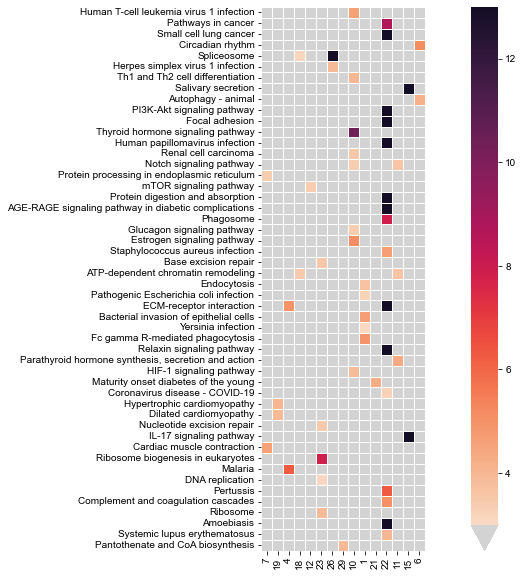

In [11]:
import matplotlib as mpl
import seaborn as sbn

myclustorder=[7, 3, 13, 2, 8, 19, 4, 24, 18, 12, 5, 9, 23, 14, 25, 26, 29, 17, 10, 1, 21, 27, 22, 0, 20, 16, 11, 15, 6, 28]

tmp=np.loadtxt('data/KEGG_pathway_enrichment_by_cluster_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.txt')
pvalsbylocationlog2=tmp
pvalsbylocationlog2[:] = pvalsbylocationlog2[:, myclustorder]
#pvalsbylocationlog2=pvalsbylocationlog

print(pvalsbylocationlog2)

mymask=np.any(pvalsbylocationlog2 > -math.log10(1e-3), axis=1);
print(np.any(pvalsbylocationlog2 > -math.log10(1e-3), axis=1))
mymask2=np.any(pvalsbylocationlog2 > -math.log10(1e-3), axis=0);
print(mymask2)

mysubfeats=[]
for i in range(0,len(mymask)):
    if mymask[i] == True:
        mysubfeats.append(subpathnamelist[i])
        
mysubcl=[]
for i in range(0,len(mymask2)):
    if mymask2[i] == True:
        mysubcl.append(myclustorder[i])


c = sbn.color_palette('rocket_r', 20)
green = mpl.colors.LinearSegmentedColormap.from_list('alex_lv', c)
green.set_under(alpha=0)
green.set_under('lightgrey')

tmp=pvalsbylocationlog2[mymask,:]

## If want to look at all 90 features
fig, ax = plt.subplots(figsize = (len(mysubfeats)/3, 10)) 
sbn.heatmap(tmp[:,mymask2],cmap=green,vmin=-math.log10(1e-3), vmax=13, cbar_kws={'extend': 'min'}, square=True, linewidth=.5)
plt.yticks(np.arange(0.5, len(mysubfeats), 1), mysubfeats,rotation=0) 
plt.xticks(np.arange(0.5, len(mysubcl), 1),mysubcl,rotation=90) 

#plt.savefig('Figures/2024_02/kegg_enrichment/fisher_exact_test_pvals_kegg_pathway_heatmap_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.pdf', transparent=True, bbox_inches = "tight") 


## 2.6 - Get number of IDRs in each pathway

In [12]:
tmp=np.loadtxt('data/KEGG_pathway_number_of_idrs_by_pathway_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.txt')

count=-1
numIDRsbypath=[]
for a in range(0,len(subpathnamelist)):
    tmpcount=0
    for c in range(0,numkclusts):
        count=count+1
        tmpcount=tmpcount+tmp[count]
    numIDRsbypath.append(round(tmpcount))
        
print(len(numIDRsbypath))
print(numIDRsbypath[0:2])
print(numIDRsbypath[:-2])

315
[54, 63]
[54, 63, 57, 107, 20, 48, 65, 77, 42, 55, 215, 99, 18, 21, 40, 17, 12, 26, 29, 20, 86, 88, 70, 26, 52, 59, 86, 103, 74, 38, 83, 30, 51, 38, 27, 39, 30, 43, 24, 27, 102, 74, 50, 49, 47, 37, 36, 13, 45, 65, 81, 42, 57, 133, 21, 11, 96, 47, 66, 99, 46, 125, 11, 33, 21, 162, 45, 51, 23, 48, 30, 38, 27, 49, 42, 67, 58, 22, 49, 24, 43, 47, 25, 124, 40, 34, 31, 60, 42, 42, 30, 57, 48, 109, 82, 31, 83, 5, 219, 38, 57, 18, 22, 32, 31, 14, 13, 96, 2, 7, 37, 37, 131, 12, 53, 49, 48, 30, 14, 49, 95, 3, 2, 1, 20, 4, 10, 88, 43, 15, 17, 33, 32, 83, 7, 31, 50, 12, 24, 23, 21, 16, 24, 10, 95, 8, 25, 75, 30, 66, 112, 21, 16, 113, 8, 28, 19, 19, 10, 3, 6, 20, 32, 92, 66, 58, 58, 56, 36, 25, 43, 37, 29, 23, 31, 39, 29, 26, 11, 35, 50, 31, 36, 22, 15, 36, 44, 4, 6, 2, 2, 1, 2, 52, 3, 9, 7, 19, 25, 4, 42, 12, 23, 26, 6, 44, 27, 20, 24, 7, 1, 24, 42, 53, 13, 16, 26, 11, 5, 13, 9, 22, 27, 29, 30, 10, 10, 26, 33, 21, 21, 39, 5, 32, 17, 24, 13, 12, 10, 28, 14, 6, 18, 12, 17, 9, 12, 2, 5, 12, 12, 2

## 2.7 - Plot pathway enrichment data if at least 25 IDRs

['Metabolic pathways (219)', 'Pathways in cancer (215)', 'Human papillomavirus infection (162)', 'PI3K-Akt signaling pathway (133)', 'Transcriptional misregulation in cancer (131)', 'Pathways of neurodegeneration - multiple diseases (125)', 'MAPK signaling pathway (124)', 'Endocytosis (113)', 'ATP-dependent chromatin remodeling (112)', 'Wnt signaling pathway (109)', 'Cushing syndrome (107)', 'Amyotrophic lateral sclerosis (103)', 'Calcium signaling pathway (102)', 'MicroRNAs in cancer (99)', 'Alzheimer disease (99)', 'Focal adhesion (96)', 'Lysine degradation (96)', 'Polycomb repressive complex (95)', 'Protein digestion and absorption (95)', 'Tight junction (92)', 'Hepatocellular carcinoma (88)', 'Regulation of actin cytoskeleton (88)', 'Breast cancer (86)', 'Spliceosome (86)', 'Hippo signaling pathway (83)', 'Motor proteins (83)', 'Proteoglycans in cancer (83)', 'Signaling pathways regulating pluripotency of stem cells (82)', 'cAMP signaling pathway (81)', 'Human T-cell leukemia virus

([<matplotlib.axis.XTick at 0x153dbbd91a90>,
 [Text(0.5, 0, '7'),
  Text(1.5, 0, '19'),
  Text(2.5, 0, '4'),
  Text(3.5, 0, '18'),
  Text(4.5, 0, '12'),
  Text(5.5, 0, '23'),
  Text(6.5, 0, '26'),
  Text(7.5, 0, '10'),
  Text(8.5, 0, '1'),
  Text(9.5, 0, '22'),
  Text(10.5, 0, '11'),
  Text(11.5, 0, '15'),
  Text(12.5, 0, '6')])

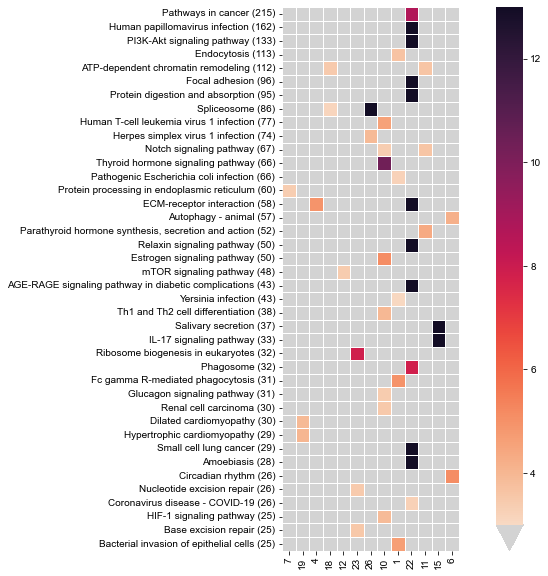

In [22]:
minIDRnum=25
numkclusts=max(subclusters)+1

myclustorder=[7, 3, 13, 2, 8, 19, 4, 24, 18, 12, 5, 9, 23, 14, 25, 26, 29, 17, 10, 1, 21, 27, 22, 0, 20, 16, 11, 15, 6, 28]

tmp=np.loadtxt('data/KEGG_pathway_enrichment_by_cluster_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.txt')

# sort by number of IDRs in each location
idx=np.flip(np.argsort(numIDRsbypath))
tmppvalsbylocationlog=np.zeros((sum(i >= minIDRnum for i in numIDRsbypath),numkclusts))
sortedpathnames=[]
sortedpathnamesnonums=[]
count=-1
for i in range(0,len(idx)):
    if numIDRsbypath[idx[i]]>=minIDRnum:
        count=count+1
        tmppvalsbylocationlog[count,:]=tmp[idx[i],:]
        sortedpathnames.append(subpathnamelist[idx[i]]+' ('+str(numIDRsbypath[idx[i]])+')')
        sortedpathnamesnonums.append(subpathnamelist[idx[i]])
print(sortedpathnames)

pvalsbylocationlog2=tmppvalsbylocationlog
pvalsbylocationlog2[:] = pvalsbylocationlog2[:, myclustorder]
print(pvalsbylocationlog2)

mymask=np.any(pvalsbylocationlog2 > -math.log10(1e-3), axis=1);
print(np.any(pvalsbylocationlog2 > -math.log10(1e-3), axis=1))
mymask2=np.any(pvalsbylocationlog2 > -math.log10(1e-3), axis=0);
print(mymask2)

mysubfeats=[]
for i in range(0,len(mymask)):
    if mymask[i] == True:
        mysubfeats.append(sortedpathnames[i])
        
mysubcl=[]
for i in range(0,len(mymask2)):
    if mymask2[i] == True:
        mysubcl.append(myclustorder[i])


c = sbn.color_palette('rocket_r', 20)
green = mpl.colors.LinearSegmentedColormap.from_list('alex_lv', c)
green.set_under(alpha=0)
green.set_under('lightgrey')

tmp=pvalsbylocationlog2[mymask,:]
maskedvals=tmp[:,mymask2]

## If want to look at all 90 features
fig, ax = plt.subplots(figsize = (len(mysubfeats)/3, 10)) 
sbn.heatmap(tmp[:,mymask2],cmap=green,vmin=-math.log10(1e-3), vmax=13, cbar_kws={'extend': 'min'}, square=True, linewidth=.5)
plt.yticks(np.arange(0.5, len(mysubfeats), 1), mysubfeats,rotation=0) 
plt.xticks(np.arange(0.5, len(mysubcl), 1),mysubcl,rotation=90)

#plt.savefig('Figures/2024_02/kegg_enrichment/fisher_exact_test_pvals_kegg_pathway_heatmap_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'_gte_'+str(minIDRnum)+'_IDRs.pdf', transparent=True, bbox_inches = "tight") 

## 2.8 - Add data to excel file

In [24]:
pathdf=pd.DataFrame()
pathdf['Pathway']=mysubfeats
for i in range(0,len(mysubcl)):
    pathdf[mysubcl[i]]=maskedvals[:,i]
    
print(pathdf)

#with pd.ExcelWriter('../Supplementary_Tables/Table_S3.xlsx', engine='openpyxl',mode='a') as writer:
#    pathdf.to_excel(writer,sheet_name='Fig_S3B')

                                              Pathway         7        19  \
0                            Pathways in cancer (215)  0.017212  0.013078   
1                Human papillomavirus infection (162)  0.017881  0.000669   
2                    PI3K-Akt signaling pathway (133)  0.038467  0.002159   
3                                   Endocytosis (113)  0.064856  0.085967   
4            ATP-dependent chromatin remodeling (112)  0.355709  0.356887   
5                                 Focal adhesion (96)  0.022939  0.049563   
6               Protein digestion and absorption (95)  0.023683 -0.000000   
7                                    Spliceosome (86)  0.314223  0.069269   
8        Human T-cell leukemia virus 1 infection (77)  0.690965  0.020838   
9               Herpes simplex virus 1 infection (74)  0.180046  0.799159   
10                       Notch signaling pathway (67) -0.000000  0.031442   
11             Thyroid hormone signaling pathway (66)  0.060762  0.032771   